In [2]:
# Performace analysis, ML training, and predictive screening

In [3]:
# loading
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors  
from rdkit.Chem import Lipinski
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

#import pubchempy as pcp
#from IPython.display import Imag

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.ensemble import RandomForestRegressor

#import torch
from scipy import stats
from scipy.stats import pearsonr
import os

import joblib
import json

from openbabel import pybel

from itertools import chain


In [4]:
## Remove data column with std=0
def clean_std(df):
    print('Before clean', df.shape )
    #X_features.loc[ :, X_features.std() > X_features.mean() ]
    df_new = df.loc[ :, df.std()>0 ]
    print('After clean', df_new.shape )
    return df_new

# Remove high correlated data, step by step
def remove_high_corr_gradually(df, cutoff=0.9, highlight=None):
    corr_matx = df.corr()
    #sns.heatmap(corr_matx.abs())
    # The upper triangle of absolute values
    upper_tri = corr_matx.abs().where(np.triu(np.ones(corr_matx.shape),k=1).astype(bool))
    upper_tri = upper_tri>cutoff
    
    for n in range(len(upper_tri)):
        if upper_tri.sum().sum()>0:
            ## Find which one has the most overlap 
            occur = upper_tri.sum(axis=0).add( upper_tri.sum(axis=1) ).sort_values(ascending=False)
            bad_fp = list( occur.index )[0]
            #print( bad_fp, occur[bad_fp])
            upper_tri.drop( bad_fp, axis=1, inplace=True)
            upper_tri.drop( bad_fp, axis=0, inplace=True)
        else:
            break
    
    print("Num of keep: ",len(upper_tri.columns))
    print("Num of drop: ",len(df.columns)-len(upper_tri.columns))
    print("---------")
    
    if highlight is not None:
        highlight = corr_matx[ highlight ]
        
    return  df[ upper_tri.columns ], highlight

## Standardization of a pd dataframe
def get_std(data_x):   
    scaler = StandardScaler()
    scaler.fit(data_x)
    X_scale = scaler.transform(data_x)
    data_new = pd.DataFrame(X_scale, columns=data_x.columns, index=data_x.index)
    return data_new, scaler  ## Save the new data, and its scaler

# Standardization of a dict of pd dataframe
def standard_dataset(dataset_dict):
    dataset_new = dataset_dict.copy()
    x_train, scaler = get_std(dataset_dict['x_train'])
    x_test = scaler.transform(dataset_dict['x_test'])
    x_test = pd.DataFrame(x_test, columns=dataset_dict['x_test'].columns, index=dataset_dict['x_test'].index)
    x_val = scaler.transform(dataset_dict['x_val'])
    x_val = pd.DataFrame(x_val, columns=dataset_dict['x_val'].columns, index=dataset_dict['x_val'].index)
    dataset_new['x_train'] = x_train
    dataset_new['x_test'] = x_test
    dataset_new['x_val'] = x_val
    dataset_new['scaler'] = scaler
    return dataset_new

## split train, text, valid
def split_data(x,y, rand_state=0):
    # Assign 20% data as testing data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state =rand_state, shuffle = True)
    # Assign 20% data as val data, so train data is 60%.  val size = 0.8*0.125 = 0.1
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=rand_state)    
    print("Train, Test, Val sizes are: ", x_train.shape, x_test.shape, x_val.shape)

    return  x_train, x_test, x_val, y_train, y_test, y_val

## Call lazypredictor
from lazypredict.Supervised import LazyRegressor

def do_lazy_regression(data_dict, ylabel=None, rg="all"):
    reg = LazyRegressor(verbose=2,ignore_warnings=False, custom_metric=None, regressors=rg)
    if ylabel is not None:
        models,predictions = reg.fit(data_dict['x_train'], data_dict['x_test'], data_dict['y_train'][ylabel], data_dict['y_test'][ylabel])
    else:
        models,predictions = reg.fit(data_dict['x_train'], data_dict['x_test'], data_dict['y_train'], data_dict['y_test'])
    return models, predictions

def know_any_depth(x_train, y_train, x_test, y_test, model_algorithm, name='None', max_layer=20, vb=0):
    values = [i for i in range(1, max_layer)]  ## depth of tree
    train_scores, test_scores =[], []
    r2_train,rmse_train,r2_test,rmse_test = [],[],[],[]
    # evaluate a decision tree for each depth
    for i in values:
        model = model_algorithm(max_depth=i, verbose=vb)
        model.fit(x_train, y_train)
        y_pred_train=model.predict(x_train)
        y_pred_test=model.predict(x_test)
        r2_train.append( metrics.r2_score(y_train, y_pred_train) )
        rmse_train.append( metrics.mean_squared_error(y_train, y_pred_train, squared=False) )
        r2_test.append( metrics.r2_score(y_test, y_pred_test) )
        rmse_test.append( metrics.mean_squared_error(y_test, y_pred_test, squared=False) )
        # summarize progress
        print('>%d, train: %.3f, test: %.3f' % (i, r2_train[-1], r2_test[-1]))
    # plot of train and test scores vs tree depth
    fig, axs = plt.subplots(1,2,figsize=(12,6),tight_layout=True)
    axs[0].plot(values, r2_train, '-o', label='Train')
    axs[0].plot(values, r2_test, '-o', label='Test')
    axs[0].set_xticks( np.arange(1,max_layer+1,1) )
    axs[0].grid(axis='both',color='g')
    axs[0].legend()
    axs[0].set_title('R2')
    axs[1].plot(values, rmse_train, '-o', label='Train')
    axs[1].plot(values, rmse_test, '-o', label='Test')
    axs[1].set_xticks( np.arange(1,max_layer+1,1) )
    axs[1].grid(axis='both',color='g')
    axs[1].legend()
    axs[1].set_title('RMSE')
    #pyplot.savefig("testtrain90-10.png", dpi=300)
    plt.show()
    print("=============Done==============")
    
def model_any_fit(x_train,y_train, x_test,y_test, model_algorithm, name='None', axs_lim=None,savefig=None, ml_parameter=None):
    if ml_parameter is None:
        model = model_algorithm( )
    else:
        model = model_algorithm(**ml_parameter)
    model = model.fit(x_train, y_train)
    y_pred_train=model.predict(x_train)
    y_pred_test=model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))    
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)

    print("================ Info =================")
    print(">>>>>> Train set", x_train.shape)
    print("R square score: " , r2_train)
    print("RMSE, MAE: ", rmse_train, mae_train)
    print(">>>>>> Test set", x_test.shape)
    print("R square score: " , r2_test)
    print("RMSE, MAE: ", rmse_test, mae_test)
    
    fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True)
    axs.plot(y_train, y_pred_train, 'o', color='orange', label='Training',alpha=0.8, markersize=5)           # scatter plot showing actual data
    axs.plot(y_test, y_pred_test, 'v', color='g', label='Testing',alpha=0.2, markersize=3)           # scatter plot showing actual data
    axs.plot([-100,100], [-100,100], '--', color='k') 

    a_train, b_train = np.polyfit(y_train, y_pred_train, 1)
    a_test, b_test = np.polyfit(y_test, y_pred_test, 1)
    if axs_lim is None:
        ax_min = np.amin([np.amin(y_train), np.amin(y_test)])-0.3
        ax_max = np.amax([np.amax(y_train), np.amax(y_test)])+0.3
        axs.set_xlim((ax_min,ax_max))
        axs.set_ylim((ax_min,ax_max))
    else:
        axs.set_xlim(axs_lim)
        axs.set_ylim(axs_lim)

    axs.set_xlabel('Reference ',fontsize=10) ## input X name
    axs.set_ylabel('ML prediction',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize=8)
    
    axs.legend(fontsize=8, frameon=False,)
    plt.title(name)
        
    r2_train, rmse_train, mae_train, r2_test, rmse_test, mae_test = np.round([r2_train,rmse_train,mae_train,r2_test,rmse_test,mae_test], 2)
    performance_train = f'R$^2$: {r2_train}\nRMSE: {rmse_train}\nMAE: {mae_train}'
    performance_test = f'R$^2$: {r2_test}\nRMSE: {rmse_test}\nMAE: {mae_test}'
    axs.text(0.65,0.25, performance_train, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white',color='orange')
    axs.text(0.65,0.05, performance_test,  style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white',color='g')

    if savefig is not None:
        plt.savefig(savefig, dpi=800)
    plt.show()
    return model

## Evaluate validation data
def score_val(x_val, y_val, model, name='',axs_lim=None, savefig=None, alpha=0.5):
    y_predict_val = model.predict(x_val)
    
    fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True )#,dpi=100)
    #axs.plot(y_val, y_predict_val, 'o', color='r',label='Validating')  
    
    x,y,z = color_density(y_val, y_predict_val)
    #z = plt.cm.jet(z)            
    im = axs.scatter(x, y, marker='o', c=z, cmap='jet', label='Validating', alpha=alpha, s=10) 
    
    axs.plot([-100,100], [-100,100], '--', color='k', lw=1)
    
    a, b = np.polyfit(y_val, y_predict_val, 1)
    #axs.plot(y_val, a*y_val+b, color='r') 
    
    r2_val, _ = stats.pearsonr( y_val, y_predict_val )
    #r2_val = metrics.r2_score(y_val, y_predict_val)
    rmse_val = np.sqrt(metrics.mean_squared_error(y_val, y_predict_val))    
    mae_val = metrics.mean_absolute_error(y_val, y_predict_val)
    print(">>>>>> Val set", y_val.shape)
    print("R square score: " , r2_val)
    print("RMSE, MAE:", rmse_val, mae_val)
    
    #plt.text(-11,-6.5, 'R^2 = 0.811')
    if axs_lim is None:
        ax_min = np.amin([np.amin(y_val), np.amin(y_predict_val)])-0.1
        ax_max = np.amax([np.amax(y_val), np.amax(y_predict_val)])+0.1
        axs.set_xlim((ax_min,ax_max))
        axs.set_ylim((ax_min,ax_max))
    else:
        axs.set_xlim(axs_lim)
        axs.set_ylim(axs_lim)
    
    axs.set_xlabel('Reference ',fontsize=10) ## input X name
    axs.set_ylabel('ML prediction',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize=8)
    
    plt.title(name)
    #fig.colorbar(im, shrink=0.5, label='Density')

    r2_val, rmse_val, mae_val = np.round([r2_val, rmse_val, mae_val], 2)
    performance = f'R$^2$: {r2_val}\nRMSE: {rmse_val}\nMAE: {mae_val}'
    axs.text(0.6,0.05, performance, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white', color='k')
    
    #axs.legend(fontsize=8, frameon=False,)
    if savefig is not None:
        plt.savefig(savefig, dpi=800)      
    plt.show()
    
    return r2_val, rmse_val, mae_val
    
def color_density(x,y):
    x= np.array(x)
    y= np.array(y)
    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    return x,y,z

def xyz_to_smiles(fname: str) -> str:
    mol = next(pybel.readfile("xyz", fname))
    smi = mol.write(format="smi")
    return smi.split()[0].strip()

def smiles_to_xyz_pybel(smi, if_write_xyz='molecule.xyz', if_overwrite=False):
    mol = pybel.readstring("smi", smi)
    mol.addh() # add Hs for 3D
    mol.make3D() # generate 3D coordinates
    if if_write_xyz is not None:
        xyz = mol.write(format='xyz',filename=if_write_xyz, overwrite=if_overwrite)
    else:
        xyz = mol.write(format='xyz')
    return xyz

In [5]:
import scipy.stats as stats

def see_correlation(df, xlabel, ylabel='LUMO', color=None):
    fig, axs = plt.subplots(1,1, figsize=(5,4),tight_layout=True)
    y= np.array(df[ylabel])
    x= np.array(df[xlabel])
    if color is None:
        xy = np.vstack([x, y])
        z = stats.gaussian_kde(xy)(xy)
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    else:
        z = color
    #z = plt.cm.jet(z) 
    
    correlation_coefficient = stats.pearsonr(x, y)[0]
    print(correlation_coefficient)

    im = axs.scatter( x,y, c=z, marker='o', cmap='jet',alpha=0.5, edgecolors='none', s=20)
    axs.set_ylabel(ylabel,fontsize=14) ## input X name
    axs.set_xlabel(xlabel,fontsize=14) ## input Y name
    axs.tick_params(direction='in',labelsize='10')
    plt.show()

# Precondition

In [5]:
df_diene = pd.read_csv('df_diene_final_dataset.csv', index_col=0)

col_to_drop = ['rdk_Ipc'] ## https://github.com/rdkit/rdkit/issues/1527
col_to_drop += [ c for c in df_diene.columns if '_fr_' in c ]
df_diene = df_diene.drop(col_to_drop, axis=1)  


df_pnl = df_diene[ df_diene['source'] =='PNL' ].sort_values(by='LUMO',ascending=True)
df_pnl

LUMO  HOMO source  \
N#Cc1nnc(C#N)nn1                                   -4.55 -8.22    PNL   
[H]C(=O)c1nnc(C#N)nn1                              -4.30 -7.88    PNL   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                 -4.26 -8.12    PNL   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                -4.21 -8.20    PNL   
[H]O[S@+]([O-])c1nnc(C#N)nn1                       -4.19 -7.86    PNL   
...                                                  ...   ...    ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...  0.75 -3.55    PNL   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...  0.77 -3.80    PNL   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     0.83 -3.96    PNL   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  0.98 -3.65    PNL   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  1.02 -3.74    PNL   

                                                   diene_type diene_class  \
N#Cc1nnc(C#N)nn1                                        2_two          N4   
[H]C(=O)c1nnc(C#N)nn1                                   2_two          N4   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                    0_three          C4   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                   0_three          C4   
[H]O[S@+]([O-])c1nnc(C#N)nn1                            2_two          N4   
...                                                       ...         ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...    0_three          C4   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...    0_three          C4   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]         0_two          C4   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...    0_three          C4   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...    0_three          C4   

                                                                                                Inchi  \
N#Cc1nnc(C#N)nn1                                                InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3   
[H]C(=O)c1nnc(C#N)nn1                                     InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                  InChI=1S/C7H3N3/c8-4-2-1-3-7(5-9)6-10/h1-3H/b2-1+   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                 InChI=1S/C7H3N3/c8-4-1-2-7(6-10)3-5-9/h1-3H/b2...   
[H]O[S@+]([O-])c1nnc(C#N)nn1                        InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...   
...                                                                                               ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...  InChI=1S/C7H14N2O/c1-9(2)6-4-5-7(8)10-3/h4-6H,...   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...  InChI=1S/C7H14N2/c1-7(9(2)3)5-4-6-8/h4-6H,8H2,...   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     InChI=1S/C4H8N2/c5-3-1-2-4-6/h1-4H,5-6H2/b3-1+...   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  InChI=1S/C9H18N2O/c1-10(2)8-6-7-9(12-5)11(3)4/...   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  InChI=1S/C7H14N2O/c1-9(2)7(10-3)5-4-6-8/h4-6H,...   

                                                    rdk_MaxAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                                     8.16   
[H]C(=O)c1nnc(C#N)nn1                                                9.92   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                                   8.17   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                                  8.25   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                        10.22   
...                                                                   ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...                   5.33   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...                   5.13   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]                      4.93   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...                   5.11   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...                   5.13   

                                                    rdk_MaxEStat

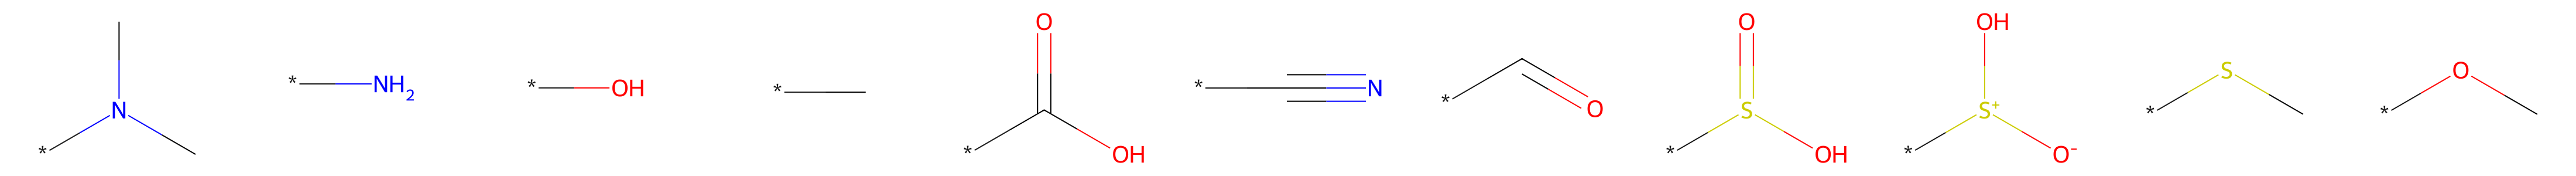

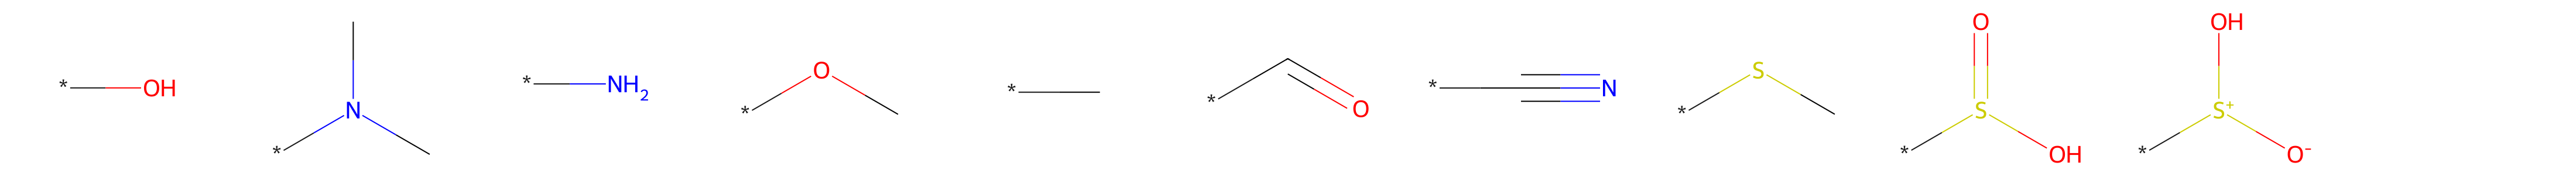

['CN(C)C',
 'CN',
 'CO',
 'CC',
 'CC(=O)O',
 'CC#N',
 'CC=O',
 'CS(=O)O',
 'C[S+]([O-])O',
 'CSC',
 'COC']

['CO',
 'CN(C)C',
 'CN',
 'COC',
 'CC',
 'CC=O',
 'CC#N',
 'CSC',
 'CS(=O)O',
 'C[S+]([O-])O']

[]

In [6]:
## If needed, tag parameterization and prediction
func1 = ['CN(C)C', 'CN', 'CO', 'CC', 'CC(=O)O', 'CC#N', 'CC=O',   'CS(=O)O', 'C[S+]([O-])O', 'CSC',  'COC' ]
img = Draw.MolsToGridImage( [Chem.MolFromSmiles('*'+p[1:]) for p in func1], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
display(img)

func2 = ['CO', 'CN(C)C', 'CN', 'COC',   'CC', 'CC=O',   'CC#N','CSC', 'CS(=O)O','C[S+]([O-])O']
img = Draw.MolsToGridImage( [Chem.MolFromSmiles('*'+p[1:]) for p in func2], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
display(img)

func3 = [ f for f in func2 if f not in func1 ]
if len(func3)>0:
    img = Draw.MolsToGridImage( [Chem.MolFromSmiles('*'+p[1:]) for p in func3], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
    display(img )

display(func1, func2, func3)

['FC(F)(F)NC(F)(F)F', 'FNF', 'OF', 'FC(F)F', 'O=COF', 'C#N', 'O=CF', 'O=[SH]OF', '[O-][S+]OF', 'FC(F)(F)S', 'OC(F)(F)F']


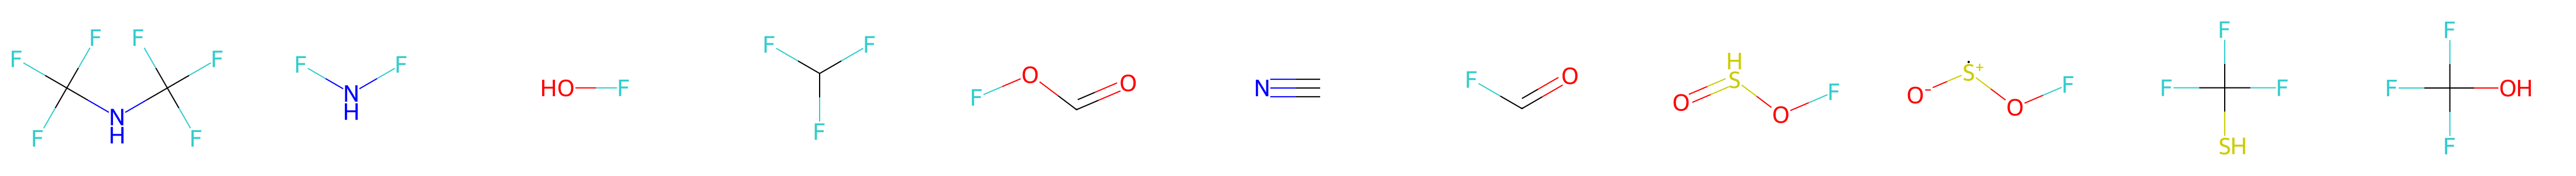

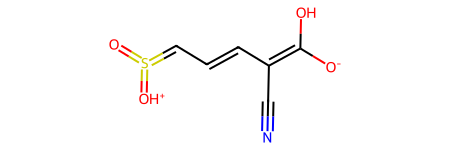

True

In [7]:
from rdkit.Chem.MolStandardize import rdMolStandardize
uncharger = rdMolStandardize.Uncharger() 

def has_substructure(smi, sub_structs):
    mol = Chem.MolFromSmiles(smi)
    Chem.Kekulize(mol)
    if mol is None:
        match = False
    else:
        match = False
        for s in sub_structs:
            m = Chem.MolFromSmiles(s)
            Chem.Kekulize(m)
            match = np.all([ mol.HasSubstructMatch( m ), m.HasSubstructMatch( mol ) ])
            if match:
                break
    return match

def know_fragment(molecule_smile, pattern_smile, list_keep_smile):
    m1 =  Chem.AddHs(Chem.MolFromSmiles(molecule_smile))
    m2 =  Chem.MolFromSmiles(pattern_smile)
    #display(m1)

    rm = AllChem.DeleteSubstructs(m1, m2)
    fragment_smile = Chem.MolToSmiles(rm)
    
    fragment_smile = [ f.replace('[H]','F') for f in fragment_smile.split('.') if f!='[HH]' ]
    #fragment_smile = [ f.replace('[O-][S+]','O=S') for f in fragment_smile ] 
    #fragment_smile = [ f.replace('[S+][O-]','S=O') for f in fragment_smile ] 
    #print(fragment_smile)
    
    list_keep_smile = [ Chem.MolFromSmiles(s) for s in list_keep_smile ]
    
    if_bad = False
    for f in fragment_smile:  
        mol = Chem.AddHs(Chem.MolFromSmiles(f))
        smi = Chem.MolToSmiles( mol, canonical=True, isomericSmiles=True)#.replace('[H]','Br')

        mol=Chem.MolFromSmiles(smi)
        Chem.Kekulize(mol)
        smi = Chem.MolToSmiles( mol, canonical=True, isomericSmiles=True)
        #print( f, smi )
        
        match = [ np.all([ mol.HasSubstructMatch(m_in_list), m_in_list.HasSubstructMatch(mol) ]) for m_in_list in list_keep_smile ]
        #print( match )
        match = np.any(match) # True if it finds a match to patterns, False if it has no match.
        
        if not match:
        #if smi not in list_keep_smile:
            if_bad = True
            break
    
    return if_bad


frag_to_keep = [ ]
for s in func1:
    m = Chem.AddHs( Chem.MolFromSmiles('Br'+s[1:]) )
    smi = Chem.MolToSmiles( m, canonical=True, isomericSmiles=True)
    smi = smi.replace('[H]','F').replace('(Br)','').replace('Br','')
    m = Chem.MolFromSmiles( smi )
    Chem.Kekulize(m)
    #m = Chem.RemoveHs(m, sanitize=False, updateExplicitCount=True)
    smi = Chem.MolToSmiles( m, canonical=True, isomericSmiles=True)
    frag_to_keep.append( smi )

print( frag_to_keep )
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in frag_to_keep], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
display( img )

smi1 = '[H]O/C([O-])=C(C#N)\C([H])=C(/[H])C([H])=S(=O)=[O+][H]'
smi2 = 'C=CC=C'
display( Chem.MolFromSmiles(smi1) )
results = know_fragment(smi1, smi2, frag_to_keep)
results

In [8]:
tag = []
for n, (smi, d, t) in enumerate(zip(df_pnl.index,df_pnl['diene_class'],df_pnl['diene_type'])):
    if n%1000==0:
        print('Working on ',n)
    if d=='C4':
        result = know_fragment(smi, 'C=CC=C', frag_to_keep)
    elif d=='C6':
        result = know_fragment(smi, 'C1=CC=CCC1', frag_to_keep)
    elif d=='N4':
        result = know_fragment(smi, 'C1=NN=CN=N1', frag_to_keep)
    else:
        result = 'Issue'
        print(smi)
    
    # result = True --> it contains unknown segment
    #if result and 'one' in t:
    #    result = False
    if result:
        tag.append( 'not_passed' )
    else:
        tag.append( 'passed' )
    
# Add tag
df_pnl['tag'] = tag
df_pnl_unknown = df_pnl[ df_pnl['tag']=='not_passed' ]
df_pnl = df_pnl[ df_pnl['tag']=='passed' ]
display(df_pnl, df_pnl_unknown)

Working on  0
Working on  1000
Working on  2000
Working on  3000
Working on  4000
Working on  5000


LUMO  HOMO source  \
N#Cc1nnc(C#N)nn1                                   -4.55 -8.22    PNL   
[H]C(=O)c1nnc(C#N)nn1                              -4.30 -7.88    PNL   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                 -4.26 -8.12    PNL   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                -4.21 -8.20    PNL   
[H]O[S@+]([O-])c1nnc(C#N)nn1                       -4.19 -7.86    PNL   
...                                                  ...   ...    ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...  0.75 -3.55    PNL   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...  0.77 -3.80    PNL   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     0.83 -3.96    PNL   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  0.98 -3.65    PNL   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  1.02 -3.74    PNL   

                                                   diene_type diene_class  \
N#Cc1nnc(C#N)nn1                                        2_two          N4   
[H]C(=O)c1nnc(C#N)nn1                                   2_two          N4   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                    0_three          C4   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                   0_three          C4   
[H]O[S@+]([O-])c1nnc(C#N)nn1                            2_two          N4   
...                                                       ...         ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...    0_three          C4   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...    0_three          C4   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]         0_two          C4   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...    0_three          C4   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...    0_three          C4   

                                                                                                Inchi  \
N#Cc1nnc(C#N)nn1                                                InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3   
[H]C(=O)c1nnc(C#N)nn1                                     InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                  InChI=1S/C7H3N3/c8-4-2-1-3-7(5-9)6-10/h1-3H/b2-1+   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                 InChI=1S/C7H3N3/c8-4-1-2-7(6-10)3-5-9/h1-3H/b2...   
[H]O[S@+]([O-])c1nnc(C#N)nn1                        InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...   
...                                                                                               ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...  InChI=1S/C7H14N2O/c1-9(2)6-4-5-7(8)10-3/h4-6H,...   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...  InChI=1S/C7H14N2/c1-7(9(2)3)5-4-6-8/h4-6H,8H2,...   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     InChI=1S/C4H8N2/c5-3-1-2-4-6/h1-4H,5-6H2/b3-1+...   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  InChI=1S/C9H18N2O/c1-10(2)8-6-7-9(12-5)11(3)4/...   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  InChI=1S/C7H14N2O/c1-9(2)7(10-3)5-4-6-8/h4-6H,...   

                                                    rdk_MaxAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                                     8.16   
[H]C(=O)c1nnc(C#N)nn1                                                9.92   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                                   8.17   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                                  8.25   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                        10.22   
...                                                                   ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...                   5.33   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...                   5.13   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]                      4.93   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...                   5.11   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...                   5.13   

                                                    rdk_MaxEStat

LUMO  HOMO source  \
[H]O/C([O-])=C(C#N)\C([H])=C(/[H])C([H])=S(=O)=... -3.52 -7.44    PNL   
[H]OC(=O)C(=C(\[O-])O[H])/C([H])=C(\[H])C([H])=... -3.49 -7.39    PNL   
[H]O/C([O-])=C(C([H])=S(=O)=[O+][H])\C([H])=C(/... -3.33 -7.47    PNL   
[H]O/C([O-])=C(C([H])=S(=O)=[O+][H])\C([H])=C(/... -3.32 -7.41    PNL   
[H]C(=O)C(=[S+]\C([H])([H])[H])/C([H])=C([H])/C... -3.25 -6.41    PNL   
...                                                  ...   ...    ...   
[H]O/C([O-])=C(C(/[H])=[S+]\C([H])([H])[H])\C([... -1.08 -5.00    PNL   
[H]O[S@+]([O-])O/C([H])=C(\C([H])=C=C([H])[H])N... -1.02 -5.94    PNL   
[H]O/C([O-])=C(C(/[H])=[S+]\C([H])([H])[H])\C([... -1.01 -4.83    PNL   
[H]O[S@+]([O-])C([H])([H])N(/C(SC([H])([H])[H])... -0.89 -5.31    PNL   
[H]O/C([O-])=C(C(=C([H])[H])N(C([H])([H])[H])C(... -0.88 -5.58    PNL   

                                                   diene_type diene_class  \
[H]O/C([O-])=C(C#N)\C([H])=C(/[H])C([H])=S(=O)=...    0_three          C4   
[H]OC(=O)C(=C(\[O-])O[H])/C([H])=C(\[H])C([H])=...    0_three          C4   
[H]O/C([O-])=C(C([H])=S(=O)=[O+][H])\C([H])=C(/...    0_three          C4   
[H]O/C([O-])=C(C([H])=S(=O)=[O+][H])\C([H])=C(/...    0_three          C4   
[H]C(=O)C(=[S+]\C([H])([H])[H])/C([H])=C([H])/C...    0_three          C4   
...                                                       ...         ...   
[H]O/C([O-])=C(C(/[H])=[S+]\C([H])([H])[H])\C([...    0_three          C4   
[H]O[S@+]([O-])O/C([H])=C(\C([H])=C=C([H])[H])N...    0_three          C4   
[H]O/C([O-])=C(C(/[H])=[S+]\C([H])([H])[H])\C([...    0_three          C4   
[H]O[S@+]([O-])C([H])([H])N(/C(SC([H])([H])[H])...    0_three          C4   
[H]O/C([O-])=C(C(=C([H])[H])N(C([H])([H])[H])C(...    0_three          C4   

                                                                                                Inchi  \
[H]O/C([O-])=C(C#N)\C([H])=C(/[H])C([H])=S(=O)=...  InChI=1S/C6H5NO4S/c7-4-5(6(8)9)2-1-3-12(10)11/...   
[H]OC(=O)C(=C(\[O-])O[H])/C([H])=C(\[H])C([H])=...  InChI=1S/C6H6O6S/c7-5(8)4(6(9)10)2-1-3-13(11)1...   
[H]O/C([O-])=C(C([H])=S(=O)=[O+][H])\C([H])=C(/...  InChI=1S/C6H5NO4S/c7-3-1-2-5(6(8)9)4-12(10)11/...   
[H]O/C([O-])=C(C([H])=S(=O)=[O+][H])\C([H])=C(/...  InChI=1S/C6H6O5S/c7-3-1-2-5(6(8)9)4-12(10)11/h...   
[H]C(=O)C(=[S+]\C([H])([H])[H])/C([H])=C([H])/C...  InChI=1S/C7H8O2S/c1-10-7(6-9)4-2-3-5-8/h2-6H,1...   
...                                                                                               ...   
[H]O/C([O-])=C(C(/[H])=[S+]\C([H])([H])[H])\C([...  InChI=1S/C6H9NO2S/c1-10-4-5(2-3-7)6(8)9/h2-4H,...   
[H]O[S@+]([O-])O/C([H])=C(\C([H])=C=C([H])[H])N...  InChI=1S/C5H7NO3S/c1-2-3-5(6)4-9-10(7)8/h3-4H,...   
[H]O/C([O-])=C(C(/[H])=[S+]\C([H])([H])[H])\C([...  InChI=1S/C8H13NO2S/c1-9(2)5-4-7(6-12-3)8(10)11...   
[H]O[S@+]([O-])C([H])([H])N(/C(SC([H])([H])[H])...  InChI=1S/C7H13NO2S2/c1-4-5-7(11-3)8(2)6-12(9)1...   
[H]O/C([O-])=C(C(=C([H])[H])N(C([H])([H])[H])C(...  InChI=1S/C8H13NO2S/c1-6(9(2)3)7(5-12-4)8(10)11...   

                                                    rdk_MaxAbsEStateIndex  \
[H]O/C([O-])=C(C#N)\C([H])=C(/[H])C([H])=S(=O)=...                  10.14   
[H]OC(=O)C(=C(\[O-])O[H])/C([H])=C(\[H])C([H])=...                  10.20   
[H]O/C([O-])=C(C([H])=S(=O)=[O+][H])\C([H])=C(/...                  10.27   
[H]O/C([O-])=C(C([H])=S(=O)=[O+][H])\C([H])=C(/...                  10.26   
[H]C(=O)C(=[S+]\C([H])([H])[H])/C([H])=C([H])/C...                  10.12   
...                                                                   ...   
[H]O/C([O-])=C(C(/[H])=[S+]\C([H])([H])[H])\C([...                  10.29   
[H]O[S@+]([O-])O/C([H])=C(\C([H])=C=C([H])[H])N...                   9.85   
[H]O/C([O-])=C(C(/[H])=[S+]\C([H])([H])[H])\C([...                  10.55   
[H]O[S@+]([O-])C([H])([H])N(/C(SC([H])([H])[H])...                  10.44   
[H]O/C([O-])=C(C(=C([H])[H])N(C([H])([H])[H])C(...                  10.67   

                                                    rdk_MaxEStat

In [8]:
df_pnl_unknown.to_csv('df_diene_final_dataset_not_passed.csv')
df_pnl.to_csv('df_diene_final_dataset_passed.csv')


# Read data for ML development

In [6]:
df_pnl = pd.read_csv('df_diene_final_dataset_passed.csv', index_col=0)
df_pnl

LUMO  HOMO source  \
N#Cc1nnc(C#N)nn1                                   -4.55 -8.22    PNL   
[H]C(=O)c1nnc(C#N)nn1                              -4.30 -7.88    PNL   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                 -4.26 -8.12    PNL   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                -4.21 -8.20    PNL   
[H]O[S@+]([O-])c1nnc(C#N)nn1                       -4.19 -7.86    PNL   
...                                                  ...   ...    ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...  0.75 -3.55    PNL   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...  0.77 -3.80    PNL   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     0.83 -3.96    PNL   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  0.98 -3.65    PNL   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  1.02 -3.74    PNL   

                                                   diene_type diene_class  \
N#Cc1nnc(C#N)nn1                                        2_two          N4   
[H]C(=O)c1nnc(C#N)nn1                                   2_two          N4   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                    0_three          C4   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                   0_three          C4   
[H]O[S@+]([O-])c1nnc(C#N)nn1                            2_two          N4   
...                                                       ...         ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...    0_three          C4   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...    0_three          C4   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]         0_two          C4   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...    0_three          C4   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...    0_three          C4   

                                                                                                Inchi  \
N#Cc1nnc(C#N)nn1                                                InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3   
[H]C(=O)c1nnc(C#N)nn1                                     InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                  InChI=1S/C7H3N3/c8-4-2-1-3-7(5-9)6-10/h1-3H/b2-1+   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                 InChI=1S/C7H3N3/c8-4-1-2-7(6-10)3-5-9/h1-3H/b2...   
[H]O[S@+]([O-])c1nnc(C#N)nn1                        InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...   
...                                                                                               ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...  InChI=1S/C7H14N2O/c1-9(2)6-4-5-7(8)10-3/h4-6H,...   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...  InChI=1S/C7H14N2/c1-7(9(2)3)5-4-6-8/h4-6H,8H2,...   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     InChI=1S/C4H8N2/c5-3-1-2-4-6/h1-4H,5-6H2/b3-1+...   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  InChI=1S/C9H18N2O/c1-10(2)8-6-7-9(12-5)11(3)4/...   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  InChI=1S/C7H14N2O/c1-9(2)7(10-3)5-4-6-8/h4-6H,...   

                                                    rdk_MaxAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                                     8.16   
[H]C(=O)c1nnc(C#N)nn1                                                9.92   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                                   8.17   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                                  8.25   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                        10.22   
...                                                                   ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...                   5.33   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...                   5.13   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]                      4.93   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...                   5.11   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...                   5.13   

                                                    rdk_MaxEStat

In [7]:
df_pnl['diene_type'].value_counts()

diene_type
0_three    3231
1_three    1868
0_two       336
1_two       303
2_two        53
1_one        20
0_one        18
2_one        10
Name: count, dtype: int64

In [1]:
## If needed, tag parameterization and prediction
func1 = ['CN(C)C', 'CN', 'CO', 'COC', 'CC', 'CC(=O)O', 'CC#N', 'CSC', 'CC=O', 'CS(=O)O','C[S+]([O-])O']  ## Para
img = Draw.MolsToGridImage( [Chem.MolFromSmiles('*'+p[1:]) for p in func1], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
display(img)

func2 = ['CO', 'CN(C)C', 'CN', 'COC',   'CC', 'CC=O', 'CC(=O)O', 'CC#N','CSC', 'CS(=O)O','C[S+]([O-])O']  ## Predi
img = Draw.MolsToGridImage( [Chem.MolFromSmiles('*'+p[1:]) for p in func2], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
display(img)

func3 = [ f for f in func2 if f not in func1 ]
if len(func3)>0:
    img = Draw.MolsToGridImage( [Chem.MolFromSmiles('*'+p[1:]) for p in func3], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
    display(img )

display(func1, func2, func3)

NameError: name 'Draw' is not defined

['FC(F)(F)NC(F)(F)F', 'FNF', 'OF', 'OC(F)(F)F', 'FC(F)F', 'O=COF', 'C#N', 'FC(F)(F)S', 'O=CF', 'O=[SH]OF', '[O-][S+]OF']


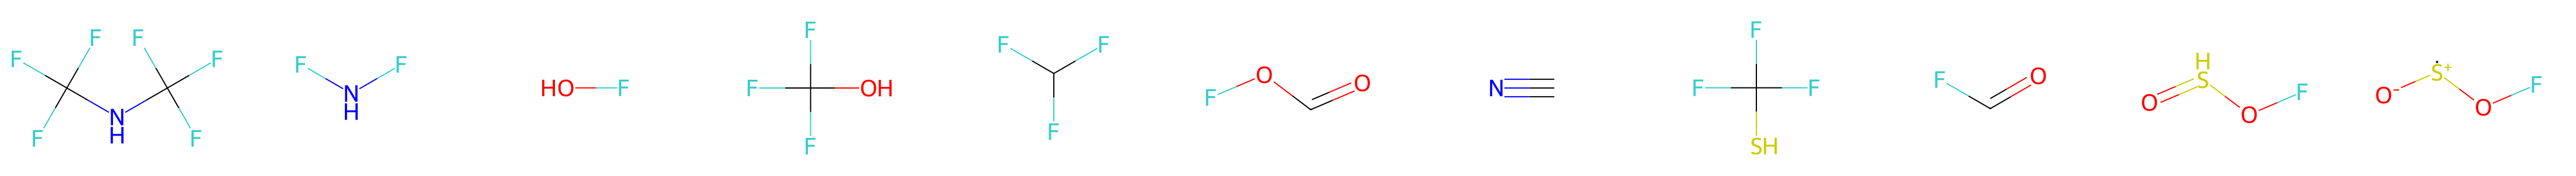

In [88]:
from rdkit.Chem.MolStandardize import rdMolStandardize
uncharger = rdMolStandardize.Uncharger() 

def has_substructure(smi, sub_structs):
    mol = Chem.MolFromSmiles(smi)
    Chem.Kekulize(mol)
    if mol is None:
        match = False
    else:
        match = False
        for s in sub_structs:
            m = Chem.MolFromSmiles(s)
            Chem.Kekulize(m)
            match = np.all([ mol.HasSubstructMatch( m ), m.HasSubstructMatch( mol ) ])
            if match:
                break
    return match

def know_fragment(molecule_smile, pattern_smile, list_keep_smile):
    m1 =  Chem.AddHs(Chem.MolFromSmiles(molecule_smile))
    m2 =  Chem.MolFromSmiles(pattern_smile)
    #display(m1)

    rm = AllChem.DeleteSubstructs(m1, m2)
    fragment_smile = Chem.MolToSmiles(rm)
    
    fragment_smile = [ f.replace('[H]','F') for f in fragment_smile.split('.') if f!='[HH]' ]
    #fragment_smile = [ f.replace('[O-][S+]','O=S') for f in fragment_smile ] 
    #fragment_smile = [ f.replace('[S+][O-]','S=O') for f in fragment_smile ] 
    #print(fragment_smile)
    
    list_keep_smile = [ Chem.MolFromSmiles(s) for s in list_keep_smile ]
    
    if_bad = False
    for f in fragment_smile:  
        mol = Chem.AddHs(Chem.MolFromSmiles(f))
        smi = Chem.MolToSmiles( mol, canonical=True, isomericSmiles=True)#.replace('[H]','Br')

        mol=Chem.MolFromSmiles(smi)
        Chem.Kekulize(mol)
        smi = Chem.MolToSmiles( mol, canonical=True, isomericSmiles=True)
        #print( f, smi )
        
        match = [ np.all([ mol.HasSubstructMatch(m_in_list), m_in_list.HasSubstructMatch(mol) ]) for m_in_list in list_keep_smile ]
        #print( match )
        match = np.any(match) # True if it finds a match to patterns, False if it has no match.
        
        if not match:
        #if smi not in list_keep_smile:
            if_bad = True
            break
    
    return if_bad


frag_to_keep = [ ]
for s in func1:
    m = Chem.AddHs( Chem.MolFromSmiles('Br'+s[1:]) )
    smi = Chem.MolToSmiles( m, canonical=True, isomericSmiles=True)
    smi = smi.replace('[H]','F').replace('(Br)','').replace('Br','')
    m = Chem.MolFromSmiles( smi )
    Chem.Kekulize(m)
    #m = Chem.RemoveHs(m, sanitize=False, updateExplicitCount=True)
    smi = Chem.MolToSmiles( m, canonical=True, isomericSmiles=True)
    frag_to_keep.append( smi )

print( frag_to_keep )
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in frag_to_keep], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
display( img )

smi1 = '[H]O/C([O-])=C(C#N)\C([H])=C(/[H])C([H])=S(=O)=[O+][H]'
smi2 = 'C=CC=C'
#display( Chem.MolFromSmiles(smi1) )
#results = know_fragment(smi1, smi2, frag_to_keep)

In [89]:
frag_to_new = [ ]
for s in func3:
    m = Chem.AddHs( Chem.MolFromSmiles('Br'+s[1:]) )
    smi = Chem.MolToSmiles( m, canonical=True, isomericSmiles=True)
    smi = smi.replace('[H]','F').replace('(Br)','').replace('Br','')
    m = Chem.MolFromSmiles( smi )
    Chem.Kekulize(m)
    #m = Chem.RemoveHs(m, sanitize=False, updateExplicitCount=True)
    smi = Chem.MolToSmiles( m, canonical=True, isomericSmiles=True)
    frag_to_new.append( smi )

print( frag_to_new )
if len(frag_to_new)>0:
    img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in frag_to_new], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
    display( img )

[]


In [90]:

tag = []
for n, (smi, d, t) in enumerate(zip(df_pnl.index,df_pnl['diene_class'],df_pnl['diene_type'])):
    if n%1000==0:
        print('Working on ',n)
    if d=='C4':
        result = know_fragment(smi, 'C=CC=C', frag_to_keep)
    elif d=='C6':
        result = know_fragment(smi, 'C1=CC=CCC1', frag_to_keep)
    elif d=='N4':
        result = know_fragment(smi, 'C1=NN=CN=N1', frag_to_keep)
    else:
        result = 'Issue 1'
        print(smi)

    if result:
        if d=='C4':
            result2 = know_fragment(smi, 'C=CC=C', frag_to_new)
        elif d=='C6':
            result2 = know_fragment(smi, 'C1=CC=CCC1', frag_to_new)
        elif d=='N4':
            result2 = know_fragment(smi, 'C1=NN=CN=N1', frag_to_new)
        else:
            result2 = 'Issue 2'
        
        if result2:
            tag.append( 'hybrid' )
        else:
            tag.append( 'prediction' )
    else:
        tag.append( 'parameterization' )
"""    
tag = []
for n, (smi, d, t) in enumerate(zip(df_pnl.index,df_pnl['diene_class'],df_pnl['diene_type'])):
    if 'three' in t:
        tag.append( 'prediction' )
    else:
        tag.append( 'parameterization' )
"""

# Add tag
df_pnl['tag'] = tag
df_pnl_unknown = df_pnl[ df_pnl['tag']=='prediction' ]
df_pnl_mixed = df_pnl[ df_pnl['tag']=='hybrid' ]
df_pnl = df_pnl[ df_pnl['tag']=='parameterization' ]
display(df_pnl, df_pnl_mixed, df_pnl_unknown)

Working on  0
Working on  1000
Working on  2000
Working on  3000
Working on  4000
Working on  5000


LUMO  HOMO source  \
N#Cc1nnc(C#N)nn1                                   -4.55 -8.22    PNL   
[H]C(=O)c1nnc(C#N)nn1                              -4.30 -7.88    PNL   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                 -4.26 -8.12    PNL   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                -4.21 -8.20    PNL   
[H]O[S@+]([O-])c1nnc(C#N)nn1                       -4.19 -7.86    PNL   
...                                                  ...   ...    ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...  0.75 -3.55    PNL   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...  0.77 -3.80    PNL   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     0.83 -3.96    PNL   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  0.98 -3.65    PNL   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  1.02 -3.74    PNL   

                                                   diene_type diene_class  \
N#Cc1nnc(C#N)nn1                                        2_two          N4   
[H]C(=O)c1nnc(C#N)nn1                                   2_two          N4   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                    0_three          C4   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                   0_three          C4   
[H]O[S@+]([O-])c1nnc(C#N)nn1                            2_two          N4   
...                                                       ...         ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...    0_three          C4   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...    0_three          C4   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]         0_two          C4   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...    0_three          C4   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...    0_three          C4   

                                                                                                Inchi  \
N#Cc1nnc(C#N)nn1                                                InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3   
[H]C(=O)c1nnc(C#N)nn1                                     InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                  InChI=1S/C7H3N3/c8-4-2-1-3-7(5-9)6-10/h1-3H/b2-1+   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                 InChI=1S/C7H3N3/c8-4-1-2-7(6-10)3-5-9/h1-3H/b2...   
[H]O[S@+]([O-])c1nnc(C#N)nn1                        InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...   
...                                                                                               ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...  InChI=1S/C7H14N2O/c1-9(2)6-4-5-7(8)10-3/h4-6H,...   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...  InChI=1S/C7H14N2/c1-7(9(2)3)5-4-6-8/h4-6H,8H2,...   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     InChI=1S/C4H8N2/c5-3-1-2-4-6/h1-4H,5-6H2/b3-1+...   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  InChI=1S/C9H18N2O/c1-10(2)8-6-7-9(12-5)11(3)4/...   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  InChI=1S/C7H14N2O/c1-9(2)7(10-3)5-4-6-8/h4-6H,...   

                                                    rdk_MaxAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                                     8.16   
[H]C(=O)c1nnc(C#N)nn1                                                9.92   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                                   8.17   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                                  8.25   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                        10.22   
...                                                                   ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...                   5.33   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...                   5.13   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]                      4.93   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...                   5.11   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...                   5.13   

                                                    rdk_MaxEStat

Empty DataFrame
Columns: [LUMO, HOMO, source, diene_type, diene_class, Inchi, rdk_MaxAbsEStateIndex, rdk_MaxEStateIndex, rdk_MinAbsEStateIndex, rdk_MinEStateIndex, rdk_qed, rdk_SPS, rdk_MolWt, rdk_HeavyAtomMolWt, rdk_ExactMolWt, rdk_NumValenceElectrons, rdk_NumRadicalElectrons, rdk_FpDensityMorgan1, rdk_FpDensityMorgan2, rdk_FpDensityMorgan3, rdk_AvgIpc, rdk_BalabanJ, rdk_BertzCT, rdk_Chi0, rdk_Chi0n, rdk_Chi0v, rdk_Chi1, rdk_Chi1n, rdk_Chi1v, rdk_Chi2n, rdk_Chi2v, rdk_Chi3n, rdk_Chi3v, rdk_Chi4n, rdk_Chi4v, rdk_HallKierAlpha, rdk_Kappa1, rdk_Kappa2, rdk_Kappa3, rdk_LabuteASA, rdk_PEOE_VSA1, rdk_PEOE_VSA10, rdk_PEOE_VSA11, rdk_PEOE_VSA12, rdk_PEOE_VSA13, rdk_PEOE_VSA14, rdk_PEOE_VSA2, rdk_PEOE_VSA3, rdk_PEOE_VSA4, rdk_PEOE_VSA5, rdk_PEOE_VSA6, rdk_PEOE_VSA7, rdk_PEOE_VSA8, rdk_PEOE_VSA9, rdk_SMR_VSA1, rdk_SMR_VSA10, rdk_SMR_VSA2, rdk_SMR_VSA3, rdk_SMR_VSA4, rdk_SMR_VSA5, rdk_SMR_VSA6, rdk_SMR_VSA7, rdk_SMR_VSA8, rdk_SMR_VSA9, rdk_SlogP_VSA1, rdk_SlogP_VSA10, rdk_SlogP_VSA11, rdk_SlogP_VSA12, rdk_SlogP_VSA2, rdk_SlogP_VSA3, rdk_SlogP_VSA4, rdk_SlogP_VSA5, rdk_SlogP_VSA6, rdk_SlogP_VSA7, rdk_SlogP_VSA8, rdk_SlogP_VSA9, rdk_TPSA, rdk_EState_VSA1, rdk_EState_VSA10, rdk_EState_VSA11, rdk_EState_VSA2, rdk_EState_VSA3, rdk_EState_VSA4, rdk_EState_VSA5, rdk_EState_VSA6, rdk_EState_VSA7, rdk_EState_VSA8, rdk_EState_VSA9, rdk_VSA_EState1, rdk_VSA_EState10, rdk_VSA_EState2, rdk_VSA_EState3, rdk_VSA_EState4, rdk_VSA_EState5, rdk_VSA_EState6, rdk_VSA_EState7, rdk_VSA_EState8, rdk_VSA_EState9, rdk_FractionCSP3, rdk_HeavyAtomCount, ...]
Index: []

[0 rows x 128 columns]

Empty DataFrame
Columns: [LUMO, HOMO, source, diene_type, diene_class, Inchi, rdk_MaxAbsEStateIndex, rdk_MaxEStateIndex, rdk_MinAbsEStateIndex, rdk_MinEStateIndex, rdk_qed, rdk_SPS, rdk_MolWt, rdk_HeavyAtomMolWt, rdk_ExactMolWt, rdk_NumValenceElectrons, rdk_NumRadicalElectrons, rdk_FpDensityMorgan1, rdk_FpDensityMorgan2, rdk_FpDensityMorgan3, rdk_AvgIpc, rdk_BalabanJ, rdk_BertzCT, rdk_Chi0, rdk_Chi0n, rdk_Chi0v, rdk_Chi1, rdk_Chi1n, rdk_Chi1v, rdk_Chi2n, rdk_Chi2v, rdk_Chi3n, rdk_Chi3v, rdk_Chi4n, rdk_Chi4v, rdk_HallKierAlpha, rdk_Kappa1, rdk_Kappa2, rdk_Kappa3, rdk_LabuteASA, rdk_PEOE_VSA1, rdk_PEOE_VSA10, rdk_PEOE_VSA11, rdk_PEOE_VSA12, rdk_PEOE_VSA13, rdk_PEOE_VSA14, rdk_PEOE_VSA2, rdk_PEOE_VSA3, rdk_PEOE_VSA4, rdk_PEOE_VSA5, rdk_PEOE_VSA6, rdk_PEOE_VSA7, rdk_PEOE_VSA8, rdk_PEOE_VSA9, rdk_SMR_VSA1, rdk_SMR_VSA10, rdk_SMR_VSA2, rdk_SMR_VSA3, rdk_SMR_VSA4, rdk_SMR_VSA5, rdk_SMR_VSA6, rdk_SMR_VSA7, rdk_SMR_VSA8, rdk_SMR_VSA9, rdk_SlogP_VSA1, rdk_SlogP_VSA10, rdk_SlogP_VSA11, rdk_SlogP_VSA12, rdk_SlogP_VSA2, rdk_SlogP_VSA3, rdk_SlogP_VSA4, rdk_SlogP_VSA5, rdk_SlogP_VSA6, rdk_SlogP_VSA7, rdk_SlogP_VSA8, rdk_SlogP_VSA9, rdk_TPSA, rdk_EState_VSA1, rdk_EState_VSA10, rdk_EState_VSA11, rdk_EState_VSA2, rdk_EState_VSA3, rdk_EState_VSA4, rdk_EState_VSA5, rdk_EState_VSA6, rdk_EState_VSA7, rdk_EState_VSA8, rdk_EState_VSA9, rdk_VSA_EState1, rdk_VSA_EState10, rdk_VSA_EState2, rdk_VSA_EState3, rdk_VSA_EState4, rdk_VSA_EState5, rdk_VSA_EState6, rdk_VSA_EState7, rdk_VSA_EState8, rdk_VSA_EState9, rdk_FractionCSP3, rdk_HeavyAtomCount, ...]
Index: []

[0 rows x 128 columns]

In [91]:
if len(df_pnl_unknown)==0:
    idx_for_unknown = []
    dt = sorted( set(df_pnl['diene_type']) )
    for t in dt:
        if 'three' in t:
            d = df_pnl[ df_pnl['diene_type']==t ]
            d = d.sample(frac=0.6,axis=0, random_state=1321)
            #n = int( 0.2*len(d) )
            idx_for_unknown += list(d.index)
    
    df_pnl_unknown = df_pnl.loc[idx_for_unknown]
    df_pnl = df_pnl.drop( idx_for_unknown, axis=0)
    display(df_pnl, df_pnl_mixed, df_pnl_unknown)

LUMO  HOMO source  \
N#Cc1nnc(C#N)nn1                                   -4.55 -8.22    PNL   
[H]C(=O)c1nnc(C#N)nn1                              -4.30 -7.88    PNL   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                -4.21 -8.20    PNL   
[H]O[S@+]([O-])c1nnc(C#N)nn1                       -4.19 -7.86    PNL   
[H]C(=O)c1nnc(C([H])=O)nn1                         -4.16 -7.55    PNL   
...                                                  ...   ...    ...   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  0.69 -3.77    PNL   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  0.69 -3.88    PNL   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...  0.77 -3.80    PNL   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     0.83 -3.96    PNL   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  0.98 -3.65    PNL   

                                                   diene_type diene_class  \
N#Cc1nnc(C#N)nn1                                        2_two          N4   
[H]C(=O)c1nnc(C#N)nn1                                   2_two          N4   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                   0_three          C4   
[H]O[S@+]([O-])c1nnc(C#N)nn1                            2_two          N4   
[H]C(=O)c1nnc(C([H])=O)nn1                              2_two          N4   
...                                                       ...         ...   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...      0_two          C4   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...      0_two          C4   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...    0_three          C4   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]         0_two          C4   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...    0_three          C4   

                                                                                                Inchi  \
N#Cc1nnc(C#N)nn1                                                InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3   
[H]C(=O)c1nnc(C#N)nn1                                     InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                 InChI=1S/C7H3N3/c8-4-1-2-7(6-10)3-5-9/h1-3H/b2...   
[H]O[S@+]([O-])c1nnc(C#N)nn1                        InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...   
[H]C(=O)c1nnc(C([H])=O)nn1                            InChI=1S/C4H2N4O2/c9-1-3-5-7-4(2-10)8-6-3/h1-2H   
...                                                                                               ...   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  InChI=1S/C8H16N2/c1-9(2)7-5-6-8-10(3)4/h5-8H,1...   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  InChI=1S/C6H12N2/c1-8(2)6-4-3-5-7/h3-6H,7H2,1-...   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...  InChI=1S/C7H14N2/c1-7(9(2)3)5-4-6-8/h4-6H,8H2,...   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     InChI=1S/C4H8N2/c5-3-1-2-4-6/h1-4H,5-6H2/b3-1+...   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  InChI=1S/C9H18N2O/c1-10(2)8-6-7-9(12-5)11(3)4/...   

                                                    rdk_MaxAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                                     8.16   
[H]C(=O)c1nnc(C#N)nn1                                                9.92   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                                  8.25   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                        10.22   
[H]C(=O)c1nnc(C([H])=O)nn1                                           9.91   
...                                                                   ...   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...                   2.00   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...                   5.06   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...                   5.13   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]                      4.93   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...                   5.11   

                                                    rdk_MaxEStat

Empty DataFrame
Columns: [LUMO, HOMO, source, diene_type, diene_class, Inchi, rdk_MaxAbsEStateIndex, rdk_MaxEStateIndex, rdk_MinAbsEStateIndex, rdk_MinEStateIndex, rdk_qed, rdk_SPS, rdk_MolWt, rdk_HeavyAtomMolWt, rdk_ExactMolWt, rdk_NumValenceElectrons, rdk_NumRadicalElectrons, rdk_FpDensityMorgan1, rdk_FpDensityMorgan2, rdk_FpDensityMorgan3, rdk_AvgIpc, rdk_BalabanJ, rdk_BertzCT, rdk_Chi0, rdk_Chi0n, rdk_Chi0v, rdk_Chi1, rdk_Chi1n, rdk_Chi1v, rdk_Chi2n, rdk_Chi2v, rdk_Chi3n, rdk_Chi3v, rdk_Chi4n, rdk_Chi4v, rdk_HallKierAlpha, rdk_Kappa1, rdk_Kappa2, rdk_Kappa3, rdk_LabuteASA, rdk_PEOE_VSA1, rdk_PEOE_VSA10, rdk_PEOE_VSA11, rdk_PEOE_VSA12, rdk_PEOE_VSA13, rdk_PEOE_VSA14, rdk_PEOE_VSA2, rdk_PEOE_VSA3, rdk_PEOE_VSA4, rdk_PEOE_VSA5, rdk_PEOE_VSA6, rdk_PEOE_VSA7, rdk_PEOE_VSA8, rdk_PEOE_VSA9, rdk_SMR_VSA1, rdk_SMR_VSA10, rdk_SMR_VSA2, rdk_SMR_VSA3, rdk_SMR_VSA4, rdk_SMR_VSA5, rdk_SMR_VSA6, rdk_SMR_VSA7, rdk_SMR_VSA8, rdk_SMR_VSA9, rdk_SlogP_VSA1, rdk_SlogP_VSA10, rdk_SlogP_VSA11, rdk_SlogP_VSA12, rdk_SlogP_VSA2, rdk_SlogP_VSA3, rdk_SlogP_VSA4, rdk_SlogP_VSA5, rdk_SlogP_VSA6, rdk_SlogP_VSA7, rdk_SlogP_VSA8, rdk_SlogP_VSA9, rdk_TPSA, rdk_EState_VSA1, rdk_EState_VSA10, rdk_EState_VSA11, rdk_EState_VSA2, rdk_EState_VSA3, rdk_EState_VSA4, rdk_EState_VSA5, rdk_EState_VSA6, rdk_EState_VSA7, rdk_EState_VSA8, rdk_EState_VSA9, rdk_VSA_EState1, rdk_VSA_EState10, rdk_VSA_EState2, rdk_VSA_EState3, rdk_VSA_EState4, rdk_VSA_EState5, rdk_VSA_EState6, rdk_VSA_EState7, rdk_VSA_EState8, rdk_VSA_EState9, rdk_FractionCSP3, rdk_HeavyAtomCount, ...]
Index: []

[0 rows x 128 columns]

LUMO  HOMO source  \
[H]C([H])=C(C#N)/C(=C(/[H])C([H])([H])[H])C([H]... -1.85 -6.76    PNL   
[H]O[S@+]([O-])/C(=C(\OC([H])([H])[H])C([H])=C(... -1.26 -5.36    PNL   
[H]C([H])=C(SC([H])([H])[H])/C(OC([H])([H])[H])... -0.33 -5.29    PNL   
[H]O[S@+]([O-])C(=C([H])/C([H])=C(/[H])SC([H])(... -2.21 -6.76    PNL   
[H]O/C([H])=C(/C(C([H])=O)=C([H])[H])[S@@+]([O-... -2.19 -6.79    PNL   
...                                                  ...   ...    ...   
[H]C1=C(N(C([H])([H])[H])C([H])([H])[H])C([H])(... -1.20 -5.33    PNL   
[H]C1=C(N([H])[H])C([H])([H])C([H])([H])C(SC([H... -1.43 -5.29    PNL   
[H]OC(=O)C1=C([H])C(N(C([H])([H])[H])C([H])([H]... -1.25 -5.18    PNL   
[H]C(=O)C1=C(C#N)C(SC([H])([H])[H])=C([H])C([H]... -3.05 -6.18    PNL   
[H]OC1=C([S@@+]([O-])O[H])C([H])([H])C([H])([H]... -2.80 -6.57    PNL   

                                                   diene_type diene_class  \
[H]C([H])=C(C#N)/C(=C(/[H])C([H])([H])[H])C([H]...    0_three          C4   
[H]O[S@+]([O-])/C(=C(\OC([H])([H])[H])C([H])=C(...    0_three          C4   
[H]C([H])=C(SC([H])([H])[H])/C(OC([H])([H])[H])...    0_three          C4   
[H]O[S@+]([O-])C(=C([H])/C([H])=C(/[H])SC([H])(...    0_three          C4   
[H]O/C([H])=C(/C(C([H])=O)=C([H])[H])[S@@+]([O-...    0_three          C4   
...                                                       ...         ...   
[H]C1=C(N(C([H])([H])[H])C([H])([H])[H])C([H])(...    1_three          C6   
[H]C1=C(N([H])[H])C([H])([H])C([H])([H])C(SC([H...    1_three          C6   
[H]OC(=O)C1=C([H])C(N(C([H])([H])[H])C([H])([H]...    1_three          C6   
[H]C(=O)C1=C(C#N)C(SC([H])([H])[H])=C([H])C([H]...    1_three          C6   
[H]OC1=C([S@@+]([O-])O[H])C([H])([H])C([H])([H]...    1_three          C6   

                                                                                                Inchi  \
[H]C([H])=C(C#N)/C(=C(/[H])C([H])([H])[H])C([H]...  InChI=1S/C7H9N/c1-4-6(2)7(3)5-8/h4H,3H2,1-2H3/...   
[H]O[S@+]([O-])/C(=C(\OC([H])([H])[H])C([H])=C(...  InChI=1S/C7H13NO3S/c1-5-6(11-4)7(8(2)3)12(9)10...   
[H]C([H])=C(SC([H])([H])[H])/C(OC([H])([H])[H])...  InChI=1S/C6H11NOS/c1-5(9-3)6(4-7)8-2/h4H,1,7H2...   
[H]O[S@+]([O-])C(=C([H])/C([H])=C(/[H])SC([H])(...  InChI=1S/C5H8O4S3/c1-10-4-2-3-5(11(6)7)12(8)9/...   
[H]O/C([H])=C(/C(C([H])=O)=C([H])[H])[S@@+]([O-...  InChI=1S/C5H6O4S/c1-4(2-6)5(3-7)10(8)9/h2-3,7H...   
...                                                                                               ...   
[H]C1=C(N(C([H])([H])[H])C([H])([H])[H])C([H])(...  InChI=1S/C10H14N2/c1-8-6-10(12(2)3)5-4-9(8)7-1...   
[H]C1=C(N([H])[H])C([H])([H])C([H])([H])C(SC([H...  InChI=1S/C8H10N2S/c1-11-8-3-2-7(10)4-6(8)5-9/h...   
[H]OC(=O)C1=C([H])C(N(C([H])([H])[H])C([H])([H]...  InChI=1S/C9H14N2O2/c1-11(2)8-5-6(9(12)13)3-4-7...   
[H]C(=O)C1=C(C#N)C(SC([H])([H])[H])=C([H])C([H]...  InChI=1S/C9H9NOS/c1-12-9-4-2-3-7(6-11)8(9)5-10...   
[H]OC1=C([S@@+]([O-])O[H])C([H])([H])C([H])([H]...  InChI=1S/C7H8O4S/c8-4-5-1-2-7(12(10)11)6(9)3-5...   

                                                    rdk_MaxAbsEStateIndex  \
[H]C([H])=C(C#N)/C(=C(/[H])C([H])([H])[H])C([H]...                   8.25   
[H]O[S@+]([O-])/C(=C(\OC([H])([H])[H])C([H])=C(...                  10.78   
[H]C([H])=C(SC([H])([H])[H])/C(OC([H])([H])[H])...                   5.20   
[H]O[S@+]([O-])C(=C([H])/C([H])=C(/[H])SC([H])(...                  10.38   
[H]O/C([H])=C(/C(C([H])=O)=C([H])[H])[S@@+]([O-...                  10.19   
...                                                                   ...   
[H]C1=C(N(C([H])([H])[H])C([H])([H])[H])C([H])(...                   8.74   
[H]C1=C(N([H])[H])C([H])([H])C([H])([H])C(SC([H...                   8.69   
[H]OC(=O)C1=C([H])C(N(C([H])([H])[H])C([H])([H]...                  10.68   
[H]C(=O)C1=C(C#N)C(SC([H])([H])[H])=C([H])C([H]...                  10.55   
[H]OC1=C([S@@+]([O-])O[H])C([H])([H])C([H])([H]...                  10.54   

                                                    rdk_MaxEStat

In [92]:
df_pnl_unknown.to_csv('df_prediction.csv')
df_pnl_mixed.to_csv('df_hybrid.csv')
df_pnl.to_csv('df_parameterization.csv')

LUMO  HOMO source diene_type  \
N#Cc1nnc(C#N)nn1                         -4.55 -8.22    PNL      2_two   
[H]C(=O)c1nnc(C#N)nn1                    -4.30 -7.88    PNL      2_two   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N      -4.21 -8.20    PNL    0_three   
[H]O[S@+]([O-])c1nnc(C#N)nn1             -4.19 -7.86    PNL      2_two   
[H]C(=O)c1nnc(C([H])=O)nn1               -4.16 -7.55    PNL      2_two   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1      -4.15 -7.81    PNL      2_two   
[H]OC(=O)c1nnc(C#N)nn1                   -4.12 -7.74    PNL      2_two   
[H]C(=O)/C([H])=C(\[H])C([H])=C(C#N)C#N  -4.12 -7.98    PNL    0_three   
[H]C(=O)/C(C#N)=C([H])\C([H])=C(/[H])C#N -4.12 -7.95    PNL    0_three   
[H]C(=O)/C([H])=C([H])/C(C#N)=C(/[H])C#N -4.11 -7.84    PNL    0_three   

                                         diene_class  \
N#Cc1nnc(C#N)nn1                                  N4   
[H]C(=O)c1nnc(C#N)nn1                             N4   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N               C4   
[H]O[S@+]([O-])c1nnc(C#N)nn1                      N4   
[H]C(=O)c1nnc(C([H])=O)nn1                        N4   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1               N4   
[H]OC(=O)c1nnc(C#N)nn1                            N4   
[H]C(=O)/C([H])=C(\[H])C([H])=C(C#N)C#N           C4   
[H]C(=O)/C(C#N)=C([H])\C([H])=C(/[H])C#N          C4   
[H]C(=O)/C([H])=C([H])/C(C#N)=C(/[H])C#N          C4   

                                                                                      Inchi  \
N#Cc1nnc(C#N)nn1                                      InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3   
[H]C(=O)c1nnc(C#N)nn1                           InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N       InChI=1S/C7H3N3/c8-4-1-2-7(6-10)3-5-9/h1-3H/b2...   
[H]O[S@+]([O-])c1nnc(C#N)nn1              InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...   
[H]C(=O)c1nnc(C([H])=O)nn1                  InChI=1S/C4H2N4O2/c9-1-3-5-7-4(2-10)8-6-3/h1-2H   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1       InChI=1S/C3H2N4O4S/c8-2(9)1-4-6-3(7-5-1)12(10)...   
[H]OC(=O)c1nnc(C#N)nn1                    InChI=1S/C4HN5O2/c5-1-2-6-8-3(4(10)11)9-7-2/h(...   
[H]C(=O)/C([H])=C(\[H])C([H])=C(C#N)C#N   InChI=1S/C7H4N2O/c8-5-7(6-9)3-1-2-4-10/h1-4H/b...   
[H]C(=O)/C(C#N)=C([H])\C([H])=C(/[H])C#N  InChI=1S/C7H4N2O/c8-4-2-1-3-7(5-9)6-10/h1-3,6H...   
[H]C(=O)/C([H])=C([H])/C(C#N)=C(/[H])C#N  InChI=1S/C7H4N2O/c8-4-3-7(6-9)2-1-5-10/h1-3,5H...   

                                          rdk_MaxAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                           8.16   
[H]C(=O)c1nnc(C#N)nn1                                      9.92   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                        8.25   
[H]O[S@+]([O-])c1nnc(C#N)nn1                              10.22   
[H]C(=O)c1nnc(C([H])=O)nn1                                 9.91   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                       10.24   
[H]OC(=O)c1nnc(C#N)nn1                                    10.11   
[H]C(=O)/C([H])=C(\[H])C([H])=C(C#N)C#N                    9.68   
[H]C(=O)/C(C#N)=C([H])\C([H])=C(/[H])C#N                   9.92   
[H]C(=O)/C([H])=C([H])/C(C#N)=C(/[H])C#N                   9.72   

                                          rdk_MaxEStateIndex  \
N#Cc1nnc(C#N)nn1                                        8.16   
[H]C(=O)c1nnc(C#N)nn1                                   9.92   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                     8.25   
[H]O[S@+]([O-])c1nnc(C#N)nn1                           10.22   
[H]C(=O)c1nnc(C([H])=O)nn1                              9.91   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                    10.24   
[H]OC(=O)c1nnc(C#N)nn1                                 10.11   
[H]C(=O)/C([H])=C(\[H])C([H])=C(C#N)C#N                 9.68   
[H]C(=O)/C(C#N)=C([H])\C([H])=C(/[H])C#N                9.92   
[H]C(=O)/C([H])=C([H])/C(C#N)=C(/[H])C#N                9.72   

                                          rdk_MinAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                      

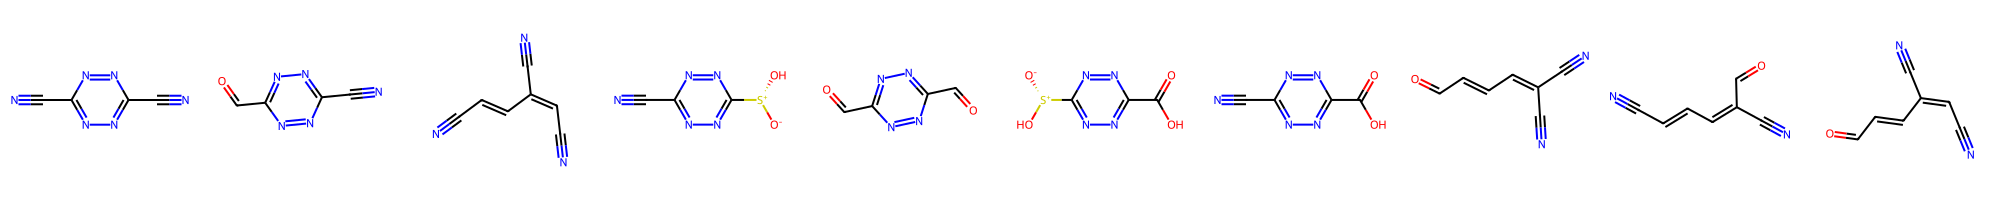

LUMO  HOMO source  \
[H]C([H])=C(C#N)/C(=C(/[H])C([H])([H])[H])C([H]... -1.85 -6.76    PNL   
[H]O[S@+]([O-])/C(=C(\OC([H])([H])[H])C([H])=C(... -1.26 -5.36    PNL   
[H]C([H])=C(SC([H])([H])[H])/C(OC([H])([H])[H])... -0.33 -5.29    PNL   
[H]O[S@+]([O-])C(=C([H])/C([H])=C(/[H])SC([H])(... -2.21 -6.76    PNL   
[H]O/C([H])=C(/C(C([H])=O)=C([H])[H])[S@@+]([O-... -2.19 -6.79    PNL   
[H]O/C(=C(/C([H])=C([H])[H])C([H])([H])[H])C([H... -0.65 -5.45    PNL   
[H]OC(=O)/C(C#N)=C([H])\C([H])=C(/[H])C([H])=O     -3.88 -7.82    PNL   
[H]O/C(C(=C([H])[H])N(C([H])([H])[H])C([H])([H]... -1.54 -6.50    PNL   
[H]C(=O)/C(=C(\C#N)C([H])=C([H])[H])N([H])[H]      -2.85 -6.53    PNL   
[H]O[S@+]([O-])C(=C([H])[H])/C([H])=C(\SC([H])(... -1.59 -6.36    PNL   

                                                   diene_type diene_class  \
[H]C([H])=C(C#N)/C(=C(/[H])C([H])([H])[H])C([H]...    0_three          C4   
[H]O[S@+]([O-])/C(=C(\OC([H])([H])[H])C([H])=C(...    0_three          C4   
[H]C([H])=C(SC([H])([H])[H])/C(OC([H])([H])[H])...    0_three          C4   
[H]O[S@+]([O-])C(=C([H])/C([H])=C(/[H])SC([H])(...    0_three          C4   
[H]O/C([H])=C(/C(C([H])=O)=C([H])[H])[S@@+]([O-...    0_three          C4   
[H]O/C(=C(/C([H])=C([H])[H])C([H])([H])[H])C([H...    0_three          C4   
[H]OC(=O)/C(C#N)=C([H])\C([H])=C(/[H])C([H])=O        0_three          C4   
[H]O/C(C(=C([H])[H])N(C([H])([H])[H])C([H])([H]...    0_three          C4   
[H]C(=O)/C(=C(\C#N)C([H])=C([H])[H])N([H])[H]         0_three          C4   
[H]O[S@+]([O-])C(=C([H])[H])/C([H])=C(\SC([H])(...    0_three          C4   

                                                                                                Inchi  \
[H]C([H])=C(C#N)/C(=C(/[H])C([H])([H])[H])C([H]...  InChI=1S/C7H9N/c1-4-6(2)7(3)5-8/h4H,3H2,1-2H3/...   
[H]O[S@+]([O-])/C(=C(\OC([H])([H])[H])C([H])=C(...  InChI=1S/C7H13NO3S/c1-5-6(11-4)7(8(2)3)12(9)10...   
[H]C([H])=C(SC([H])([H])[H])/C(OC([H])([H])[H])...  InChI=1S/C6H11NOS/c1-5(9-3)6(4-7)8-2/h4H,1,7H2...   
[H]O[S@+]([O-])C(=C([H])/C([H])=C(/[H])SC([H])(...  InChI=1S/C5H8O4S3/c1-10-4-2-3-5(11(6)7)12(8)9/...   
[H]O/C([H])=C(/C(C([H])=O)=C([H])[H])[S@@+]([O-...  InChI=1S/C5H6O4S/c1-4(2-6)5(3-7)10(8)9/h2-3,7H...   
[H]O/C(=C(/C([H])=C([H])[H])C([H])([H])[H])C([H...  InChI=1S/C6H10O/c1-4-5(2)6(3)7/h4,7H,1H2,2-3H3...   
[H]OC(=O)/C(C#N)=C([H])\C([H])=C(/[H])C([H])=O      InChI=1S/C7H5NO3/c8-5-6(7(10)11)3-1-2-4-9/h1-4...   
[H]O/C(C(=C([H])[H])N(C([H])([H])[H])C([H])([H]...  InChI=1S/C7H10N2O/c1-6(9(2)3)7(10)4-5-8/h4,10H...   
[H]C(=O)/C(=C(\C#N)C([H])=C([H])[H])N([H])[H]       InChI=1S/C6H6N2O/c1-2-5(3-7)6(8)4-9/h2,4H,1,8H...   
[H]O[S@+]([O-])C(=C([H])[H])/C([H])=C(\SC([H])(...  InChI=1S/C6H10O2S2/c1-5(9-3)4-6(2)10(7)8/h4H,2...   

                                                    rdk_MaxAbsEStateIndex  \
[H]C([H])=C(C#N)/C(=C(/[H])C([H])([H])[H])C([H]...                   8.25   
[H]O[S@+]([O-])/C(=C(\OC([H])([H])[H])C([H])=C(...                  10.78   
[H]C([H])=C(SC([H])([H])[H])/C(OC([H])([H])[H])...                   5.20   
[H]O[S@+]([O-])C(=C([H])/C([H])=C(/[H])SC([H])(...                  10.38   
[H]O/C([H])=C(/C(C([H])=O)=C([H])[H])[S@@+]([O-...                  10.19   
[H]O/C(=C(/C([H])=C([H])[H])C([H])([H])[H])C([H...                   8.63   
[H]OC(=O)/C(C#N)=C([H])\C([H])=C(/[H])C([H])=O                      10.11   
[H]O/C(C(=C([H])[H])N(C([H])([H])[H])C([H])([H]...                   8.99   
[H]C(=O)/C(=C(\C#N)C([H])=C([H])[H])N([H])[H]                        9.88   
[H]O[S@+]([O-])C(=C([H])[H])/C([H])=C(\SC([H])(...                  10.31   

                                                    rdk_MaxEStateIndex  \
[H]C([H])=C(C#N)/C(=C(/[H])C([H])([H])[H])C([H]...                8.25   
[H]O[S@+]([O-])/C(=C(\OC([H])([H])[H])C([H])=C(...               10.78   
[H]C([H])=C(SC([H])([H])[H])/C(OC([H])([H])[H])...                5.20   
[H]O[S@+]([O-])C(=C([H])/C([H])=C(/[H])SC([H])(...               10.38   
[H]O/C([H])=C(/C(C([H])=O)

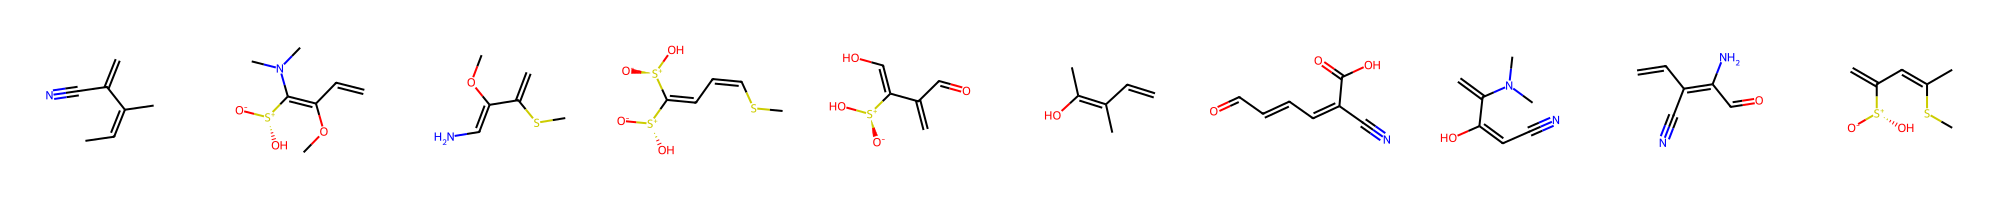

In [93]:
img1 = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df_pnl.head(10).index ], molsPerRow=10,  )
display( df_pnl.head(10), img1 )

img1 = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df_pnl_unknown.head(10).index ], molsPerRow=10,  )
display( df_pnl_unknown.head(10), img1 )


In [94]:
feature_col = [c for c in df_pnl.columns if 'rdk_' in c ]#or 'RingCount_' in c ]    

X_features = df_pnl[feature_col]
X_features = clean_std(X_features)
X_features_prop_clean, _= remove_high_corr_gradually(X_features, cutoff=0.7 )
feature_col = list( X_features_prop_clean.columns )

feature_col = ['LUMO','diene_type','diene_class'] + feature_col
print( feature_col )
df_pnl = df_pnl[feature_col]

df_pnl_c4 = df_pnl[ df_pnl['diene_class'] =='C4' ]
df_pnl_c6 = df_pnl[ df_pnl['diene_class'] =='C6' ]
df_pnl_n4 = df_pnl[ df_pnl['diene_class'] =='N4' ]

data_prop = []
for df in [df_pnl_c4, df_pnl_c6, df_pnl_n4]:
    Y_prop = df[['LUMO','diene_type','diene_class']]
    X_prop = df.drop(['LUMO','diene_type','diene_class'],axis=1)
    data_prop.append( [X_prop,Y_prop] )


Before clean (2779, 112)
After clean (2779, 101)
Num of keep:  49
Num of drop:  52
---------
['LUMO', 'diene_type', 'diene_class', 'rdk_MaxEStateIndex', 'rdk_MinAbsEStateIndex', 'rdk_FpDensityMorgan1', 'rdk_FpDensityMorgan3', 'rdk_BalabanJ', 'rdk_BertzCT', 'rdk_Chi2n', 'rdk_Chi3v', 'rdk_HallKierAlpha', 'rdk_Kappa3', 'rdk_PEOE_VSA1', 'rdk_PEOE_VSA10', 'rdk_PEOE_VSA11', 'rdk_PEOE_VSA12', 'rdk_PEOE_VSA13', 'rdk_PEOE_VSA14', 'rdk_PEOE_VSA2', 'rdk_PEOE_VSA6', 'rdk_PEOE_VSA7', 'rdk_PEOE_VSA8', 'rdk_PEOE_VSA9', 'rdk_SMR_VSA1', 'rdk_SMR_VSA10', 'rdk_SMR_VSA2', 'rdk_SMR_VSA3', 'rdk_SMR_VSA6', 'rdk_SMR_VSA7', 'rdk_SlogP_VSA10', 'rdk_SlogP_VSA11', 'rdk_SlogP_VSA12', 'rdk_SlogP_VSA2', 'rdk_EState_VSA2', 'rdk_EState_VSA3', 'rdk_EState_VSA4', 'rdk_EState_VSA5', 'rdk_EState_VSA6', 'rdk_EState_VSA7', 'rdk_EState_VSA8', 'rdk_EState_VSA9', 'rdk_VSA_EState10', 'rdk_VSA_EState2', 'rdk_VSA_EState3', 'rdk_VSA_EState4', 'rdk_VSA_EState7', 'rdk_VSA_EState8', 'rdk_NHOHCount', 'rdk_NumHeteroatoms', 'rdk_NumRota

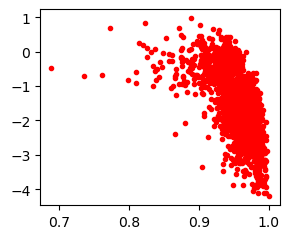

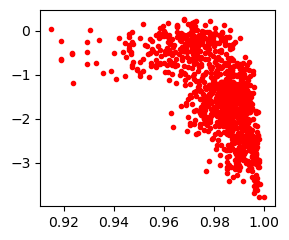

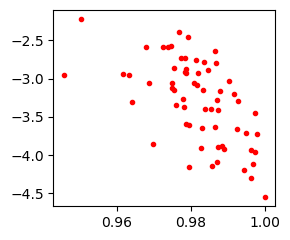

In [95]:
from numpy.linalg import norm

for data in data_prop:
    X_prop = data[0]
    Y_prop = data[1]['LUMO']

    ref = X_prop.iloc[0].values
    sel = X_prop.values

    cosine = np.dot(sel,ref)/(norm(sel,axis=1)*norm(ref))
    X_prop['COS'] = cosine

    fig, axs = plt.subplots(1,1,figsize=(3,2.5),tight_layout=True,dpi=100)
    axs.plot(X_prop['COS'], Y_prop, color='r', lw=2, ls='', marker='o', ms=3) 
    plt.show()

### See ML performance

In [96]:
global_random_seed_number = 421

Train, Test, Val sizes are:  (987, 50) (330, 50) (329, 50)
Train, Test, Val sizes are:  (642, 50) (214, 50) (214, 50)
Train, Test, Val sizes are:  (37, 50) (13, 50) (13, 50)


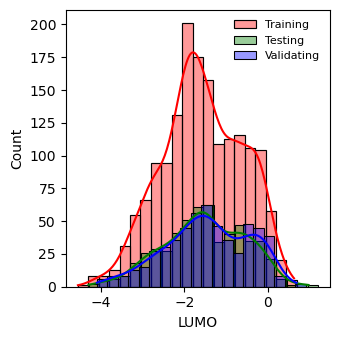

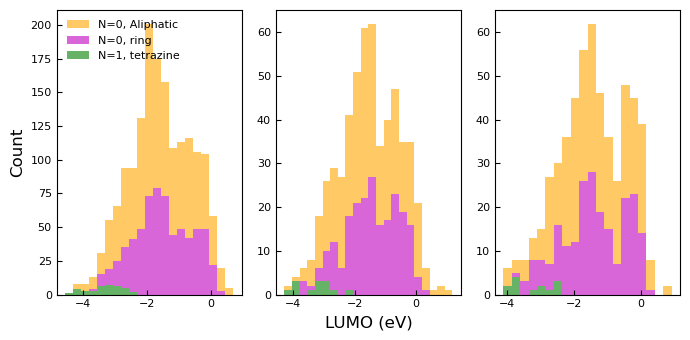

In [97]:
# The order is: df_pnl_c4, df_pnl_c6, df_pnl_n4
use_index = [0,1,2] # loop which subsets
all_prop = []  
for i in use_index:
    X_prop = data_prop[i][0]
    Y_prop = data_prop[i][1]
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=global_random_seed_number)
    data = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
    all_prop.append( data )
    
df_prop = {}  ## All together 
for k in all_prop[0].keys():  ## loop x_train, x_test,...
    df = pd.concat( [ data[k] for data in all_prop ] ,axis=0 )
    df_prop[k] = df
    
df_prop = standard_dataset(df_prop)

fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,dpi=100)
#df_prop['y_val'].plot(kind='bar', stacked=False, x='type', y='LUMO', ax=axs)
sns.histplot(df_prop['y_train']['LUMO'],  kde=True, color='r', alpha=0.4, label='Training', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_test']['LUMO'],  kde=True, color='g', alpha=0.4, label='Testing', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_val']['LUMO'],   kde=True, color='b', alpha=0.4, label='Validating', binwidth=0.25, ax=axs)
axs.legend(fontsize=8, frameon=False)
plt.show()

colors = ['orange','m','g','b','c','r']
fig, axs = plt.subplots(1,3,figsize=(7,3.5),tight_layout=True,dpi=100)
sns.histplot(df_prop['y_train'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[0], x="LUMO", hue="diene_class", element="step", legend=True, multiple="stack")
sns.histplot(df_prop['y_test'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[1], x="LUMO", hue="diene_class", element="step", legend=False, multiple="stack")
sns.histplot(df_prop['y_val'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[2], x="LUMO", hue="diene_class", element="step", legend=False, multiple="stack")
legend = axs[0].get_legend()
handles = legend.legendHandles
#legend.remove()
axs[0].legend(handles, ['N=0, Aliphatic','N=0, ring','N=1, tetrazine'], fontsize=8, frameon=False, loc=2)
for n in range(3):
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('')    
    #axs[n].set_xticks( [] )
    #axs[n].set_xlim((-4.9,2.5))
    axs[n].set_ylim(bottom=0)
    axs[n].tick_params(direction='in',labelsize=8)
    #axs[n].legend_.remove()
axs[1].set_xlabel('LUMO (eV)', fontsize=12)
axs[0].set_ylabel('Count', fontsize=12)
plt.show()

In [98]:
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin

import xgboost
import lightgbm

removed_regressors = [
    "TheilSenRegressor",
    "ARDRegression", 
    "CCA", 
    "IsotonicRegression", 
    "StackingRegressor",
    "MultiOutputRegressor", 
    "MultiTaskElasticNet", 
    "MultiTaskElasticNetCV", 
    "MultiTaskLasso", 
    "MultiTaskLassoCV", 
    "PLSCanonical", 
    "PLSRegression", 
    "RadiusNeighborsRegressor", 
    "RegressorChain", 
    "VotingRegressor",
    
    "PoissonRegressor",
    "QuantileRegressor",
]

chosen_regressors = [
    'SVR',
    'BaggingRegressor'
]

my_REGRESSORS = [
    est
    for est in all_estimators()
    #if (issubclass(est[1], RegressorMixin) and (est[0] in chosen_regressors))
    if (issubclass(est[1], RegressorMixin) and (est[0] not in removed_regressors))  
]

my_REGRESSORS.append(("XGBRegressor", xgboost.XGBRegressor))
my_REGRESSORS.append(("LGBMRegressor", lightgbm.LGBMRegressor))

for i,r in enumerate(my_REGRESSORS):
    print(i, r[0])
    
def screen_ML_performance(df_prop, regressors=my_REGRESSORS):
    x_train = df_prop['x_train']
    x_test = df_prop['x_test']
    x_val = df_prop['x_val'] 
    y_train = df_prop['y_train']['LUMO']
    y_test = df_prop['y_test']['LUMO']
    y_val =df_prop['y_val']['LUMO']
    
    colors = ['orange','m','g','b','c','r']
    fig, axs = plt.subplots(3,1,figsize=(3.5,3.5) )#,tight_layout=True,dpi=100)
    axst = [a.twinx() for a in axs]
    bw = 0.2
    sns.histplot(y_train, kde=False, color='r', alpha=1, binwidth=bw, ax=axs[0], legend=False, fill=True, element="step", label='Training')
    sns.histplot(y_test,  kde=False, color='g', alpha=1, binwidth=bw, ax=axs[1], legend=False, fill=True, element="step", label='Testing')
    sns.histplot(y_val,   kde=False, color='b', alpha=1, binwidth=bw, ax=axs[2], legend=False, fill=True, element="step", label='Validation')
    sns.kdeplot(y_train, color='k', alpha=1, ax=axst[0], legend=False, fill=False)
    sns.kdeplot(y_test,  color='k', alpha=1, ax=axst[1], legend=False, fill=False)
    sns.kdeplot(y_val,   color='k', alpha=1, ax=axst[2], legend=False, fill=False)

    tit = ['Training','Testing','Validating']
    #ymax= [8.5,8.5,8.5]
    #ytmax= [0.3, 0.3, 0.3]
    for n in range(3):
        axs[n].tick_params(direction='in',labelsize=8)
        axs[n].set_xlabel('', fontsize=10)
        axs[n].set_ylabel('') 
        #axs[n].yaxis.set_major_locator(MaxNLocator(integer=True))
        #axs[n].set_yticks(np.arange(0, 8, 2))
        axst[n].set_ylabel('') 
        axst[n].set_xlabel('') 
        axst[n].set_yticks( [] )
        axst[n].set_yticklabels([])
        #axs[n].set_xlim((-3,5))
        #axs[n].set_ylim([0,ymax[n]])
        #axst[n].set_ylim([0,ytmax[n]])
        axs[n].legend(fontsize=8, frameon=False, loc=2) 
    axs[0].set_xticklabels([])
    axs[1].set_xticklabels([])
    axs[2].set_xlabel('LUMO (eV)', fontsize=10)
    axs[1].set_ylabel('Number of data points', fontsize=10)

    plt.subplots_adjust(wspace=0, hspace=0.0)
    #plt.savefig("spliting_detail.png", dpi=800)      
    plt.show()    
    
    scaler = df_prop['scaler']
    
    model_ml, lazy_ml = do_lazy_regression(df_prop, ylabel='LUMO', rg=regressors)

    rmse = model_ml[ model_ml['RMSE']<3 ].sort_values(by='RMSE',ascending=False)
    fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)
    rmse.plot(kind='bar', y=['RMSE'], color=['blueviolet'], ax=axs, legend=False, fontsize=8)  ##figsize=(12,3)
    
    axs.set_ylabel('Model RMSE', fontsize=10)
    axs.set_xlabel('ML models', fontsize=10)
    axs.set_xticklabels( [n for n in range(len(rmse))], rotation=0, ha='center')
    
    axt = axs.twinx()
    axt.set_xticks( [] )
    axt.set_ylabel('Model R$^2$', fontsize=10)
    rmse.plot(kind='line', y=['R-Squared'], color=['limegreen'], ax=axt, legend=False, fontsize=8, xlabel=None)
    axt.set_ylim((0,1))
    
    rr = np.round( [rmse['R-Squared'].tail(1), rmse['RMSE'].tail(1)], 2)
    rr = f'Best performance:\nRMSE={rr[1][0]}\nR2 score={rr[0][0]}'
    #axs.text(0.4,0.6, rr, style='italic', fontsize=12, transform = axs.transAxes, color='k')
    
    #axs.legend(fontsize=8, frameon=False)
    #axt.legend(fontsize=8, frameon=False)
    handles = axs.get_legend_handles_labels()[0]+axt.get_legend_handles_labels()[0]
    labels = axs.get_legend_handles_labels()[1]+['R$^2$']  ##axt.get_legend_handles_labels()[1]
    plt.legend( handles,labels, loc='upper right', fontsize=10, frameon=False,)#  bbox_to_anchor=(0.99, 0.5))
    
    #plt.savefig("ml_modeling_selection.png", dpi=800)  
    plt.show()
    display(rmse)

0 AdaBoostRegressor
1 BaggingRegressor
2 BayesianRidge
3 DecisionTreeRegressor
4 DummyRegressor
5 ElasticNet
6 ElasticNetCV
7 ExtraTreeRegressor
8 ExtraTreesRegressor
9 GammaRegressor
10 GaussianProcessRegressor
11 GradientBoostingRegressor
12 HistGradientBoostingRegressor
13 HuberRegressor
14 KNeighborsRegressor
15 KernelRidge
16 Lars
17 LarsCV
18 Lasso
19 LassoCV
20 LassoLars
21 LassoLarsCV
22 LassoLarsIC
23 LinearRegression
24 LinearSVR
25 MLPRegressor
26 NuSVR
27 OrthogonalMatchingPursuit
28 OrthogonalMatchingPursuitCV
29 PassiveAggressiveRegressor
30 RANSACRegressor
31 RandomForestRegressor
32 Ridge
33 RidgeCV
34 SGDRegressor
35 SVR
36 TransformedTargetRegressor
37 TweedieRegressor
38 XGBRegressor
39 LGBMRegressor


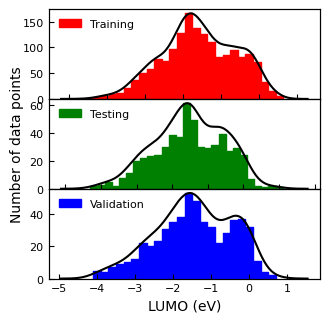

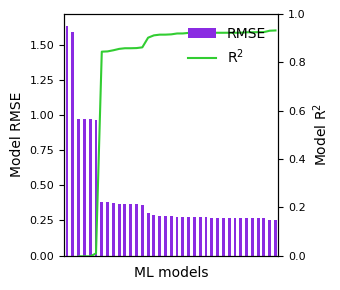

Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GaussianProcessRegressor                    -2.12      -1.84  1.64        0.42
KernelRidge                                 -1.94      -1.67  1.59        0.12
LassoLars                                   -0.10      -0.00  0.97        0.01
DummyRegressor                              -0.10      -0.00  0.97        0.01
Lasso                                       -0.10      -0.00  0.97        0.01
ElasticNet                                  -0.09       0.01  0.97        0.01
TweedieRegressor                             0.83       0.84  0.38        0.02
ExtraTreeRegressor                           0.83       0.85  0.38        0.05
DecisionTreeRegressor                        0.84       0.85  0.38        0.13
KNeighborsRegressor                          0.84       0.86  0.37        0.04
OrthogonalMatchingPursuitCV                  0.84       0.86  0.37        0.02
OrthogonalMatchingPursuit                    0.84       0.86  0.37        0.02
PassiveAggressiveRegressor                   0.84       0.86  0.37        0.02
AdaBoostRegressor                            0.85       0.86  0.36        0.59
BaggingRegressor                             0.89       0.90  0.30        0.76
LarsCV                                       0.90       0.91  0.29        0.07
RandomForestRegressor                        0.91       0.91  0.28        8.03
LinearSVR                                    0.91       0.91  0.28        0.22
ExtraTreesRegressor                          0.91       0.92  0.28        3.57
HuberRegressor                               0.91       0.92  0.28        0.08
SGDRegressor                                 0.91       0.92  0.28        0.02
LassoCV                                      0.91       0.92  0.27        0.23
LassoLarsCV                                  0.91       0.92  0.27        0.12
ElasticNetCV                                 0.91       0.92  0.27        0.23
BayesianRidge                                0.91       0.92  0.27        0.03
Ridge                                        0.91       0.92  0.27        0.03
LinearRegression                             0.91       0.92  0.27        0.03
TransformedTargetRegressor                   0.91       0.92  0.27        0.03
LassoLarsIC                                  0.91       0.92  0.27        0.04
RidgeCV                                      0.91       0.92  0.27        0.04
MLPRegressor                                 0.91       0.92  0.27        1.31
SVR                                          0.92       0.92  0.27        0.25
NuSVR                                        0.92       0.92  0.27        0.33
XGBRegressor                                 0.92       0.92  0.27        0.22
GradientBoostingRegressor                    0.92       0.93  0.27        2.05
HistGradientBoostingRegressor                0.92       0.93  0.26        1.24
LGBMRegressor                                0.93       0.93  0.25        0.12

In [99]:
%%capture --no-display

#random_seed = 50 # 126843 for not-reordered, no S
screen_ML_performance(df_prop)

### Look into a model

In [ ]:
# The order is: df_pnl_c4, df_pnl_c6, df_pnl_n4
use_index = [0,1,2] # loop which subsets
all_prop = []  
for i in use_index:
    X_prop = data_prop[i][0]
    Y_prop = data_prop[i][1]
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=4321)
    data = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
    all_prop.append( data )
    
df_prop = {}  ## All together 
for k in all_prop[0].keys():  ## loop x_train,xtest,...
    df = pd.concat( [ data[k] for data in all_prop ] ,axis=0 )
    df_prop[k] = df

fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,dpi=100)
#df_prop['y_val'].plot(kind='bar', stacked=False, x='type', y='LUMO', ax=axs)
sns.histplot(df_prop['y_train']['LUMO'],  kde=True, color='r', alpha=0.4, label='Training', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_test']['LUMO'],  kde=True, color='g', alpha=0.4, label='Testing', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_val']['LUMO'],   kde=True, color='b', alpha=0.4, label='Validating', binwidth=0.25, ax=axs)
axs.legend(fontsize=8, frameon=False)
plt.show()

colors = ['orange','m','g','b','c','r']
fig, axs = plt.subplots(1,3,figsize=(7,3.5),tight_layout=True,dpi=100)
sns.histplot(df_prop['y_train'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[0], x="LUMO", hue="diene_class", element="step", legend=True, multiple="stack")
sns.histplot(df_prop['y_test'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[1], x="LUMO", hue="diene_class", element="step", legend=False, multiple="stack")
sns.histplot(df_prop['y_val'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[2], x="LUMO", hue="diene_class", element="step", legend=False, multiple="stack")
legend = axs[0].get_legend()
handles = legend.legendHandles
#legend.remove()
axs[0].legend(handles, ['N=0, Aliphatic','N=0','N=1'], fontsize=8, frameon=False, loc=2)
for n in range(3):
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('')    
    #axs[n].set_xticks( [] )
    #axs[n].set_xlim((-4.9,2.5))
    axs[n].set_ylim(bottom=0)
    axs[n].tick_params(direction='in',labelsize=8)
    #axs[n].legend_.remove()
axs[1].set_xlabel('LUMO (eV)', fontsize=12)
axs[0].set_ylabel('Count', fontsize=12)
plt.show()

>1, train: 0.849, test: 0.839
>2, train: 0.915, test: 0.903
>3, train: 0.936, test: 0.919
>4, train: 0.953, test: 0.926
>5, train: 0.965, test: 0.928
>6, train: 0.971, test: 0.929
>7, train: 0.974, test: 0.932
>8, train: 0.977, test: 0.930
>9, train: 0.978, test: 0.929
>10, train: 0.980, test: 0.930
>11, train: 0.980, test: 0.929
>12, train: 0.981, test: 0.929
>13, train: 0.981, test: 0.929
>14, train: 0.981, test: 0.929
>15, train: 0.981, test: 0.930
>16, train: 0.981, test: 0.930
>17, train: 0.981, test: 0.930
>18, train: 0.981, test: 0.930
>19, train: 0.981, test: 0.930


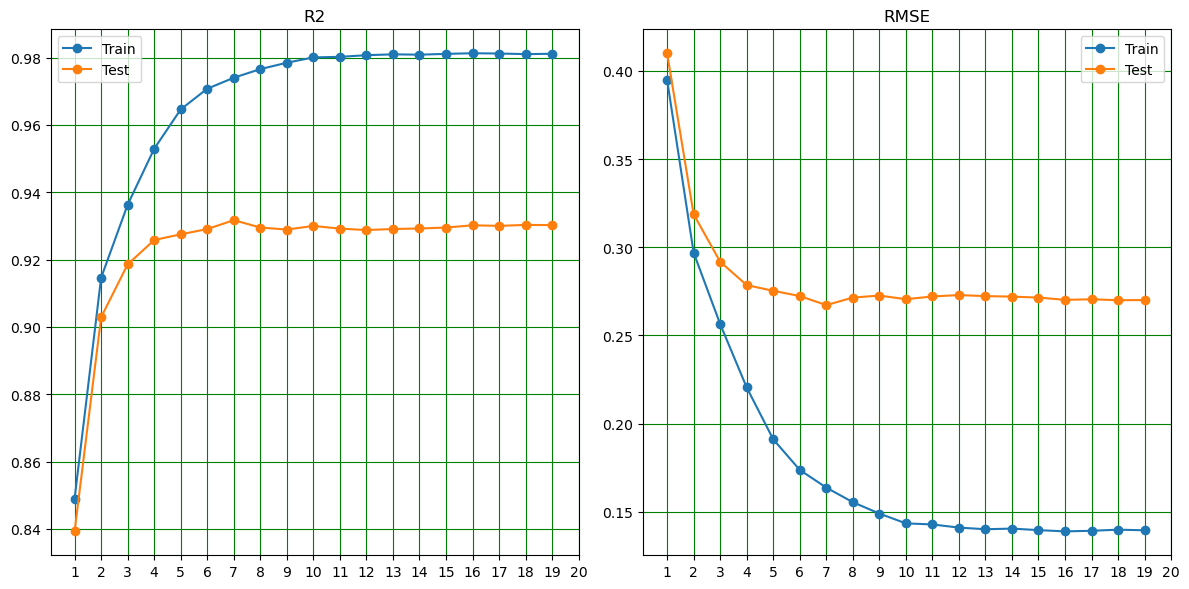

=============Done==============


In [22]:
import lightgbm as lgbm
know_any_depth(df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], model_algorithm=lgbm.LGBMRegressor, name='Prop', max_layer=20, vb=-1)

================ Info =================
>>>>>> Train set (1928, 32)
R square score:  0.9796882183757903
RMSE, MAE:  0.14483490006022628 0.11422358365906031
>>>>>> Test set (644, 32)
R square score:  0.9308710329910785
RMSE, MAE:  0.2688554134114663 0.21414601437294195


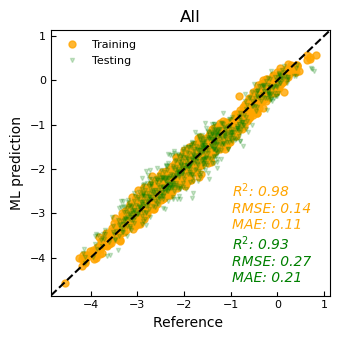

>>>>>> Val set (644,)
R square score:  0.9297965607385845
RMSE, MAE: 0.26743032600744976 0.21192853414199123


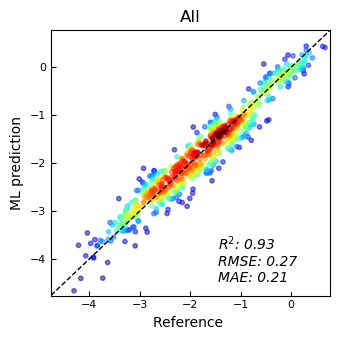

(0.93, 0.27, 0.21)

In [23]:
rf_nlayers = 12
model_all = model_any_fit(df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], 
                          model_algorithm=lgbm.LGBMRegressor, name='All',
                          ml_parameter={'num_leaves':30, 'max_depth':rf_nlayers, 'verbose': -1}
                         )
#model_all = model_any_fit(df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], model_algorithm=ExtraTreesRegressor, depth=rf_nlayers, vb=0, name='All' )

score_val( df_prop['x_val'], df_prop['y_val']['LUMO'],  model_all, name='All')

>1, train: 0.452, test: 0.447
>2, train: 0.710, test: 0.697
>3, train: 0.850, test: 0.837
>4, train: 0.915, test: 0.915
>5, train: 0.938, test: 0.937
>6, train: 0.954, test: 0.943
>7, train: 0.967, test: 0.950
>8, train: 0.977, test: 0.951
>9, train: 0.987, test: 0.954
>10, train: 0.992, test: 0.949
>11, train: 0.996, test: 0.954
>12, train: 0.998, test: 0.951
>13, train: 0.999, test: 0.951
>14, train: 1.000, test: 0.950
>15, train: 1.000, test: 0.951
>16, train: 1.000, test: 0.952
>17, train: 1.000, test: 0.951
>18, train: 1.000, test: 0.951
>19, train: 1.000, test: 0.953


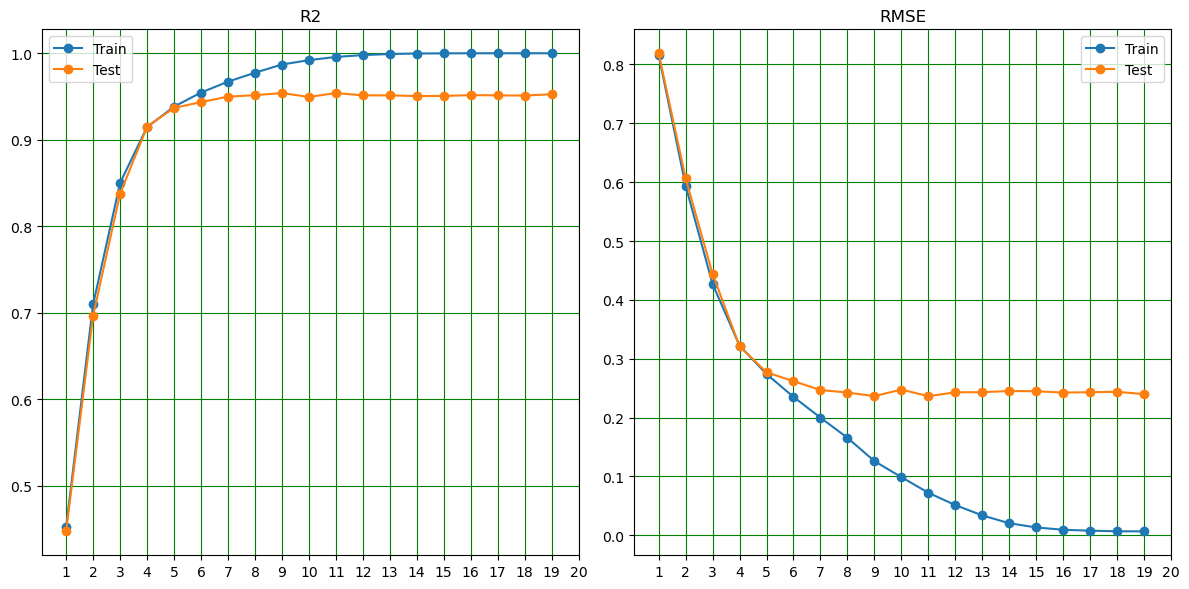

=============Done==============


In [51]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
know_any_depth(df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], model_algorithm=ExtraTreesRegressor, name='Prop', max_layer=20, vb=0)


================ Info =================
>>>>>> Train set (916, 41)
R square score:  0.9999248859972715
RMSE, MAE:  0.009555396935563365 0.0038929291955678296
>>>>>> Test set (308, 41)
R square score:  0.9525172635446109
RMSE, MAE:  0.24003742348071166 0.1811646356782757


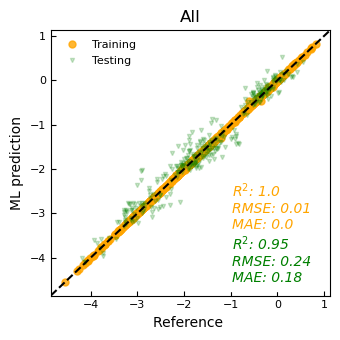

>>>>>> Val set (307,)
R square score:  0.9503123831793173
RMSE, MAE: 0.2515276140929949 0.18587101436566172


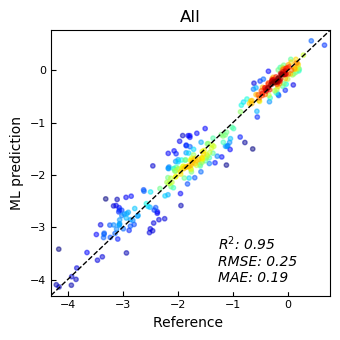

(0.95, 0.25, 0.19)

In [52]:
rf_nlayers = 16
model_all = model_any_fit(df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], 
                          model_algorithm=ExtraTreesRegressor, 
                          depth=rf_nlayers, vb=0, name='All' )

score_val( df_prop['x_val'], df_prop['y_val']['LUMO'],  model_all, name='All')

================ Info =================
>>>>>> Train set (897, 39)
R square score:  0.9310926121443973
RMSE, MAE:  0.27018432211068644 0.21829093870328553
>>>>>> Test set (301, 39)
R square score:  0.9336666394564967
RMSE, MAE:  0.2699563624857339 0.21846099122409285


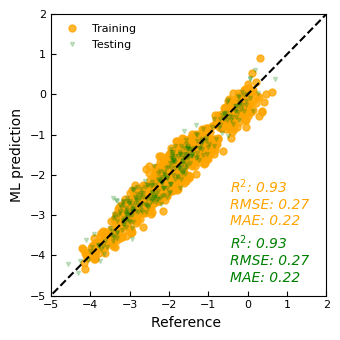

>>>>>> Val set (301,)
R square score:  0.9275630870002272
RMSE, MAE: 0.2713664618893846 0.21986572437062174


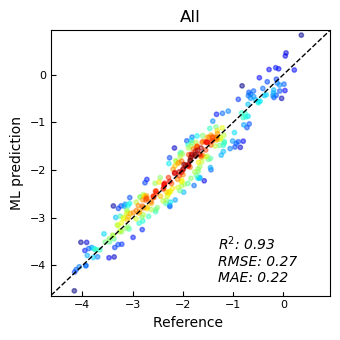

(0.93, 0.27, 0.22)

In [87]:
from sklearn.linear_model import LinearRegression

model_all = model_any_fit( df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], 
                          model_algorithm=LinearRegression,
                          name='', axs_lim=[-5,2], 
                          #depth=rf_nlayers,)
                         )#ml_parameter=parameter) 
score_val( df_prop['x_val'], df_prop['y_val']['LUMO'],  model_all, name='All')


### Finalize ML model, train and save

Train, Test, Val sizes are:  (987, 50) (330, 50) (329, 50)
Train, Test, Val sizes are:  (642, 50) (214, 50) (214, 50)
Train, Test, Val sizes are:  (37, 50) (13, 50) (13, 50)


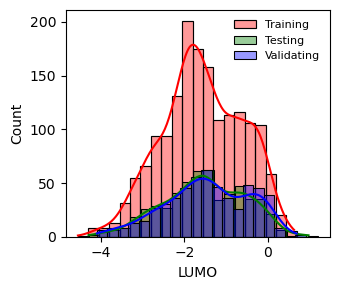

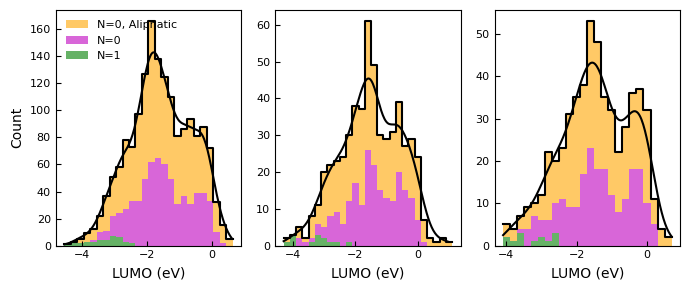

In [100]:
# The order is: df_pnl_c4, df_pnl_c6, df_pnl_n4
use_index = [0,1,2] # loop which subsets

all_prop = []  
for i in use_index:
    X_prop = data_prop[i][0]
    Y_prop = data_prop[i][1]
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=global_random_seed_number)
    data = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
    all_prop.append( data )
    
df_prop = {}  ## All together 
for k in all_prop[0].keys():  ## loop x_train,xtest,...
    df = pd.concat( [ data[k] for data in all_prop ] ,axis=0 )
    df_prop[k] = df

df_prop = standard_dataset(df_prop)

fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)
sns.histplot(df_prop['y_train']['LUMO'], kde=True, color='r', alpha=0.4, label='Training', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_test']['LUMO'],  kde=True, color='g', alpha=0.4, label='Testing', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_val']['LUMO'],   kde=True, color='b', alpha=0.4, label='Validating', binwidth=0.25, ax=axs)
axs.legend(fontsize=8, frameon=False)
#plt.savefig("spliting.png", dpi=800)      
plt.show()

colors = ['orange','m','g','b','c','r']
fig, axs = plt.subplots(1,3,figsize=(7,3),tight_layout=True,dpi=100)
bw = 0.2
sns.histplot(df_prop['y_train']['LUMO'], kde=True, color='k', alpha=1, binwidth=bw, ax=axs[0], legend=False, fill=False, element="step")
sns.histplot(df_prop['y_test']['LUMO'],  kde=True, color='k', alpha=1, binwidth=bw, ax=axs[1], legend=False, fill=False, element="step")
sns.histplot(df_prop['y_val']['LUMO'],   kde=True, color='k', alpha=1, binwidth=bw, ax=axs[2], legend=False, fill=False, element="step")

sns.histplot(df_prop['y_train'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=bw, ax=axs[0], x="LUMO", hue="diene_class", element="step", legend=True, multiple="stack")
sns.histplot(df_prop['y_test'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=bw, ax=axs[1], x="LUMO", hue="diene_class", element="step", legend=False, multiple="stack")
sns.histplot(df_prop['y_val'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=bw, ax=axs[2], x="LUMO", hue="diene_class", element="step", legend=False, multiple="stack")
legend = axs[0].get_legend()
handles = legend.legendHandles
#legend.remove()
axs[0].legend(handles, ['N=0, Aliphatic','N=0','N=1'], fontsize=8, frameon=False, loc=2)
tit = ['Training','Testing','Validating']
for n in range(3):
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('')    
    #axs[n].set_title( tit[n], fontsize=10)
    #axs[n].set_xlim((-4.9,2.5))
    #axs[n].set_ylim([0,250])
    axs[n].tick_params(direction='in',labelsize=8)
    axs[n].set_xlabel('LUMO (eV)', fontsize=10)
#axs[0].set_ylim([0,750])
axs[0].set_ylabel('Count', fontsize=10)

#plt.savefig("spliting_detail.png", dpi=800)      
plt.show()

#df_prop_std = standard_dataset(df_prop)
#df_prop = df_prop_std
#print( df_prop.keys() )

#print(rf_nlayers)
#model_all = model_any_fit( rf_nlayers, df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], model_algorithm=lgbm.LGBMRegressor, vb=-1, name='', savefig='TrainTesting.png', axs_lim=[-4.5,2.5] )
#score_val( df_prop['x_val'], df_prop['y_val']['LUMO'],  model_all, name='', savefig='Validating.png', axs_lim=[-4.5,2.5] )

In [101]:
%%capture --no-display
import lightgbm

# Hyper tuning
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'num_leaves': np.arange(20, 50),
    'max_depth': np.arange(4, 25),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
random_search = RandomizedSearchCV(estimator=lightgbm.LGBMRegressor(), param_distributions=param_dist, n_iter=100, cv=3, scoring='neg_mean_absolute_error', verbose=0)
#random_search.fit( df_prop['x_train'], df_prop['y_train']['LUMO'] )
df_x = pd.concat( [df_prop['x_train'],df_prop['x_test'],df_prop['x_val']], axis=0 )
df_y = pd.concat( [df_prop['y_train'],df_prop['y_test'],df_prop['y_val']], axis=0 )
random_search.fit( df_x, df_y['LUMO'] )

display("Best hyperparameters:")
parameter = random_search.best_params_
for k,v in parameter.items():
    display(k,v)
display("Best accuracy:", random_search.best_score_, )

model_all = random_search.best_estimator_
test_accuracy = model_all.score( df_prop['x_test'], df_prop['y_test']['LUMO'] )
display("Test accuracy:", test_accuracy)
val_accuracy = model_all.score( df_prop['x_val'], df_prop['y_val']['LUMO'] )
display("Validation accuracy:", val_accuracy)

'Best hyperparameters:'

'subsample'

1.0

'num_leaves'

30

'n_estimators'

300

'max_depth'

9

'learning_rate'

0.1

'colsample_bytree'

0.9

'Best accuracy:'

-0.20190388971577686

'Test accuracy:'

0.9942968532208131

'Validation accuracy:'

0.9949472759391939

================ Info =================
>>>>>> Train set (1928, 32)
R square score:  0.9805231663748466
RMSE, MAE:  0.14182682864993745 0.10986840038441475
>>>>>> Test set (644, 32)
R square score:  0.9339909464650579
RMSE, MAE:  0.26271840854209266 0.2082580856172282


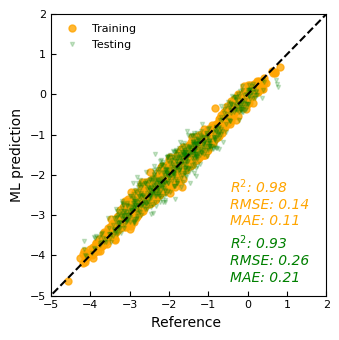

>>>>>> Val set (644,)
R square score:  0.9329719565782961
RMSE, MAE: 0.2613122266321941 0.20674240058342316


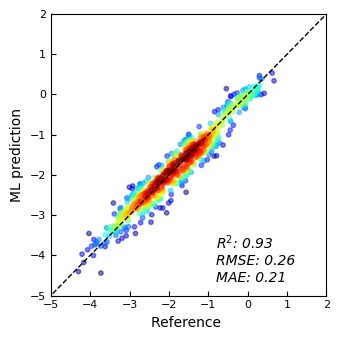

(0.93, 0.26, 0.21)

In [26]:
parameter['verbose']=-1
model_all = model_any_fit( df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], 
                          model_algorithm=lightgbm.LGBMRegressor, 
                          name='', savefig='TrainTesting.png', axs_lim=[-5,2], 
                          ml_parameter=parameter) 

score_val( df_prop['x_val'], df_prop['y_val']['LUMO'],  model_all, name='', savefig='Validating.png', axs_lim=[-5,2] )

================ Info =================
>>>>>> Train set (916, 41)
R square score:  0.999923512608391
RMSE, MAE:  0.009642356962647437 0.004238651770368947
>>>>>> Test set (308, 41)
R square score:  0.9496770825858044
RMSE, MAE:  0.24711208901192783 0.1832384326021267


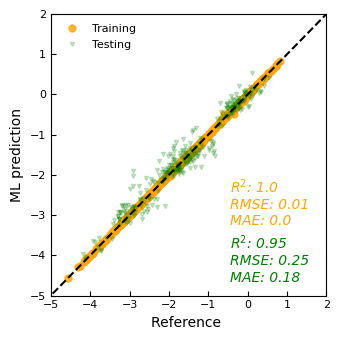

>>>>>> Val set (307,)
R square score:  0.9506121799105677
RMSE, MAE: 0.25076765365881654 0.18618343028841838


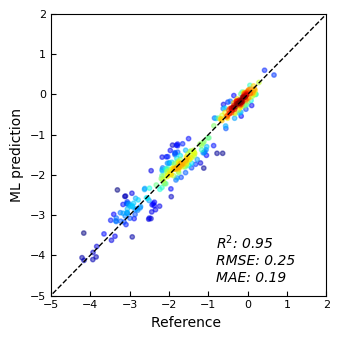

(0.95, 0.25, 0.19)

In [54]:
model_all = model_any_fit( df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], 
                          model_algorithm=ExtraTreesRegressor, vb=0, ## lightgbm.LGBMRegressor , ExtraTreesRegressor
                          name='', savefig='TrainTesting.png', axs_lim=[-5,2], 
                          depth=rf_nlayers,)
                          #ml_parameter=parameter) 

score_val( df_prop['x_val'], df_prop['y_val']['LUMO'],  model_all, name='', savefig='Validating.png', axs_lim=[-5,2] )

================ Info =================
>>>>>> Train set (897, 39)
R square score:  0.9310926121443973
RMSE, MAE:  0.27018432211068644 0.21829093870328553
>>>>>> Test set (301, 39)
R square score:  0.9336666394564967
RMSE, MAE:  0.2699563624857339 0.21846099122409285


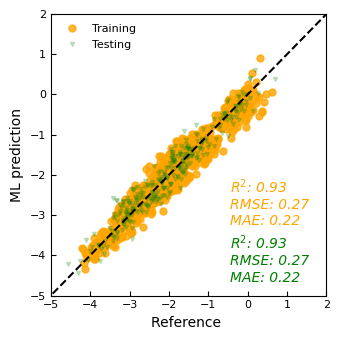

>>>>>> Val set (301,)
R square score:  0.9275630870002272
RMSE, MAE: 0.2713664618893846 0.21986572437062174


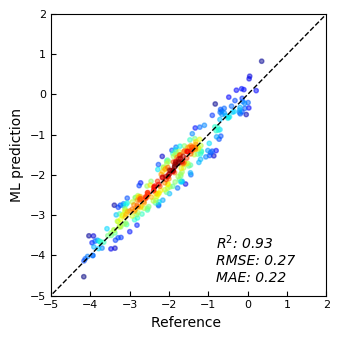

(0.93, 0.27, 0.22)

In [89]:
model_all = model_any_fit( df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], 
                          model_algorithm=LinearRegression,
                          name='', savefig='TrainTesting.png', axs_lim=[-5,2], 
                          #depth=rf_nlayers,)
                         )#ml_parameter=parameter) 

score_val( df_prop['x_val'], df_prop['y_val']['LUMO'],  model_all, name='', savefig='Validating.png', axs_lim=[-5,2] )

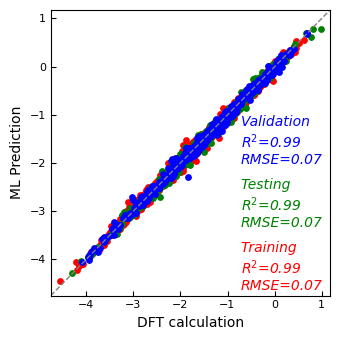

In [102]:
y_train_predict = model_all.predict(df_prop['x_train'].values)
y_test_predict = model_all.predict(df_prop['x_test'].values)
y_val_predict = model_all.predict(df_prop['x_val'].values)

train_score = model_all.score(df_prop['x_train'], df_prop['y_train']['LUMO'])
test_score = model_all.score(df_prop['x_test'], df_prop['y_test']['LUMO'])
val_score = model_all.score(df_prop['x_val'], df_prop['y_val']['LUMO'])

train_rmse = metrics.mean_squared_error(  df_prop['y_train']['LUMO'], y_train_predict, squared=False)
test_rmse = metrics.mean_squared_error(  df_prop['y_test']['LUMO'], y_test_predict, squared=False)
val_rmse = metrics.mean_squared_error(  df_prop['y_val']['LUMO'], y_val_predict, squared=False)

r2 = [train_score, test_score, val_score]
rmse = [train_rmse, test_rmse, val_rmse]

dx = [df_prop['y_train']['LUMO'].values, df_prop['y_test']['LUMO'].values, df_prop['y_val']['LUMO'].values]
dy = [y_train_predict, y_test_predict, y_val_predict]
colors = ['r','g','b']

fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,dpi=100)

axlim = [100000,-1000000]
for x,y,c in zip(dx,dy,colors):
    axs.scatter(x,y,  marker='o', c=c, s=15)  
    if np.amin([x,y])<axlim[0]:
        axlim[0] = np.amin([x,y])-0.2
    if np.amax([x,y])>axlim[1]:
        axlim[1] = np.amax([x,y])+0.2
axs.plot(axlim,axlim, '--', color='gray', lw=1)

axs.set_xlim(axlim)
axs.set_ylim(axlim)

#a, b = np.polyfit(our_exp_logs,[-2.68,-2.915,-3.075,-3.598], 1)
#axs.plot(df_plot['logS'], a*np.array(df_plot['logS'])+b, color='r', linestyle='--') 
axs.set_xlabel('DFT calculation',fontsize=10) ## input X name
axs.set_ylabel('ML Prediction',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

label = ['Training','Testing','Validation']
for n in range(3):
    line = f'{label[n]} \nR$^2$={round(r2[n],2)} \nRMSE={round(rmse[n],2)}'
    axs.text(0.68,0.02+0.22*n, line, style='italic', fontsize=10, transform = axs.transAxes, color=colors[n])

#plt.savefig('training.png', dpi=800)

plt.show()


>>>>>> Val set (329,)
R square score:  0.9976785045410683
RMSE, MAE: 0.06875028983325586 0.05262872326582655


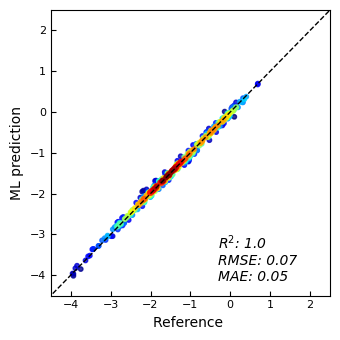

>>>>>> Val set (214,)
R square score:  0.9966830482176665
RMSE, MAE: 0.07558069606036218 0.05409789143360968


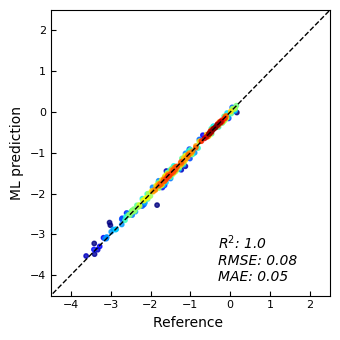

>>>>>> Val set (13,)
R square score:  0.9970953327059113
RMSE, MAE: 0.04386353558712478 0.03511684326880756


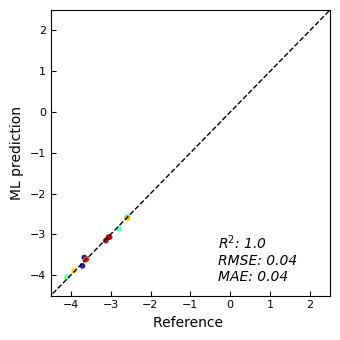

Dataset size   R2  RMSE  MAE
0           329 1.00  0.07 0.05
1           214 1.00  0.08 0.05
2            13 1.00  0.04 0.04

In [103]:
scaler_all = df_prop['scaler']

plot_together = []
for n in use_index:
    x = scaler_all.transform( all_prop[n]['x_val'] )
    r2,rmse,mae = score_val( x, all_prop[n]['y_val']['LUMO'],  model_all, name='', axs_lim=[-4.5,2.5], alpha=0.8, )#savefig=f'Validating_{n}.png')
    plot_together.append( [len(all_prop[n]['x_val']),r2,rmse,mae] )
plot_together = pd.DataFrame(plot_together, columns=['Dataset size','R2','RMSE','MAE'])
plot_together = plot_together.sort_values(by='Dataset size',ascending=False).reset_index(drop=True)

df_plot = plot_together.copy()
#df_plot = plot_together - plot_together.min()
#df_plot = df_plot/df_plot.max()
#df_plot += 0.1
display( plot_together,)# df_plot )


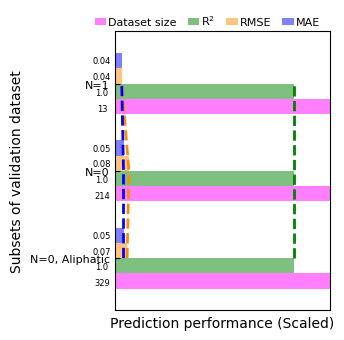

In [104]:
fig, axs = plt.subplots(1,1, figsize=(3.5,3.5),tight_layout=True)
#ax2 = axs.twinx()
colors = ['magenta','green','darkorange','b']
df_plot.plot(kind='barh', stacked=False, y=['Dataset size','R2','RMSE','MAE'], ax=axs, color=colors,
             width=0.7, alpha=0.5
            )

y = list( df_plot.index )
for i,(c,c1) in enumerate(zip(df_plot.columns,plot_together.columns)):
    axs.plot(df_plot[c],y, '--', color=colors[i], lw=2, alpha=1)
    num = [ str(s) for s in plot_together[c1]]
    for cx,cy,cm in zip(df_plot[c],y,num):
        axs.text(-0.07,cy+(i-1.55)*0.18,cm, ha='center', va='center', fontsize=6, color='k') # x=cx+0.1
    
axs.set_xlabel('Prediction performance (Scaled)',fontsize=10) ## input X name
axs.set_ylabel('Subsets of validation dataset',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8)
axs.set_yticklabels( ['N=0, Aliphatic','N=0','N=1'] )
axs.set_xlim([0,1.2])
axs.set_xticks( [] )

legend = axs.get_legend()
handles = legend.legendHandles
#legend.remove()
axs.legend(handles, ['Dataset size',r'R$^2$','RMSE','MAE'], fontsize=8, frameon=False, loc=0, ncol=4,
          bbox_to_anchor=(1,1.1), handlelength=1, handletextpad=0.2, columnspacing=1
          )
#plt.savefig("Validating_BreakDown.png", dpi=800)      
plt.show()

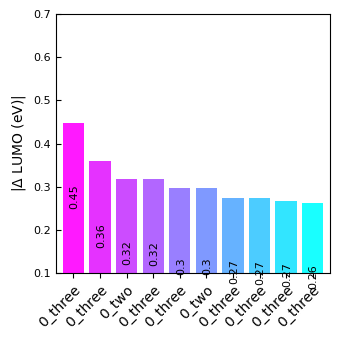

In [105]:
error_bar = pd.DataFrame()
labels = []

df_sr = y_train_predict - df_prop['y_train']['LUMO']
error_bar = pd.concat( [error_bar,df_sr.to_frame()], axis=0 )
labels += list(df_prop['y_train']['diene_type'])

df_sr = y_test_predict - df_prop['y_test']['LUMO']
error_bar = pd.concat( [error_bar,df_sr.to_frame()], axis=0 )
labels += list(df_prop['y_test']['diene_type'])

df_sr = y_val_predict - df_prop['y_val']['LUMO']
error_bar = pd.concat( [error_bar,df_sr.to_frame()], axis=0 )
labels += list(df_prop['y_val']['diene_type'])

error_bar = error_bar.abs().sort_values(by='LUMO', ascending=False)

df_plot = error_bar.head(10)
labels = labels[:10]

#labels = list( df_plot.index.str.capitalize() )
#labels[-1] = 'Others'
fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,dpi=100)
#colors = ['magenta','green','darkorange','b','r']
cmap = plt.get_cmap('cool')
colors = cmap(np.linspace(1, 0, 10))

bars = df_plot.plot(kind='bar', stacked=False, y=['LUMO'], ax=axs, #xlabel=labels, #color=colors,
             width=0.8, alpha=0.9)
#for ii,container in enumerate(axs.containers):
#    container.datavalues[0]=-1
#    axs.bar_label(container, rotation=90, fontsize=8, padding=-30 ) #label_type='center')
for n,rect in enumerate(axs.patches):
    x = rect.get_x()
    y = rect.get_height()
    rect.set_fc( colors[n] )
    axs.text(x+0.25,y-0.2,str(round(y,2)), ha='left', va='bottom', fontsize=8, color='k', rotation=90) # x=cx+0.1
    
axs.set_xlabel(None,fontsize=10) ## input X name
axs.set_ylabel(r'|$\Delta$ LUMO (eV)|' ,fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8, axis='y')
axs.set_xticklabels( labels, rotation=45, fontsize=10, ha='right', rotation_mode='anchor')
axs.set_ylim([0.1,0.7])
#axs.set_xticks( [] )
axs.legend().set_visible(False) #labels=['Aliphatic']+ring_names, fontsize=8, frameon=False, ncol=2, handlelength=1, handletextpad=0.2, columnspacing=1)
#plt.yscale('log')

#plt.savefig("ErrorBar.png", dpi=800)  
plt.show()

In [106]:
fp_name_prop = list( df_prop['x_train'].columns )
print( fp_name_prop )

scaler_all = df_prop['scaler']
print( scaler_all )

['rdk_MaxEStateIndex', 'rdk_MinAbsEStateIndex', 'rdk_FpDensityMorgan1', 'rdk_FpDensityMorgan3', 'rdk_BalabanJ', 'rdk_BertzCT', 'rdk_Chi2n', 'rdk_Chi3v', 'rdk_HallKierAlpha', 'rdk_Kappa3', 'rdk_PEOE_VSA1', 'rdk_PEOE_VSA10', 'rdk_PEOE_VSA11', 'rdk_PEOE_VSA12', 'rdk_PEOE_VSA13', 'rdk_PEOE_VSA14', 'rdk_PEOE_VSA2', 'rdk_PEOE_VSA6', 'rdk_PEOE_VSA7', 'rdk_PEOE_VSA8', 'rdk_PEOE_VSA9', 'rdk_SMR_VSA1', 'rdk_SMR_VSA10', 'rdk_SMR_VSA2', 'rdk_SMR_VSA3', 'rdk_SMR_VSA6', 'rdk_SMR_VSA7', 'rdk_SlogP_VSA10', 'rdk_SlogP_VSA11', 'rdk_SlogP_VSA12', 'rdk_SlogP_VSA2', 'rdk_EState_VSA2', 'rdk_EState_VSA3', 'rdk_EState_VSA4', 'rdk_EState_VSA5', 'rdk_EState_VSA6', 'rdk_EState_VSA7', 'rdk_EState_VSA8', 'rdk_EState_VSA9', 'rdk_VSA_EState10', 'rdk_VSA_EState2', 'rdk_VSA_EState3', 'rdk_VSA_EState4', 'rdk_VSA_EState7', 'rdk_VSA_EState8', 'rdk_NHOHCount', 'rdk_NumHeteroatoms', 'rdk_NumRotatableBonds', 'rdk_MolLogP', 'COS']
StandardScaler()


In [107]:
import joblib
import json

file_model = 'model_final.pkl'
joblib.dump(model_all, file_model)

file_scaler = f'scaler_final.pkl'
joblib.dump(scaler_all, file_scaler)

file_feature='feature_final.json'
with open(file_feature, 'w') as f1:
    json.dump(fp_name_prop, f1, indent=4)
    

## BACKUP script in case

In [ ]:
plt.figure(figsize=(4,3))
my_color = ['orangered','limegreen','cyan','royalblue','blueviolet','hotpink']

ndata = len(df_final['source'].value_counts())
fig, axs = plt.subplots(1,ndata+1, figsize=(4*(ndata+1),3), tight_layout=True)
axs[0].set_title('All')
for n,i in enumerate( df_final['source'].value_counts().index ):
    data = df_final[ df_final['source']==i ]['LUMO']
    print( len(data), ' data in' , i)
    sns.histplot( data=data, ax=axs[0], kde=False, binwidth=0.5, color=my_color[n])
    sns.histplot( data=data, ax=axs[n+1], kde=False, binwidth=0.5) 
    axs[n+1].set_title(i)
plt.show()

In [19]:
def has_substructure(smi, sub_struct=None):
    if sub_struct is None:
        sub_struct = ['C=CC=C']
    mol = Chem.MolFromSmiles(smi) 
    if mol is None:
        match = False
    else:
        mol = Chem.RemoveHs( mol )
        Chem.Kekulize(mol)
        if any([mol.HasSubstructMatch( Chem.MolFromSmiles(s) ) for s in sub_struct]):
            match = True
        else:
            match = False
    return match

def has_radical(smi):
    contains_radical = False
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        contains_radical = True
    else:
        if any([True if atom.GetNumRadicalElectrons()>0 else False for atom in mol.GetAtoms() ]):
            contains_radical = True
        
    return contains_radical

def has_diene_pattern(df, pattern='C=CC=C', smiles_col='SMILES'):
    new_col = 'SMILES_pattern_'+pattern
    match_smi = [ has_substructure(s, sub_struct=[pattern]) for s in df[smiles_col] ]
    df[new_col] = match_smi
    display( 'Match results: ', pattern, np.sum(match_smi) )

In [ ]:
df_pnl = pd.read_csv('df_final_pnl_cccc.csv', index_col=0)
df_qm9 = pd.read_csv('df_final_qm9_cccc.csv', index_col=0)
df_qm9_N = pd.read_csv('df_final_qm9_n_diene.csv', index_col=0)

df_qm9_N_1 = df_qm9_N[df_qm9_N['diene_types']==1]
df_qm9_N_2 = df_qm9_N[df_qm9_N['diene_types']==2]
df_qm9_N_3 = df_qm9_N[df_qm9_N['diene_types']==3]
df_qm9_N_4 = df_qm9_N[df_qm9_N['diene_types']==4]

display('Read: ', df_pnl.shape, df_qm9.shape, df_qm9_N_1.shape, df_qm9_N_2.shape, df_qm9_N_3.shape, df_qm9_N_4.shape)

feature_col = ['LUMO'] + [c for c in df_qm9_N.columns if 'rdk_' in c ] #or 'RingCount_' in c ]   
df_pnl =df_pnl[feature_col]
df_qm9 =df_qm9[feature_col]
df_qm9_N_1 =df_qm9_N_1[feature_col]
df_qm9_N_2 =df_qm9_N_2[feature_col]
df_qm9_N_3 =df_qm9_N_3[feature_col]
df_qm9_N_4 =df_qm9_N_4[feature_col]

df_final = pd.concat( [df_pnl, df_qm9, df_qm9_N_1, df_qm9_N_2, df_qm9_N_3, df_qm9_N_4],axis=0 )
df_final.drop_duplicates()


feature_col = [c for c in df_final.columns if 'rdk_' in c ]
X_features = df_final[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, _= remove_high_corr_gradually(X_features, cutoff=0.8 )
feature_col = list( X_features_prop_clean.columns )

feature_col = ['LUMO'] + feature_col
df_pnl =df_pnl[feature_col]
df_qm9 =df_qm9[feature_col]
df_qm9_N_1 =df_qm9_N_1[feature_col]
df_qm9_N_2 =df_qm9_N_2[feature_col]
df_qm9_N_3 =df_qm9_N_3[feature_col]
df_qm9_N_4 =df_qm9_N_4[feature_col]

df_pnl['type']= -1
df_qm9['type']=0
df_qm9_N_1['type']=1
df_qm9_N_2['type']=2
df_qm9_N_3['type']=3
df_qm9_N_4['type']=4

display('Final: ', df_pnl.shape, df_qm9.shape, df_qm9_N_1.shape, df_qm9_N_2.shape, df_qm9_N_3.shape, df_qm9_N_4.shape)

data_prop = []
for df in [df_pnl, df_qm9, df_qm9_N_1, df_qm9_N_2, df_qm9_N_3, df_qm9_N_4]:
    Y_prop = df[['LUMO','type']]
    X_prop = df.drop(['LUMO','type'],axis=1)
    data_prop.append( [X_prop,Y_prop] )
    

corr_matx = df_final.corr()
corr_matx['type'][ corr_matx['type'].abs()>0.8 ]
see_correlation( df_final, xlabel='rdk_SMR_VSA3', ylabel='type', color='r')

# Screening using ML

In [108]:
import joblib
import json

model_all = joblib.load('model_final.pkl')
scaler_all = joblib.load('scaler_final.pkl')
with open('feature_final.json', 'r') as f1:
    fp_name_prop = json.load(f1)

In [109]:
## Make prdiction on  new data point
### pubchem, rdkprop, padelpy
from padelpy import from_smiles

def predict_padelpy(smi, fp_name, model, output_padelpy_descriptor=False, output_pubchem_fingerprint=True):
    """
    The default is to output pubchem fp and not padel descriptor
    """
    fp = from_smiles(smi, 
                     fingerprints=output_pubchem_fingerprint, 
                     descriptors=output_padelpy_descriptor
                    )
    if isinstance(smi, list):
        fp_col = list(fp[0].keys())
        fp_data = [list(f.values()) for f in fp ]
        df_fps = pd.DataFrame( data=fp_data, columns=fp_col )
    elif isinstance(smi, str):
        fp_col = list(fp.keys())
        fp_data = list(fp.values())
        df_fps = pd.DataFrame( data=[fp_data], columns=fp_col )
    df_fps = df_fps[fp_name]
    predict_new = model.predict(df_fps)
    return predict_new

from tqdm import tqdm
from time import sleep

def predict_rdk_prop(smi, fp_full_name, model, scaler=None, fp_calc=None):
    """
    smi: diene SMILES 
    fp_calc: the calculator 
    fp_name: the final fingerprint list for ML 
    model: trained model
    """
    fp_name = [ f.replace('rdk_','') for f in fp_full_name]
    if fp_calc==None:
        fp_calc = MoleculeDescriptors.MolecularDescriptorCalculator(fp_name)
    if isinstance(smi, list):
        fp_molecule = []
        for n, (i,s) in enumerate(zip( tqdm(range(len(smi))), smi )):
            if n%int(len(smi)/10)==0:
                display( f'{n} out of {len(smi)}' )
            #display( sleep(0.000000001) )
            fp = list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) )
            fp_molecule.append(fp)
        #fp_molecule = [list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) ) for s in smi]
        new_df = pd.DataFrame( data=fp_molecule, columns=fp_full_name )
        if scaler is not None:
            new_df = scaler.transform(new_df)
        predict_new = model.predict(new_df)
    else:
        print('Error')
    return predict_new

def locate_func( smi, pattern='C=CC=C', pattern_ngb=[1,2,2,1] ):
    """
    return a dict: key=location, value=functionl groups
    """
    pattern = Chem.MolFromSmiles(pattern)
    mol = Chem.MolFromSmiles(smi)
    #display(mol)
    #display( mol_with_atom_index(mol) )
    atoms_in_diene = mol.GetSubstructMatches(pattern)[0]
    bonds = [ mol.GetAtomWithIdx(at).GetBonds() for at in atoms_in_diene ]
    output = {}
    dummy_atom = Chem.Atom(82)
    for ii,(at,bond,patt) in enumerate(zip(atoms_in_diene,bonds,pattern_ngb)):
        if len(bond)>patt: ## There is a func here
            func_bond = [b for b in bond if b.GetBeginAtom().GetIdx() not in atoms_in_diene or b.GetEndAtom().GetIdx() not in atoms_in_diene]
            func_bond = [ b.GetIdx() for b in func_bond]
            mol_fragments = Chem.FragmentOnBonds( mol, func_bond , addDummies=True , dummyLabels=[(0,0) for b in func_bond] )
            mol_fragments = Chem.RWMol(mol_fragments)            
            mol_fragments.ReplaceAtom(at, dummy_atom)
            mol_fragments = Chem.GetMolFrags(mol_fragments, asMols=True)
            mol_fragments = [ fragment for fragment in mol_fragments if not any(a.GetSymbol()=='Pb' for a in fragment.GetAtoms()) ]

            mol_fragments = [ Chem.MolToSmiles(m, canonical=True, isomericSmiles=True) for m in mol_fragments]
            output[ii] = mol_fragments
    return output

# The PNL diene

In [110]:
df_prediction = pd.read_csv('df_prediction.csv', index_col=0)
df_hybrid = pd.read_csv('df_hybrid.csv', index_col=0)
df_parameterization = pd.read_csv('df_parameterization.csv', index_col=0)
#display(df_prediction, df_hybrid, df_parameterization) 

In [111]:
%%capture --no-display

prediction1 = predict_rdk_prop( list(df_prediction.index), fp_name_prop, model_all, scaler=scaler_all)
df_prediction['LUMO_predicted'] = prediction1
df_prediction = df_prediction.sort_values(by='LUMO_predicted',ascending=True)
#df_qm9.to_csv('Old_all_dienes_PredLUMO.csv')

df_prediction = df_prediction[['LUMO','diene_type','LUMO_predicted']]
df_prediction

'0 out of 3060'

'306 out of 3060'

'612 out of 3060'

'918 out of 3060'

'1224 out of 3060'

'1530 out of 3060'

'1836 out of 3060'

'2142 out of 3060'

'2448 out of 3060'

'2754 out of 3060'

LUMO diene_type  \
[H]C(=O)/C([H])=C(C#N)/C([H])=C(\[H])C([H])=O      -4.12    0_three   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                 -4.26    0_three   
[H]OC(=O)/C(C#N)=C([H])\C([H])=C(/[H])C([H])=O     -3.88    0_three   
[H]OC(=O)/C([H])=C(\[H])C([H])=C(C#N)C#N           -3.91    0_three   
[H]C(=O)/C(C#N)=C(\C#N)C([H])=C([H])[H]            -4.16    0_three   
...                                                  ...        ...   
[H]C(/C([H])=C(/N([H])[H])C([H])([H])[H])=C(/[H...  0.72    0_three   
[H]/C(=C(C(\[H])=C(/[H])N(C([H])([H])[H])C([H])...  0.41    0_three   
[H]O/C(=C([H])\C([H])=C(/[H])N([H])[H])N([H])[H]    0.29    0_three   
[H]C(=C(\N([H])[H])N(C([H])([H])[H])C([H])([H])...  0.40    0_three   
[H]C(=C(N([H])[H])N([H])[H])/C([H])=C(\[H])N(C(...  0.62    0_three   

                                                    LUMO_predicted  
[H]C(=O)/C([H])=C(C#N)/C([H])=C(\[H])C([H])=O                -4.13  
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                           -4.09  
[H]OC(=O)/C(C#N)=C([H])\C([H])=C(/[H])C([H])=O               -4.01  
[H]OC(=O)/C([H])=C(\[H])C([H])=C(C#N)C#N                     -3.96  
[H]C(=O)/C(C#N)=C(\C#N)C([H])=C([H])[H]                      -3.95  
...                                                            ...  
[H]C(/C([H])=C(/N([H])[H])C([H])([H])[H])=C(/[H...            0.30  
[H]/C(=C(C(\[H])=C(/[H])N(C([H])([H])[H])C([H])...            0.32  
[H]O/C(=C([H])\C([H])=C(/[H])N([H])[H])N([H])[H]              0.35  
[H]C(=C(\N([H])[H])N(C([H])([H])[H])C([H])([H])...            0.37  
[H]C(=C(N([H])[H])N([H])[H])/C([H])=C(\[H])N(C(...            0.41  

[3060 rows x 3 columns]

In [112]:
%%capture --no-display

if len(df_hybrid)>0:
    prediction1 = predict_rdk_prop( list(df_hybrid.index), fp_name_prop, model_all, scaler=scaler_all)
    df_hybrid['LUMO_predicted'] = prediction1
    df_hybrid = df_hybrid.sort_values(by='LUMO_predicted',ascending=True)

    df_hybrid = df_hybrid[['LUMO','diene_type','LUMO_predicted']]
    df_hybrid

In [113]:
%%capture --no-display

prediction1 = predict_rdk_prop( list(df_parameterization.index), fp_name_prop, model_all, scaler=scaler_all)
df_parameterization['LUMO_predicted'] = prediction1
df_parameterization = df_parameterization.sort_values(by='LUMO_predicted',ascending=True)
#df_qm9.to_csv('Old_all_dienes_PredLUMO.csv')

df_parameterization = df_parameterization[['LUMO','diene_type','LUMO_predicted']]
df_parameterization

'0 out of 2779'

'277 out of 2779'

'554 out of 2779'

'831 out of 2779'

'1108 out of 2779'

'1385 out of 2779'

'1662 out of 2779'

'1939 out of 2779'

'2216 out of 2779'

'2493 out of 2779'

'2770 out of 2779'

LUMO diene_type  \
N#Cc1nnc(C#N)nn1                                   -4.55      2_two   
[H]C(=O)c1nnc(C#N)nn1                              -4.30      2_two   
[H]O[S@+]([O-])c1nnc(C#N)nn1                       -4.19      2_two   
[H]C(=O)/C([H])=C([H])/C([H])=C(\C#N)C([H])=O      -4.06    0_three   
[H]C(=O)/C(C#N)=C([H])\C([H])=C(/[H])C#N           -4.12    0_three   
...                                                  ...        ...   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  0.69      0_two   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...  0.77    0_three   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  0.98    0_three   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     0.83      0_two   
[H]C(=C(N([H])[H])N([H])[H])/C([H])=C(\[H])N([H...  0.67    0_three   

                                                    LUMO_predicted  
N#Cc1nnc(C#N)nn1                                             -4.45  
[H]C(=O)c1nnc(C#N)nn1                                        -4.27  
[H]O[S@+]([O-])c1nnc(C#N)nn1                                 -4.21  
[H]C(=O)/C([H])=C([H])/C([H])=C(\C#N)C([H])=O                -4.11  
[H]C(=O)/C(C#N)=C([H])\C([H])=C(/[H])C#N                     -4.11  
...                                                            ...  
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...            0.40  
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...            0.42  
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...            0.44  
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]               0.46  
[H]C(=C(N([H])[H])N([H])[H])/C([H])=C(\[H])N([H...            0.51  

[2779 rows x 3 columns]

>>>>>> Val set (13, 3)
Pearsons correlation: 0.964
R square score:  0.917999253183211
RMSE, MAE: 0.26479051880049287 0.20763210024432094


Text(0.6, 0.05, 'R$^2$: 0.92\nRMSE: 0.26\nMAE: 0.21')

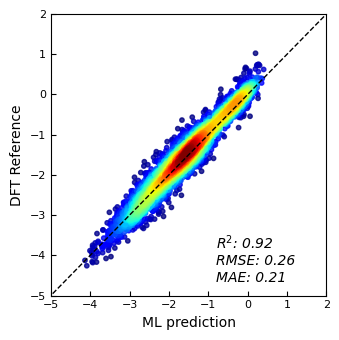

In [114]:
#sns.scatterplot(data=df_old, x=, y=)
fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True )#,dpi=100)

y,x = df_prediction["LUMO"], df_prediction["LUMO_predicted"]
x,y,z = color_density(x,y)

#z = plt.cm.jet(z)            
a, b = np.polyfit(x, y, 1)
#x = a*x + b
im = axs.scatter(x, y, marker='o', c=z, cmap='jet', label='Validating', alpha=0.8, s=10)     

axs.plot([-100,100], [-100,100], '--', color='k', lw=1)



corr, _ = stats.pearsonr( x, y )
r2_val = metrics.r2_score(x, y)
rmse_val = np.sqrt(metrics.mean_squared_error(x, y))    
mae_val = metrics.mean_absolute_error(x, y)
print(">>>>>> Val set", y_val.shape)
print('Pearsons correlation: %.3f' % corr)
print("R square score: " , r2_val)
print("RMSE, MAE:", rmse_val, mae_val)

ax_min = np.amin([np.amin(x), np.amin(y)])-0.1
ax_max = np.amax([np.amax(x), np.amax(y)])+0.1
ax_min,ax_max = -5,2
axs.set_xlim((ax_min,ax_max))
axs.set_ylim((ax_min,ax_max))
    
axs.set_ylabel('DFT Reference',fontsize=10) ## input X name
axs.set_xlabel('ML prediction',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8)

r2_val, rmse_val, mae_val = np.round([r2_val, rmse_val, mae_val], 2)
performance = f'R$^2$: {r2_val}\nRMSE: {rmse_val}\nMAE: {mae_val}'
axs.text(0.6,0.05, performance, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white', color='k')
    
#axs.legend(fontsize=8, frameon=False,)
#plt.savefig(savefig, dpi=800) 

In [ ]:
#sns.scatterplot(data=df_old, x=, y=)
fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True )#,dpi=100)

y,x = df_hybrid["LUMO"], df_hybrid["LUMO_predicted"]
x,y,z = color_density(x,y)

#z = plt.cm.jet(z)            
a, b = np.polyfit(x, y, 1)
#x = a*x + b
im = axs.scatter(x, y, marker='o', c=z, cmap='jet', label='Validating', alpha=0.8, s=10)     

axs.plot([-100,100], [-100,100], '--', color='k', lw=1)

r2_val = metrics.r2_score(x, y)
rmse_val = np.sqrt(metrics.mean_squared_error(x, y))    
mae_val = metrics.mean_absolute_error(x, y)
print(">>>>>> Val set", y_val.shape)
print("R square score: " , r2_val)
print("RMSE, MAE:", rmse_val, mae_val)

ax_min = np.amin([np.amin(x), np.amin(y)])-0.1
ax_max = np.amax([np.amax(x), np.amax(y)])+0.1
ax_min,ax_max = -5,2
axs.set_xlim((ax_min,ax_max))
axs.set_ylim((ax_min,ax_max))
    
axs.set_ylabel('DFT Reference',fontsize=10) ## input X name
axs.set_xlabel('ML prediction',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8)

r2_val, rmse_val, mae_val = np.round([r2_val, rmse_val, mae_val], 2)
performance = f'R$^2$: {r2_val}\nRMSE: {rmse_val}\nMAE: {mae_val}'
axs.text(0.6,0.05, performance, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white', color='k')
    
#axs.legend(fontsize=8, frameon=False,)
#plt.savefig(savefig, dpi=800) 

>>>>>> Val set (13, 3)
R square score:  0.9842382538792285
RMSE, MAE: 0.11863712042004193 0.09269426739269597


Text(0.6, 0.05, 'R$^2$: 0.98\nRMSE: 0.12\nMAE: 0.09')

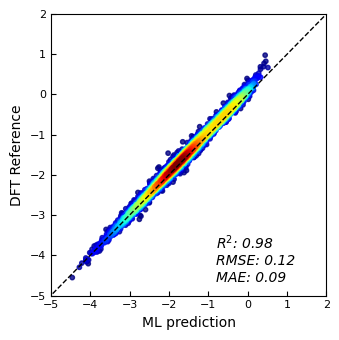

In [115]:
#sns.scatterplot(data=df_old, x=, y=)
fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True )#,dpi=100)

y,x = df_parameterization["LUMO"], df_parameterization["LUMO_predicted"]
x,y,z = color_density(x,y)

#z = plt.cm.jet(z)            
a, b = np.polyfit(x, y, 1)
#x = a*x + b
im = axs.scatter(x, y, marker='o', c=z, cmap='jet', label='Validating', alpha=0.8, s=10)     

axs.plot([-100,100], [-100,100], '--', color='k', lw=1)

r2_val = metrics.r2_score(x, y)
rmse_val = np.sqrt(metrics.mean_squared_error(x, y))    
mae_val = metrics.mean_absolute_error(x, y)
print(">>>>>> Val set", y_val.shape)
print("R square score: " , r2_val)
print("RMSE, MAE:", rmse_val, mae_val)

ax_min = np.amin([np.amin(x), np.amin(y)])-0.1
ax_max = np.amax([np.amax(x), np.amax(y)])+0.1
ax_min,ax_max = -5,2
axs.set_xlim((ax_min,ax_max))
axs.set_ylim((ax_min,ax_max))
    
axs.set_ylabel('DFT Reference',fontsize=10) ## input X name
axs.set_xlabel('ML prediction',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8)

r2_val, rmse_val, mae_val = np.round([r2_val, rmse_val, mae_val], 2)
performance = f'R$^2$: {r2_val}\nRMSE: {rmse_val}\nMAE: {mae_val}'
axs.text(0.6,0.05, performance, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white', color='k')
    
#axs.legend(fontsize=8, frameon=False,)
#plt.savefig(savefig, dpi=800) 

In [ ]:
#sns.scatterplot(data=df_old, x=, y=)
fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True )#,dpi=100)

y = list(df_prediction["LUMO"]) + list(df_parameterization["LUMO"])
x = list(df_prediction["LUMO_predicted"]) + list(df_parameterization["LUMO_predicted"])

x,y,z = color_density(x,y)

#z = plt.cm.jet(z)            
a, b = np.polyfit(x, y, 1)
#x = a*x + b
im = axs.scatter(x, y, marker='o', c=z, cmap='jet', label='Validating', alpha=0.8, s=10)     

axs.plot([-100,100], [-100,100], '--', color='k', lw=1)

r2_val = metrics.r2_score(x, y)
rmse_val = np.sqrt(metrics.mean_squared_error(x, y))    
mae_val = metrics.mean_absolute_error(x, y)
print(">>>>>> Val set", y_val.shape)
print("R square score: " , r2_val)
print("RMSE, MAE:", rmse_val, mae_val)

ax_min = np.amin([np.amin(x), np.amin(y)])-0.1
ax_max = np.amax([np.amax(x), np.amax(y)])+0.1
axs.set_xlim((ax_min,ax_max))
axs.set_ylim((ax_min,ax_max))
    
axs.set_ylabel('DFT Reference',fontsize=10) ## input X name
axs.set_xlabel('ML prediction',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8)

r2_val, rmse_val, mae_val = np.round([r2_val, rmse_val, mae_val], 2)
performance = f'R$^2$: {r2_val}\nRMSE: {rmse_val}\nMAE: {mae_val}'
axs.text(0.6,0.05, performance, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white', color='k')
    
#axs.legend(fontsize=8, frameon=False,)
#plt.savefig(savefig, dpi=800) 

In [116]:
err = df_prediction["LUMO"]-df_prediction["LUMO_predicted"]
df_prediction['err'] = err.abs() 
df = df_prediction.sort_values(by=['err'], ascending=False)
df

LUMO diene_type  \
[H]OC(=O)/C(O[H])=C(/[H])C(OC([H])([H])[H])=C([... -0.64    0_three   
[H]C(=O)C1=C([H])C([H])([H])C([H])([H])C(N([H])... -1.67    1_three   
[H]C(=O)/C(C([H])=C([H])[H])=C(\OC([H])([H])[H]... -0.85    0_three   
[H]O[S@+]([O-])/C(C(C#N)=C([H])[H])=C(/[H])N(C(... -1.42    0_three   
[H]OC(=O)/C([H])=C(/C#N)C(=C([H])[H])N([H])[H]     -3.03    0_three   
...                                                  ...        ...   
[H]C([H])=C(/C(C#N)=C(/[H])SC([H])([H])[H])N([H... -1.75    0_three   
[H]O[S@+]([O-])/C(C([H])=C([H])[H])=C(\C([H])=O... -2.45    0_three   
[H]C1=C(N(C([H])([H])[H])C([H])([H])[H])C([H])(... -0.74    1_three   
[H]C1=C(N(C([H])([H])[H])C([H])([H])[H])C([H])(... -0.80    1_three   
[H]C(=O)C1=C(OC([H])([H])[H])C(SC([H])([H])[H])... -2.11    1_three   

                                                    LUMO_predicted  err  
[H]OC(=O)/C(O[H])=C(/[H])C(OC([H])([H])[H])=C([...           -1.67 1.03  
[H]C(=O)C1=C([H])C([H])([H])C([H])([H])C(N([H])...           -2.62 0.95  
[H]C(=O)/C(C([H])=C([H])[H])=C(\OC([H])([H])[H]...           -1.77 0.92  
[H]O[S@+]([O-])/C(C(C#N)=C([H])[H])=C(/[H])N(C(...           -2.32 0.90  
[H]OC(=O)/C([H])=C(/C#N)C(=C([H])[H])N([H])[H]               -2.14 0.90  
...                                                            ...  ...  
[H]C([H])=C(/C(C#N)=C(/[H])SC([H])([H])[H])N([H...           -1.75 0.00  
[H]O[S@+]([O-])/C(C([H])=C([H])[H])=C(\C([H])=O...           -2.45 0.00  
[H]C1=C(N(C([H])([H])[H])C([H])([H])[H])C([H])(...           -0.74 0.00  
[H]C1=C(N(C([H])([H])[H])C([H])([H])[H])C([H])(...           -0.80 0.00  
[H]C(=O)C1=C(OC([H])([H])[H])C(SC([H])([H])[H])...           -2.11 0.00  

[3060 rows x 4 columns]

LUMO diene_type  \
[H]OC(=O)/C(O[H])=C(/[H])C(OC([H])([H])[H])=C([... -0.64    0_three   
[H]C(=O)C1=C([H])C([H])([H])C([H])([H])C(N([H])... -1.67    1_three   
[H]C(=O)/C(C([H])=C([H])[H])=C(\OC([H])([H])[H]... -0.85    0_three   
[H]O[S@+]([O-])/C(C(C#N)=C([H])[H])=C(/[H])N(C(... -1.42    0_three   
[H]OC(=O)/C([H])=C(/C#N)C(=C([H])[H])N([H])[H]     -3.03    0_three   
[H]C(=O)/C([H])=C(\C(SC([H])([H])[H])=C([H])[H]... -1.17    0_three   
[H]OC(=O)C1=C([S@@+]([O-])O[H])C(O[H])=C([H])C(... -2.81    1_three   
[H]C(=O)/C(C(C#N)=C([H])[H])=C(\[H])N(C([H])([H... -1.78    0_three   
[H]OC(=O)/C(C([H])=C([H])[H])=C(\OC([H])([H])[H... -0.56    0_three   
[H]OC(=O)C1=C(N([H])[H])C([H])([H])C([H])([H])C... -1.49    1_three   

                                                    LUMO_predicted  err  
[H]OC(=O)/C(O[H])=C(/[H])C(OC([H])([H])[H])=C([...           -1.67 1.03  
[H]C(=O)C1=C([H])C([H])([H])C([H])([H])C(N([H])...           -2.62 0.95  
[H]C(=O)/C(C([H])=C([H])[H])=C(\OC([H])([H])[H]...           -1.77 0.92  
[H]O[S@+]([O-])/C(C(C#N)=C([H])[H])=C(/[H])N(C(...           -2.32 0.90  
[H]OC(=O)/C([H])=C(/C#N)C(=C([H])[H])N([H])[H]               -2.14 0.90  
[H]C(=O)/C([H])=C(\C(SC([H])([H])[H])=C([H])[H]...           -2.04 0.87  
[H]OC(=O)C1=C([S@@+]([O-])O[H])C(O[H])=C([H])C(...           -1.94 0.87  
[H]C(=O)/C(C(C#N)=C([H])[H])=C(\[H])N(C([H])([H...           -2.64 0.86  
[H]OC(=O)/C(C([H])=C([H])[H])=C(\OC([H])([H])[H...           -1.41 0.84  
[H]OC(=O)C1=C(N([H])[H])C([H])([H])C([H])([H])C...           -2.33 0.84

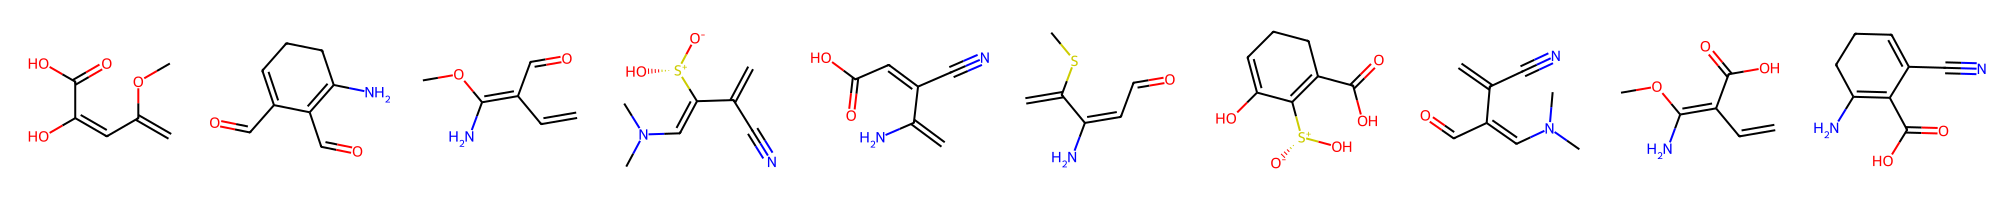

In [117]:
display( df.head(10) )
img1 = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df.head(10).index ], molsPerRow=10,  )
img1

In [ ]:
err = df_hybrid["LUMO"]-df_hybrid["LUMO_predicted"]
df_hybrid['err'] = err.abs() 
df = df_hybrid.sort_values(by=['err'], ascending=False)

display( df.head(10) )
img1 = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df.head(10).index ], molsPerRow=10,  )
img1

# The QM9 data

In [53]:
df_diene = pd.read_csv('df_diene_final_dataset.csv', index_col=0)

df_qm9 = df_diene[ df_diene['source'] =='QM9' ].sort_values(by='LUMO',ascending=True)
df_qm9 = df_qm9[ ['LUMO','diene_type'] ]

df_qm9

LUMO diene_type
N#Cc1nnoc(=O)n1                                    -4.68     N=NC=N
[H]C(=O)c1nnoc(=O)n1                               -4.51     N=NC=N
[H]C1=C=[N+]=NC([O-])=C1C#N                        -4.39     N=NC=C
[H]c1noc(=O)nc1C#N                                 -4.20     N=CC=N
[H]c1noc(=O)c(C#N)n1                               -4.17     N=CN=C
...                                                  ...        ...
[H]c1c(N([H])C([H])([H])[H])nc(OC([H])([H])[H])...  1.78     C=NC=C
[H]c1c(N([H])C([H])([H])[H])nc(N([H])C([H])([H]...  1.78     C=NC=C
[H]Oc1nc(N([H])C([H])([H])[H])c([H])n1[H]           1.79     C=NC=C
[H]Oc1nc2c(n1[H])OC([H])([H])C2([H])[H]             1.80     C=NC=C
[H]Oc1nc(N([H])C([H])([H])C([H])([H])[H])c([H])...  1.80     C=NC=C

[12622 rows x 2 columns]

In [54]:
%%capture --no-display

prediction1 = predict_rdk_prop( list(df_qm9.index), fp_name_prop, model_all)
df_qm9['LUMO_predicted'] = prediction1
df_qm9 = df_qm9.sort_values(by='LUMO_predicted',ascending=True)
#df_qm9.to_csv('Old_all_dienes_PredLUMO.csv')

df_qm9

'0 out of 12622'

'1000 out of 12622'

'2000 out of 12622'

'3000 out of 12622'

'4000 out of 12622'

'5000 out of 12622'

'6000 out of 12622'

'7000 out of 12622'

'8000 out of 12622'

'9000 out of 12622'

'10000 out of 12622'

'11000 out of 12622'

'12000 out of 12622'

LUMO diene_type  \
[H]/N=c1\nnoc(=O)o1                                -3.54     N=NC=N   
[H]C([H])([H])OC(=O)n1nnnn1                        -2.45     N=NN=N   
N#Cc1nnc(C#N)o1                                    -3.36     C=NN=C   
[H]n1nnc2c1n([H])c(=O)n2[H]                        -0.22     N=NC=C   
[H]N=c1nnn(C([H])=O)nn1                            -3.09     N=NC=N   
...                                                  ...        ...   
[H]O/N=C1\C([H])=C(N([H])[H])[C@@]([H])(C([H])(...  0.12     N=CC=C   
[H]/N=C1\OC([H])([H])C([H])([H])C(N([H])[H])=C1[H] -0.10     N=CC=C   
[H]O/N=C1\C([H])=C(N([H])[H])C([H])([H])[C@]1([...  0.12     N=CC=C   
[H]O/N=C1\C(C([H])([H])[H])=C(N([H])[H])C([H])(...  0.18     N=CC=C   
[H]/N=C1\OC([H])([H])C([H])([H])C([H])([H])C(N(... -0.18     N=CC=C   

                                                    LUMO_predicted  
[H]/N=c1\nnoc(=O)o1                                          -4.31  
[H]C([H])([H])OC(=O)n1nnnn1                                  -4.25  
N#Cc1nnc(C#N)o1                                              -4.23  
[H]n1nnc2c1n([H])c(=O)n2[H]                                  -4.22  
[H]N=c1nnn(C([H])=O)nn1                                      -4.22  
...                                                            ...  
[H]O/N=C1\C([H])=C(N([H])[H])[C@@]([H])(C([H])(...           -0.39  
[H]/N=C1\OC([H])([H])C([H])([H])C(N([H])[H])=C1[H]           -0.38  
[H]O/N=C1\C([H])=C(N([H])[H])C([H])([H])[C@]1([...           -0.34  
[H]O/N=C1\C(C([H])([H])[H])=C(N([H])[H])C([H])(...           -0.32  
[H]/N=C1\OC([H])([H])C([H])([H])C([H])([H])C(N(...           -0.27  

[12622 rows x 3 columns]

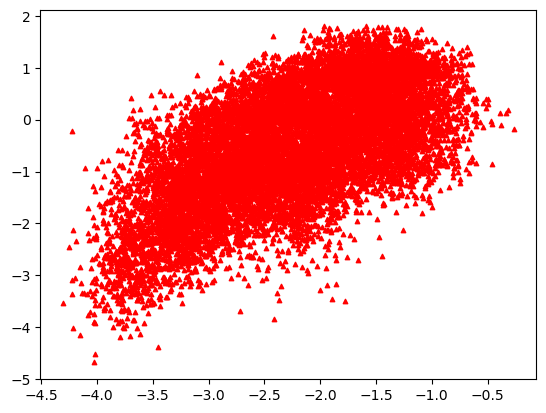

In [56]:
#sns.scatterplot(data=df_old, x=, y=)
y,x = df_qm9["LUMO"], df_qm9["LUMO_predicted"]
plt.scatter(x,y, s=10, marker='^', c='r')

# New dienes

### The large un-filtered functionalization

In [75]:
## Jump start with new structures
df1 = pd.read_csv( 'One_functionalized_13butadiene.csv', index_col=0) 
df2 = pd.read_csv( 'Two_functionalized_13butadiene.csv', index_col=0) 
display( df1, df2 )

SMILES                                              INCHI  \
0           C=CC(=C)N              InChI=1S/C4H7N/c1-3-4(2)5/h3H,1-2,5H2   
1             C=CC=CN              InChI=1S/C4H7N/c1-2-3-4-5/h2-4H,1,5H2   
2             C=CC=CC             InChI=1S/C5H8/c1-3-5-4-2/h3-5H,1H2,2H3   
3           C=CC(=C)C             InChI=1S/C5H8/c1-4-5(2)3/h4H,1-2H2,3H3   
4           C=CC(=C)O              InChI=1S/C4H6O/c1-3-4(2)5/h3,5H,1-2H2   
..                ...                                                ...   
607   C=CC(=C)NC(=O)O  InChI=1S/C5H7NO2/c1-3-4(2)6-5(7)8/h3,6H,1-2H2,...   
608    C=CC(=C)N=CC=N     InChI=1S/C6H8N2/c1-3-6(2)8-5-4-7/h3-5,7H,1-2H2   
609      C=CC=CN=CC=N         InChI=1S/C6H8N2/c1-2-3-5-8-6-4-7/h2-7H,1H2   
610  C=CC(=C)C(=N)C=N   InChI=1S/C6H8N2/c1-3-5(2)6(8)4-7/h3-4,7-8H,1-2H2   
611    C=CC=CC(=N)C=N     InChI=1S/C6H8N2/c1-2-3-4-6(8)5-7/h2-5,7-8H,1H2   

     SMILES_pattern_C=CC=C  SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  \
0                     True                  False                  False   
1                     True                  False                  False   
2                     True                  False                  False   
3                     True                  False                  False   
4                     True                  False                  False   
..                     ...                    ...                    ...   
607                   True                  False                  False   
608                   True                  False                   True   
609                   True                  False                   True   
610                   True                   True                  False   
611                   True                   True                  False   

     SMILES_pattern_N=NC=C  SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  \
0                    False                  False                  False   
1                    False                  False                  False   
2                    False                  False                  False   
3                    False                  False                  False   
4                    False                  False                  False   
..                     ...                    ...                    ...   
607                  False                  False                  False   
608                  False                  False                   True   
609                  False                  False                   True   
610                  False                  False                   True   
611                  False                  False                   True   

     SMILES_pattern_C=NN=C  SMILES_pattern_N=NN=C  SMILES_pattern_N=NC=N  \
0                    False                  False                  False   
1                    False                  False                  False   
2                    False                  False                  False   
3                    False                  False                  False   
4                    False                  False                  False   
..                     ...                    ...                    ...   
607                  False                  False                  False   
608                  False                  False                  False   
609                  False                  False                  False   
610                  False                  False                  False   
611                  False                  False                  False   

     SMILES_pattern_N=NN=N  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  
..                     ...  
607                  False  
608                  False  
609                  False  
610                  False  
611                  False  

[611 rows x 12

SMILES  \
0                       C=CC(N)=CN   
1                       C=C(N)C=CN   
2                     C=C(N)C(=C)N   
3                     C=C(C)C(=C)N   
4                       C=CC(N)=CC   
...                            ...   
654225    C=CC(=CC(=N)C=N)C(=N)C=N   
654226    C=C(C=CC(=N)C=N)C(=N)C=N   
654227  C=C(C(=C)C(=N)C=N)C(=N)C=N   
655448    C=CC=C(C(=N)C=N)C(=N)C=N   
655450      N=CC(=N)C=CC=CC(=N)C=N   

                                                    INCHI  \
0              InChI=1S/C4H8N2/c1-2-4(6)3-5/h2-3H,1,5-6H2   
1              InChI=1S/C4H8N2/c1-4(6)2-3-5/h2-3H,1,5-6H2   
2                 InChI=1S/C4H8N2/c1-3(5)4(2)6/h1-2,5-6H2   
3                InChI=1S/C5H9N/c1-4(2)5(3)6/h1,3,6H2,2H3   
4             InChI=1S/C5H9N/c1-3-5(6)4-2/h3-4H,1,6H2,2H3   
...                                                   ...   
654225  InChI=1S/C8H10N4/c1-2-6(8(12)5-10)3-7(11)4-9/h...   
654226  InChI=1S/C8H10N4/c1-6(8(12)5-10)2-3-7(11)4-9/h...   
654227  InChI=1S/C8H10N4/c1-5(7(11)3-9)6(2)8(12)4-10/h...   
655448  InChI=1S/C8H10N4/c1-2-3-6(7(11)4-9)8(12)5-10/h...   
655450  InChI=1S/C8H10N4/c9-5-7(11)3-1-2-4-8(12)6-10/h...   

        SMILES_pattern_C=CC=C  SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  \
0                        True                  False                  False   
1                        True                  False                  False   
2                        True                  False                  False   
3                        True                  False                  False   
4                        True                  False                  False   
...                       ...                    ...                    ...   
654225                   True                   True                  False   
654226                   True                   True                  False   
654227                   True                   True                  False   
655448                   True                   True                  False   
655450                   True                   True                  False   

        SMILES_pattern_N=NC=C  SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  \
0                       False                  False                  False   
1                       False                  False                  False   
2                       False                  False                  False   
3                       False                  False                  False   
4                       False                  False                  False   
...                       ...                    ...                    ...   
654225                  False                  False                   True   
654226                  False                  False                   True   
654227                  False                  False                   True   
655448                  False                  False                   True   
655450                  False                  False                   True   

        SMILES_pattern_C=NN=C  SMILES_pattern_N=NN=C  SMILES_pattern_N=NC=N  \
0                       False                  False                  False   
1                       False                  False                  False   
2                       False                  False                  False   
3                       False                  False                  False   
4                       False                  False                  False   
...                       ...                    ...                    ...   
654225                  False                  False                  False   
654226                  False                  False                  False   
654227                  False                  False                  False   
655448                  False                  False                  False   
655450                  False                  False                  F

In [31]:
## If needed
%%capture --no-display
patterns = ['C=CC=C','N=CC=C','C=NC=C','N=NC=C','N=CN=C','N=CC=N','C=NN=C','N=NN=C','N=NC=N','N=NN=N']
for p in patterns:
    has_diene_pattern(df1, pattern=p)
for p in patterns:
    has_diene_pattern(df2, pattern=p)
df1.to_csv( 'One_functionalized_13butadiene.csv') 
df2.to_csv( 'Two_functionalized_13butadiene.csv') 


'Match results: '

'C=CC=C'

611

'Match results: '

'N=CC=C'

56

'Match results: '

'C=NC=C'

28

'Match results: '

'N=NC=C'

18

'Match results: '

'N=CN=C'

6

'Match results: '

'N=CC=N'

4

'Match results: '

'C=NN=C'

2

'Match results: '

'N=NN=C'

4

'Match results: '

'N=NC=N'

0

'Match results: '

'N=NN=N'

2

'Match results: '

'C=CC=C'

326887

'Match results: '

'N=CC=C'

57124

'Match results: '

'C=NC=C'

29187

'Match results: '

'N=NC=C'

18877

'Match results: '

'N=CN=C'

6396

'Match results: '

'N=CC=N'

4271

'Match results: '

'C=NN=C'

2139

'Match results: '

'N=NN=C'

4271

'Match results: '

'N=NC=N'

0

'Match results: '

'N=NN=N'

2139

SMILES                                              INCHI  \
0           C=CC(=C)N              InChI=1S/C4H7N/c1-3-4(2)5/h3H,1-2,5H2   
1             C=CC=CN              InChI=1S/C4H7N/c1-2-3-4-5/h2-4H,1,5H2   
2             C=CC=CC             InChI=1S/C5H8/c1-3-5-4-2/h3-5H,1H2,2H3   
3           C=CC(=C)C             InChI=1S/C5H8/c1-4-5(2)3/h4H,1-2H2,3H3   
4           C=CC(=C)O              InChI=1S/C4H6O/c1-3-4(2)5/h3,5H,1-2H2   
..                ...                                                ...   
607   C=CC(=C)NC(=O)O  InChI=1S/C5H7NO2/c1-3-4(2)6-5(7)8/h3,6H,1-2H2,...   
608    C=CC(=C)N=CC=N     InChI=1S/C6H8N2/c1-3-6(2)8-5-4-7/h3-5,7H,1-2H2   
609      C=CC=CN=CC=N         InChI=1S/C6H8N2/c1-2-3-5-8-6-4-7/h2-7H,1H2   
610  C=CC(=C)C(=N)C=N   InChI=1S/C6H8N2/c1-3-5(2)6(8)4-7/h3-4,7-8H,1-2H2   
611    C=CC=CC(=N)C=N     InChI=1S/C6H8N2/c1-2-3-4-6(8)5-7/h2-5,7-8H,1H2   

     SMILES_pattern_C=CC=C  SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  \
0                     True                  False                  False   
1                     True                  False                  False   
2                     True                  False                  False   
3                     True                  False                  False   
4                     True                  False                  False   
..                     ...                    ...                    ...   
607                   True                  False                  False   
608                   True                  False                   True   
609                   True                  False                   True   
610                   True                   True                  False   
611                   True                   True                  False   

     SMILES_pattern_N=NC=C  SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  \
0                    False                  False                  False   
1                    False                  False                  False   
2                    False                  False                  False   
3                    False                  False                  False   
4                    False                  False                  False   
..                     ...                    ...                    ...   
607                  False                  False                  False   
608                  False                  False                   True   
609                  False                  False                   True   
610                  False                  False                   True   
611                  False                  False                   True   

     SMILES_pattern_C=NN=C  SMILES_pattern_N=NN=C  SMILES_pattern_N=NC=N  \
0                    False                  False                  False   
1                    False                  False                  False   
2                    False                  False                  False   
3                    False                  False                  False   
4                    False                  False                  False   
..                     ...                    ...                    ...   
607                  False                  False                  False   
608                  False                  False                  False   
609                  False                  False                  False   
610                  False                  False                  False   
611                  False                  False                  False   

     SMILES_pattern_N=NN=N  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  
..                     ...  
607                  False  
608                  False  
609                  False  
610                  False  
611                  False  

[611 rows x 12

SMILES  \
0                       C=CC(N)=CN   
1                       C=C(N)C=CN   
2                     C=C(N)C(=C)N   
3                     C=C(C)C(=C)N   
4                       C=CC(N)=CC   
...                            ...   
654225    C=CC(=CC(=N)C=N)C(=N)C=N   
654226    C=C(C=CC(=N)C=N)C(=N)C=N   
654227  C=C(C(=C)C(=N)C=N)C(=N)C=N   
655448    C=CC=C(C(=N)C=N)C(=N)C=N   
655450      N=CC(=N)C=CC=CC(=N)C=N   

                                                    INCHI  \
0              InChI=1S/C4H8N2/c1-2-4(6)3-5/h2-3H,1,5-6H2   
1              InChI=1S/C4H8N2/c1-4(6)2-3-5/h2-3H,1,5-6H2   
2                 InChI=1S/C4H8N2/c1-3(5)4(2)6/h1-2,5-6H2   
3                InChI=1S/C5H9N/c1-4(2)5(3)6/h1,3,6H2,2H3   
4             InChI=1S/C5H9N/c1-3-5(6)4-2/h3-4H,1,6H2,2H3   
...                                                   ...   
654225  InChI=1S/C8H10N4/c1-2-6(8(12)5-10)3-7(11)4-9/h...   
654226  InChI=1S/C8H10N4/c1-6(8(12)5-10)2-3-7(11)4-9/h...   
654227  InChI=1S/C8H10N4/c1-5(7(11)3-9)6(2)8(12)4-10/h...   
655448  InChI=1S/C8H10N4/c1-2-3-6(7(11)4-9)8(12)5-10/h...   
655450  InChI=1S/C8H10N4/c9-5-7(11)3-1-2-4-8(12)6-10/h...   

        SMILES_pattern_C=CC=C  SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  \
0                        True                  False                  False   
1                        True                  False                  False   
2                        True                  False                  False   
3                        True                  False                  False   
4                        True                  False                  False   
...                       ...                    ...                    ...   
654225                   True                   True                  False   
654226                   True                   True                  False   
654227                   True                   True                  False   
655448                   True                   True                  False   
655450                   True                   True                  False   

        SMILES_pattern_N=NC=C  SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  \
0                       False                  False                  False   
1                       False                  False                  False   
2                       False                  False                  False   
3                       False                  False                  False   
4                       False                  False                  False   
...                       ...                    ...                    ...   
654225                  False                  False                   True   
654226                  False                  False                   True   
654227                  False                  False                   True   
655448                  False                  False                   True   
655450                  False                  False                   True   

        SMILES_pattern_C=NN=C  SMILES_pattern_N=NN=C  SMILES_pattern_N=NC=N  \
0                       False                  False                  False   
1                       False                  False                  False   
2                       False                  False                  False   
3                       False                  False                  False   
4                       False                  False                  False   
...                       ...                    ...                    ...   
654225                  False                  False                  False   
654226                  False                  False                  False   
654227                  False                  False                  False   
655448                  False                  False                  False   
655450                  False                  False                  F

In [76]:
patterns_col = [ c for c in df1.columns if 'SMILES_pattern_' in c ]
pattern_yes = ['SMILES_pattern_C=CC=C']
pattern_no = [p for p in patterns_col if p not in pattern_yes]

mask1 = np.any( df1[pattern_yes]==True, axis=1)
mask2 = np.all( df1[pattern_no]==False, axis=1)
mask_keep = np.all([mask1,mask2], axis=0)
df1_filter = df1[mask_keep]

mask1 = np.any( df2[pattern_yes]==True, axis=1)
mask2 = np.all( df2[pattern_no]==False, axis=1)
mask_keep = np.all([mask1,mask2], axis=0)
df2_filter = df2[mask_keep]

display( df1_filter, df2_filter )

SMILES                                              INCHI  \
0          C=CC(=C)N              InChI=1S/C4H7N/c1-3-4(2)5/h3H,1-2,5H2   
1            C=CC=CN              InChI=1S/C4H7N/c1-2-3-4-5/h2-4H,1,5H2   
2            C=CC=CC             InChI=1S/C5H8/c1-3-5-4-2/h3-5H,1H2,2H3   
3          C=CC(=C)C             InChI=1S/C5H8/c1-4-5(2)3/h4H,1-2H2,3H3   
4          C=CC(=C)O              InChI=1S/C4H6O/c1-3-4(2)5/h3,5H,1-2H2   
..               ...                                                ...   
603    C=CC(=C)NNN=C     InChI=1S/C5H9N3/c1-4-5(2)7-8-6-3/h4,7-8H,1-3H2   
604  C=CC(=C)N(N)N=C       InChI=1S/C5H9N3/c1-4-5(2)8(6)7-3/h4H,1-3,6H2   
605    C=CC=CN(N)N=C     InChI=1S/C5H9N3/c1-3-4-5-8(6)7-2/h3-5H,1-2,6H2   
606    C=CC=CNC(=O)O  InChI=1S/C5H7NO2/c1-2-3-4-6-5(7)8/h2-4,6H,1H2,...   
607  C=CC(=C)NC(=O)O  InChI=1S/C5H7NO2/c1-3-4(2)6-5(7)8/h3,6H,1-2H2,...   

     SMILES_pattern_C=CC=C  SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  \
0                     True                  False                  False   
1                     True                  False                  False   
2                     True                  False                  False   
3                     True                  False                  False   
4                     True                  False                  False   
..                     ...                    ...                    ...   
603                   True                  False                  False   
604                   True                  False                  False   
605                   True                  False                  False   
606                   True                  False                  False   
607                   True                  False                  False   

     SMILES_pattern_N=NC=C  SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  \
0                    False                  False                  False   
1                    False                  False                  False   
2                    False                  False                  False   
3                    False                  False                  False   
4                    False                  False                  False   
..                     ...                    ...                    ...   
603                  False                  False                  False   
604                  False                  False                  False   
605                  False                  False                  False   
606                  False                  False                  False   
607                  False                  False                  False   

     SMILES_pattern_C=NN=C  SMILES_pattern_N=NN=C  SMILES_pattern_N=NC=N  \
0                    False                  False                  False   
1                    False                  False                  False   
2                    False                  False                  False   
3                    False                  False                  False   
4                    False                  False                  False   
..                     ...                    ...                    ...   
603                  False                  False                  False   
604                  False                  False                  False   
605                  False                  False                  False   
606                  False                  False                  False   
607                  False                  False                  False   

     SMILES_pattern_N=NN=N  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  
..                     ...  
603                  False  
604                  False  
605                  False  
606                  False  
607                  False  

[513 rows x 12 columns]

SMILES  \
0                     C=CC(N)=CN   
1                     C=C(N)C=CN   
2                   C=C(N)C(=C)N   
3                   C=C(C)C(=C)N   
4                     C=CC(N)=CC   
...                          ...   
650238    C=CC(=CNC(=O)O)NC(=O)O   
650239    C=C(C=CNC(=O)O)NC(=O)O   
650240      O=C(O)NC=CC=CNC(=O)O   
650241    C=CC=C(NC(=O)O)NC(=O)O   
651161  C=C(NC(=O)O)C(=C)NC(=O)O   

                                                    INCHI  \
0              InChI=1S/C4H8N2/c1-2-4(6)3-5/h2-3H,1,5-6H2   
1              InChI=1S/C4H8N2/c1-4(6)2-3-5/h2-3H,1,5-6H2   
2                 InChI=1S/C4H8N2/c1-3(5)4(2)6/h1-2,5-6H2   
3                InChI=1S/C5H9N/c1-4(2)5(3)6/h1,3,6H2,2H3   
4             InChI=1S/C5H9N/c1-3-5(6)4-2/h3-4H,1,6H2,2H3   
...                                                   ...   
650238  InChI=1S/C6H8N2O4/c1-2-4(8-6(11)12)3-7-5(9)10/...   
650239  InChI=1S/C6H8N2O4/c1-4(8-6(11)12)2-3-7-5(9)10/...   
650240  InChI=1S/C6H8N2O4/c9-5(10)7-3-1-2-4-8-6(11)12/...   
650241  InChI=1S/C6H8N2O4/c1-2-3-4(7-5(9)10)8-6(11)12/...   
651161  InChI=1S/C6H8N2O4/c1-3(7-5(9)10)4(2)8-6(11)12/...   

        SMILES_pattern_C=CC=C  SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  \
0                        True                  False                  False   
1                        True                  False                  False   
2                        True                  False                  False   
3                        True                  False                  False   
4                        True                  False                  False   
...                       ...                    ...                    ...   
650238                   True                  False                  False   
650239                   True                  False                  False   
650240                   True                  False                  False   
650241                   True                  False                  False   
651161                   True                  False                  False   

        SMILES_pattern_N=NC=C  SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  \
0                       False                  False                  False   
1                       False                  False                  False   
2                       False                  False                  False   
3                       False                  False                  False   
4                       False                  False                  False   
...                       ...                    ...                    ...   
650238                  False                  False                  False   
650239                  False                  False                  False   
650240                  False                  False                  False   
650241                  False                  False                  False   
651161                  False                  False                  False   

        SMILES_pattern_C=NN=C  SMILES_pattern_N=NN=C  SMILES_pattern_N=NC=N  \
0                       False                  False                  False   
1                       False                  False                  False   
2                       False                  False                  False   
3                       False                  False                  False   
4                       False                  False                  False   
...                       ...                    ...                    ...   
650238                  False                  False                  False   
650239                  False                  False                  False   
650240                  False                  False                  False   
650241                  False                  False                  False   
651161                  False                  False                  False   

        SMILE

In [ ]:
df1_filter.to_csv('Predicted_cccc_pnl_one_func.csv')
df2_filter.to_csv('Predicted_cccc_pnl_two_func.csv')

### Common functional group list

In [ ]:
## The 1,3-butadiene 
df1_a = pd.read_csv( 'ShortList_One_functionalized_13butadiene.csv', index_col=0) 
df2_a = pd.read_csv( 'ShortList_Two_functionalized_13butadiene.csv', index_col=0) 
df3_a = pd.read_csv( 'ShortList_Three_functionalized_13butadiene.csv', index_col=0) 
df4_a = pd.read_csv( 'ShortList_Four_functionalized_13butadiene.csv', index_col=0) 
print( len(df1_a),len(df2_a),len(df3_a),len(df4_a) )

df0_n = pd.read_csv( 'ShortList_None_functionalized_Nring.csv', index_col=0) 
df1_n = pd.read_csv( 'ShortList_One_functionalized_Nring.csv', index_col=0)  
df2_n = pd.read_csv( 'ShortList_Two_functionalized_Nring.csv', index_col=0)  
df3_n = pd.read_csv( 'ShortList_Three_functionalized_Nring.csv', index_col=0) 
df4_n = pd.read_csv( 'ShortList_Four_functionalized_Nring.csv', index_col=0) 
print( len(df0_n),len(df1_n),len(df2_n),len(df3_n),len(df4_n) )

print( 'Total: ', len(df1_a)+len(df2_a)+len(df3_a)+len(df4_a)  +  len(df0_n)+len(df1_n)+len(df2_n)+len(df3_n)+len(df4_n) )
display( df1_a.head(), df0_n.head() )

In [ ]:
from itertools import chain
df1_filter = df1_a[[ not len( list(chain(*locate_func(smi=s).values())) )!=1 for s in df1_a['SMILES'] ]]
df2_filter = df2_a[[ not len( list(chain(*locate_func(smi=s).values())) )!=2 for s in df2_a['SMILES'] ]]
df3_filter = df3_a[[ not len( list(chain(*locate_func(smi=s).values())) )!=3 for s in df3_a['SMILES'] ]]
df4_filter = df4_a[[ not len( list(chain(*locate_func(smi=s).values())) )!=4 for s in df4_a['SMILES'] ]]
display( len(df1_filter),len(df2_filter),len(df3_filter),len(df4_filter) )

In [14]:
df1_a['type'] = 11
df2_a['type'] = 12
df3_a['type'] = 13
df4_a['type'] = 14
df0_a = pd.DataFrame( [['C=CC=C','None',10]], columns=['SMILES','INCHI','type'] )
df_all= pd.concat( [ df0_a,df1_a,df2_a,df3_a,df4_a,  df0_n,df1_n,df2_n,df3_n,df4_n ], axis=0 )
display( df_all.shape )
df_all = df_all.drop_duplicates(subset=['INCHI'], keep='first', inplace=False)

df_all.to_csv('New_all_dienes.csv')
df_all

(4526657, 3)

SMILES  \
0                                           C=CC=C   
0                                          C=CC=CO   
1                                        C=CC(=C)O   
2                                       C=CC(=C)NC   
3                                         C=CC=CNC   
...                                            ...   
305608        N=NC1(N=N)N=C(C(N)=O)C(C(N)=O)=NC1=O   
305609        N=NC1=NC(N=N)(C(N)=O)C(=O)N=C1C(N)=O   
305610     N=NC1(C(N)=O)N=C(C(N)=O)C(C(N)=O)=NC1=O   
305611     N=NC1=NC(C(N)=O)(C(N)=O)C(=O)N=C1C(N)=O   
305612  NC(=O)C1=NC(=O)C(C(N)=O)(C(N)=O)N=C1C(N)=O   

                                                    INCHI  type  
0                                                    None    10  
0                     InChI=1S/C4H6O/c1-2-3-4-5/h2-5H,1H2    11  
1                   InChI=1S/C4H6O/c1-3-4(2)5/h3,5H,1-2H2    11  
2             InChI=1S/C5H9N/c1-4-5(2)6-3/h4,6H,1-2H2,3H3    11  
3               InChI=1S/C5H9N/c1-3-4-5-6-2/h3-6H,1H2,2H3    11  
...                                                   ...   ...  
305608  InChI=1S/C6H6N8O3/c7-3(15)1-2(4(8)16)12-6(13-9...     6  
305609  InChI=1S/C6H6N8O3/c7-2(15)1-3(13-9)12-6(14-10,...     6  
305610  InChI=1S/C7H7N7O4/c8-3(15)1-2(4(9)16)13-7(14-1...     6  
305611  InChI=1S/C7H7N7O4/c8-2(15)1-3(14-11)13-7(4(9)1...     6  
305612  InChI=1S/C8H8N6O5/c9-3(15)1-2(4(10)16)14-8(5(1...     6  

[4526657 rows x 3 columns]

In [15]:
df_rings = pd.concat( [df['type'].value_counts() for df in [df0_n,df1_n,df2_n,df3_n,df4_n]], axis=1 ).sort_values(by='type',ascending=True).T
df_rings.columns = ['Ring=5','Ring=5 with O','Ring=5 with C=O','Ring=6','Ring=6 C-C','Ring=6 with O','Ring=6 with C=O','Ring=6 with both C=O and O']  ## The name of each type
df_rings

Ring=5  Ring=5 with O  Ring=5 with C=O    Ring=6  Ring=6 C-C  \
count       6.0            6.0              6.0       8.0         6.0   
count     252.0          126.0            125.0     294.0       315.0   
count    4935.0          903.0            882.0    6279.0     10290.0   
count   48069.0            NaN              NaN   62629.0    194481.0   
count  208593.0            NaN              NaN  248283.0   2259810.0   

       Ring=6 with O  Ring=6 with C=O  Ring=6 with both C=O and O  
count           10.0              6.0                        10.0  
count          504.0            294.0                       294.0  
count        10689.0           6237.0                      2205.0  
count       114219.0          66591.0                         NaN  
count       509355.0         305613.0                         NaN

Aliphatic    Ring 5  Ring 5 with O  Ring 5 with =O    Ring 6  \
0          1       6.0            6.0             6.0       8.0   
1         42     252.0          126.0           125.0     294.0   
2       1554    4935.0          903.0           882.0    6279.0   
3      32865   48069.0            NaN             NaN   62629.0   
4     429870  208593.0            NaN             NaN  248283.0   

   Ring 6 with C-C  Ring 6 with O  Ring 6 with =O  Ring 6 with both =O and O  
0              6.0           10.0             6.0                       10.0  
1            315.0          504.0           294.0                      294.0  
2          10290.0        10689.0          6237.0                     2205.0  
3         194481.0       114219.0         66591.0                        NaN  
4        2259810.0       509355.0        305613.0                        NaN

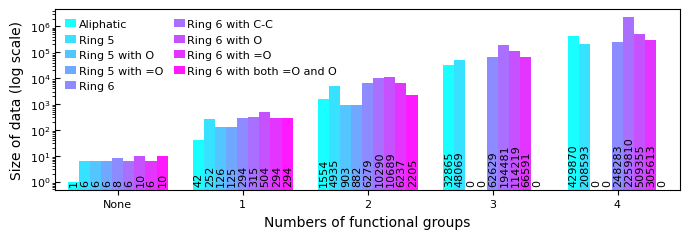

In [16]:
df_butad = pd.DataFrame([len(df0_a),len(df1_a),len(df2_a),len(df3_a),len(df4_a)], columns=['Aliphatic'])   
df_butad.index = [0,1,2,3,4]
#display( df_butad )

ring_names = ['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with both =O and O']
df_rings = pd.concat( [df['type'].value_counts() for df in [df0_n,df1_n,df2_n,df3_n,df4_n]], axis=1 ).sort_values(by='type',ascending=True).T
df_rings.columns = ring_names  ## The name of each type
df_rings.index = [0,1,2,3,4]   ## The num of functional groups 
#display( df_rings )  

df_plot = pd.concat([df_butad,df_rings], axis=1, join='outer').sort_index()
display( df_plot )  

fig, axs = plt.subplots(1,1,figsize=(7,2.5),tight_layout=True,dpi=100)

#colors = ['magenta','green','darkorange','b','r']
cmap = plt.get_cmap('cool')
colors = cmap(np.linspace(0, 1, 9))

df_plot.plot(kind='bar', stacked=False, y=['Aliphatic']+ring_names, ax=axs, color=colors,
             width=0.8, alpha=0.9)
#for ii,container in enumerate(axs.containers):
#    container.datavalues[0]=-1
#    axs.bar_label(container, rotation=90, fontsize=8, padding=-30 ) #label_type='center')
for rect in axs.patches:
    x = rect.get_x()
    y = rect.get_height()
    axs.text(x+0.01,0.7,str(int(y)), ha='left', va='bottom', fontsize=8, color='k', rotation=90) # x=cx+0.1
    
axs.set_xlabel('Numbers of functional groups',fontsize=10) ## input X name
axs.set_ylabel('Size of data (log scale)',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8, axis='y')
axs.set_xticklabels( ['None','1','2','3','4'], rotation=0, fontsize=8)
axs.set_xlim([-0.5,4.5])
#axs.set_xticks( [] )
axs.legend(labels=['Aliphatic']+ring_names, fontsize=8, frameon=False, ncol=2, handlelength=1, handletextpad=0.2, columnspacing=1)
plt.yscale('log')

plt.savefig("poplation.png", dpi=800)  
plt.show()


## Pattern matched data used in paper

In [182]:
job_csv = [f for f in os.listdir('./') if 'new_dinene_' in f ]
job_csv

['new_dinene_four_func_0.csv',
 'new_dinene_four_func_1.csv',
 'new_dinene_one_func_0.csv',
 'new_dinene_one_func_1.csv',
 'new_dinene_one_func_2.csv',
 'new_dinene_three_func_0.csv',
 'new_dinene_three_func_1.csv',
 'new_dinene_two_func_0.csv',
 'new_dinene_two_func_1.csv',
 'new_dinene_two_func_2.csv']

In [183]:
df_new = pd.DataFrame()
for j in job_csv:
    df = pd.read_csv( j, index_col=0)
    j = j[11:-4].split('_')
    df['source'] = j[-1]+'_'+j[0].replace('one','1').replace('two','2').replace('three','3') # x_y means diene_#group
    df_new = pd.concat( [df_new, df], axis=0, ignore_index=True )
df_new

SMILES  \
0                          C=CC(=C)O   
1                            C=CC=CO   
2                           C=CC=CNC   
3                         C=CC(=C)NC   
4                        C=CC=CN(C)C   
...                              ...   
47555  CNC(=O)c1nnc([N+](=O)[O-])nn1   
47556       O=[N+]([O-])c1nnc(CO)nn1   
47557       CNC(=O)c1nnc(C(=O)NC)nn1   
47558            CNC(=O)c1nnc(CO)nn1   
47559                 OCc1nnc(CO)nn1   

                                                   INCHI source  
0                  InChI=1S/C4H6O/c1-3-4(2)5/h3,5H,1-2H2    0_1  
1                    InChI=1S/C4H6O/c1-2-3-4-5/h2-5H,1H2    0_1  
2              InChI=1S/C5H9N/c1-3-4-5-6-2/h3-6H,1H2,2H3    0_1  
3            InChI=1S/C5H9N/c1-4-5(2)6-3/h4,6H,1-2H2,3H3    0_1  
4         InChI=1S/C6H11N/c1-4-5-6-7(2)3/h4-6H,1H2,2-3H3    0_1  
...                                                  ...    ...  
47555  InChI=1S/C4H4N6O3/c1-5-3(11)2-6-8-4(9-7-2)10(1...    2_2  
47556  InChI=1S/C3H3N5O3/c9-1-2-4-6-3(7-5-2)8(10)11/h...    2_2  
47557  InChI=1S/C6H8N6O2/c1-7-5(13)3-9-11-4(12-10-3)6...    2_2  
47558  InChI=1S/C5H7N5O2/c1-6-5(12)4-9-7-3(2-11)8-10-...    2_2  
47559  InChI=1S/C4H6N4O2/c9-1-3-5-7-4(2-10)8-6-3/h9-1...    2_2  

[47560 rows x 3 columns]

In [184]:
df_new.value_counts('source')

source
0_3    28600
1_3    16000
0_2     1430
1_2     1220
2_2      210
0_1       40
1_1       40
2_1       20
Name: count, dtype: int64

In [186]:
%%capture --no-display
"""
mask = np.array([ True if '_1' in c or '_2' in c else False for c in df_new['source'] ])
df = df_new[mask]

df1 = df_new[~mask]
df1 = df1.sample(n=4000)
df = pd.concat( [df, df1], axis=0, ignore_index=True )
"""
##
df = df_new
##

prediction1 = predict_rdk_prop( list(df['SMILES']), fp_name_prop, model_all, scaler=scaler_all )
df['LUMO_predicted'] = prediction1
df = df.sort_values(by='LUMO_predicted',ascending=True)
display( df )

'0 out of 47560'

'4756 out of 47560'

'9512 out of 47560'

'14268 out of 47560'

'19024 out of 47560'

'23780 out of 47560'

'28536 out of 47560'

'33292 out of 47560'

'38048 out of 47560'

'42804 out of 47560'

SMILES  \
47498                   N#Cc1nnc(C=O)nn1   
47532                   N#Cc1nnc(C#N)nn1   
47517                N#Cc1nnc(C(=O)O)nn1   
27633  N#CC(=CC=C[N+](=O)[O-])S(=O)(=O)O   
27655  N#CC=CC=C([N+](=O)[O-])S(=O)(=O)O   
...                                  ...   
8095                     CN(C)C=CC=C(N)N   
45096                           NC=CC=CN   
8100                    COC(=CC=CN)N(C)C   
11221                       COC(N)=CC=CN   
8097                    COC(N)=CC=CN(C)C   

                                                   INCHI source  \
47498        InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H    2_2   
47532              InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3    2_2   
47517  InChI=1S/C4HN5O2/c5-1-2-6-8-3(4(10)11)9-7-2/h(...    2_2   
27633  InChI=1S/C5H4N2O5S/c6-4-5(13(10,11)12)2-1-3-7(...    0_3   
27655  InChI=1S/C5H4N2O5S/c6-4-2-1-3-5(7(8)9)13(10,11...    0_3   
...                                                  ...    ...   
8095   InChI=1S/C6H13N3/c1-9(2)5-3-4-6(7)8/h3-5H,7-8H...    0_3   
45096           InChI=1S/C4H8N2/c5-3-1-2-4-6/h1-4H,5-6H2    0_2   
8100   InChI=1S/C7H14N2O/c1-9(2)7(10-3)5-4-6-8/h4-6H,...    0_3   
11221  InChI=1S/C5H10N2O/c1-8-5(7)3-2-4-6/h2-4H,6-7H2...    0_3   
8097   InChI=1S/C7H14N2O/c1-9(2)6-4-5-7(8)10-3/h4-6H,...    0_3   

       LUMO_predicted  
47498           -4.55  
47532           -4.44  
47517           -4.44  
27633           -4.37  
27655           -4.36  
...               ...  
8095             0.54  
45096            0.54  
8100             0.60  
11221            0.61  
8097             0.66  

[47560 rows x 4 columns]

In [187]:
sorted( list(set(df['source'])) )

['0_1', '0_2', '0_3', '1_1', '1_2', '1_3', '2_1', '2_2']

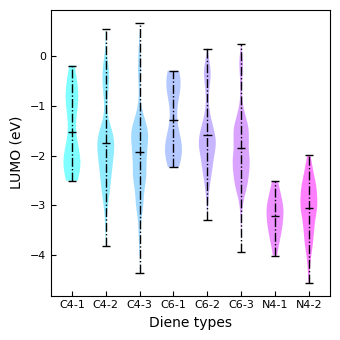

In [188]:
fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,dpi=100)

names_new = sorted( list(set(df['source'])) )
customized_label = ['C4-1','C4-2','C4-3','C6-1','C6-2','C6-3','N4-1','N4-2']

cmap = plt.get_cmap('cool')
colors = cmap(np.linspace(0, 1, len(names_new)))
#colors = ['r','g','b']

df_source = [ df[df['source']==m] for m in names_new ]
parts = axs.violinplot( [ d['LUMO_predicted'] for d in df_source ], showmeans=True)

for i,p in enumerate(parts['bodies']):
    p.set_facecolor(colors[i])
    p.set_edgecolor('None')
    p.set_alpha(0.5)
    #p.set_linewidth(0.1)
for k in ['cbars','cmins','cmaxes','cmeans']:
    parts[k].set_colors('k')    
    parts[k].set_linewidth(1)
    parts[k].set_linestyles('-.')
    
axs.set_xlabel('Diene types', fontsize=10)
axs.set_ylabel('LUMO (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)
axs.set_xticks( [n+1 for n in range(len(df_source)) ] ,labels=customized_label)

#axs.legend(labels=customized_label, fontsize=8, frameon=False, loc=2)
#axs.set_ylim(top=25)
plt.show()


SMILES  \
47498                     N#Cc1nnc(C=O)nn1   
47532                     N#Cc1nnc(C#N)nn1   
47517                  N#Cc1nnc(C(=O)O)nn1   
27633    N#CC(=CC=C[N+](=O)[O-])S(=O)(=O)O   
27655    N#CC=CC=C([N+](=O)[O-])S(=O)(=O)O   
27652      N#CC=CC=C(S(=O)(=O)O)S(=O)(=O)O   
47535              N#Cc1nnc(S(=O)(=O)O)nn1   
24798             N#CC(=CC=CC=O)S(=O)(=O)O   
26270          N#CC(=CC=CC(=O)O)S(=O)(=O)O   
27842    N#CC(C=CS(=O)(=O)O)=C[N+](=O)[O-]   
26271          N#CC=CC=C(C(=O)O)S(=O)(=O)O   
24776             N#CC(C=O)=CC=CS(=O)(=O)O   
27691  N#CC=CC=C([N+](=O)[O-])[N+](=O)[O-]   
27666    N#CC=CC(=C[N+](=O)[O-])S(=O)(=O)O   
24739             N#CC(C=CC=O)=CS(=O)(=O)O   
27653    N#CC(=CC=CS(=O)(=O)O)[N+](=O)[O-]   
27118         COC(=O)C(=CC=CC#N)S(=O)(=O)O   
24757             N#CC(C=CS(=O)(=O)O)=CC=O   
47534                  N#Cc1nnc(S(=O)O)nn1   
47494                     O=Cc1nnc(C=O)nn1   

                                                   INCHI source  \
47498        InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H    2_2   
47532              InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3    2_2   
47517  InChI=1S/C4HN5O2/c5-1-2-6-8-3(4(10)11)9-7-2/h(...    2_2   
27633  InChI=1S/C5H4N2O5S/c6-4-5(13(10,11)12)2-1-3-7(...    0_3   
27655  InChI=1S/C5H4N2O5S/c6-4-2-1-3-5(7(8)9)13(10,11...    0_3   
27652  InChI=1S/C5H5NO6S2/c6-4-2-1-3-5(13(7,8)9)14(10...    0_3   
47535  InChI=1S/C3HN5O3S/c4-1-2-5-7-3(8-6-2)12(9,10)1...    2_2   
24798  InChI=1S/C6H5NO4S/c7-5-6(12(9,10)11)3-1-2-4-8/...    0_3   
26270  InChI=1S/C6H5NO5S/c7-4-5(13(10,11)12)2-1-3-6(8...    0_3   
27842  InChI=1S/C5H4N2O5S/c6-3-5(4-7(8)9)1-2-13(10,11...    0_3   
26271  InChI=1S/C6H5NO5S/c7-4-2-1-3-5(6(8)9)13(10,11)...    0_3   
24776  InChI=1S/C6H5NO4S/c7-4-6(5-8)2-1-3-12(9,10)11/...    0_3   
27691  InChI=1S/C5H3N3O4/c6-4-2-1-3-5(7(9)10)8(11)12/...    0_3   
27666  InChI=1S/C5H4N2O5S/c6-3-1-2-5(4-7(8)9)13(10,11...    0_3   
24739  InChI=1S/C6H5NO4S/c7-4-6(2-1-3-8)5-12(9,10)11/...    0_3   
27653  InChI=1S/C5H4N2O5S/c6-4-5(7(8)9)2-1-3-13(10,11...    0_3   
27118  InChI=1S/C7H7NO5S/c1-13-7(9)6(14(10,11)12)4-2-...    0_3   
24757  InChI=1S/C6H5NO4S/c7-5-6(1-3-8)2-4-12(9,10)11/...    0_3   
47534  InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...    2_2   
47494    InChI=1S/C4H2N4O2/c9-1-3-5-7-4(2-10)8-6-3/h1-2H    2_2   

       LUMO_predicted  
47498           -4.55  
47532           -4.44  
47517           -4.44  
27633           -4.37  
27655           -4.36  
27652           -4.35  
47535           -4.34  
24798           -4.34  
26270           -4.33  
27842           -4.32  
26271           -4.31  
24776           -4.31  
27691           -4.30  
27666           -4.30  
24739           -4.28  
27653           -4.28  
27118           -4.26  
24757           -4.26  
47534           -4.26  
47494           -4.25

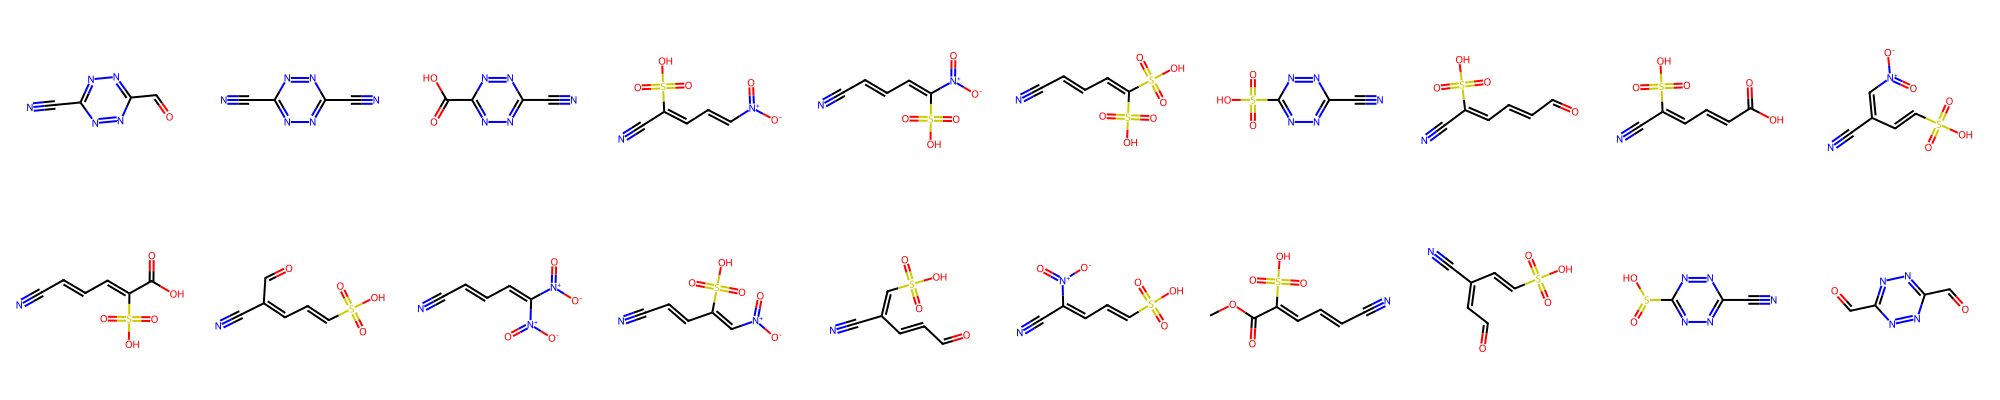

In [189]:
display( df.head(20) )
img1 = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df.head(20)['SMILES'] ], molsPerRow=10,  )
img1

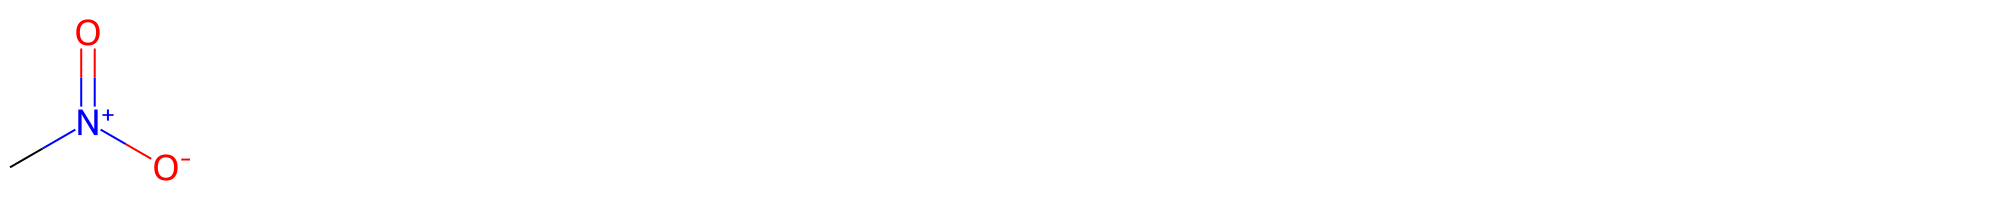

In [190]:
avoid_patterns = ['C[N+](=O)[O-]',]
avoid_mol = [Chem.MolFromSmiles(s) for s in avoid_patterns ]
img1 = Draw.MolsToGridImage( avoid_mol, molsPerRow=10,  )
img1

In [191]:
tag = []
for smi in df['SMILES']:
    mol = Chem.MolFromSmiles(smi)
    Chem.Kekulize(mol)
    match = []
    for m in avoid_mol:
        Chem.Kekulize(m)
        match.append( mol.HasSubstructMatch( m ) )
    tag.append( ~np.any(match) ) # if match any of the pattern

df1 = df[ tag ]
df1

SMILES  \
47498                 N#Cc1nnc(C=O)nn1   
47532                 N#Cc1nnc(C#N)nn1   
47517              N#Cc1nnc(C(=O)O)nn1   
27652  N#CC=CC=C(S(=O)(=O)O)S(=O)(=O)O   
47535          N#Cc1nnc(S(=O)(=O)O)nn1   
...                                ...   
8095                   CN(C)C=CC=C(N)N   
45096                         NC=CC=CN   
8100                  COC(=CC=CN)N(C)C   
11221                     COC(N)=CC=CN   
8097                  COC(N)=CC=CN(C)C   

                                                   INCHI source  \
47498        InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H    2_2   
47532              InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3    2_2   
47517  InChI=1S/C4HN5O2/c5-1-2-6-8-3(4(10)11)9-7-2/h(...    2_2   
27652  InChI=1S/C5H5NO6S2/c6-4-2-1-3-5(13(7,8)9)14(10...    0_3   
47535  InChI=1S/C3HN5O3S/c4-1-2-5-7-3(8-6-2)12(9,10)1...    2_2   
...                                                  ...    ...   
8095   InChI=1S/C6H13N3/c1-9(2)5-3-4-6(7)8/h3-5H,7-8H...    0_3   
45096           InChI=1S/C4H8N2/c5-3-1-2-4-6/h1-4H,5-6H2    0_2   
8100   InChI=1S/C7H14N2O/c1-9(2)7(10-3)5-4-6-8/h4-6H,...    0_3   
11221  InChI=1S/C5H10N2O/c1-8-5(7)3-2-4-6/h2-4H,6-7H2...    0_3   
8097   InChI=1S/C7H14N2O/c1-9(2)6-4-5-7(8)10-3/h4-6H,...    0_3   

       LUMO_predicted  
47498           -4.55  
47532           -4.44  
47517           -4.44  
27652           -4.35  
47535           -4.34  
...               ...  
8095             0.54  
45096            0.54  
8100             0.60  
11221            0.61  
8097             0.66  

[40945 rows x 4 columns]

SMILES  \
47498                 N#Cc1nnc(C=O)nn1   
47532                 N#Cc1nnc(C#N)nn1   
47517              N#Cc1nnc(C(=O)O)nn1   
27652  N#CC=CC=C(S(=O)(=O)O)S(=O)(=O)O   
47535          N#Cc1nnc(S(=O)(=O)O)nn1   
24798         N#CC(=CC=CC=O)S(=O)(=O)O   
26270      N#CC(=CC=CC(=O)O)S(=O)(=O)O   
26271      N#CC=CC=C(C(=O)O)S(=O)(=O)O   
24776         N#CC(C=O)=CC=CS(=O)(=O)O   
24739         N#CC(C=CC=O)=CS(=O)(=O)O   
27118     COC(=O)C(=CC=CC#N)S(=O)(=O)O   
24757         N#CC(C=CS(=O)(=O)O)=CC=O   
47534              N#Cc1nnc(S(=O)O)nn1   
47494                 O=Cc1nnc(C=O)nn1   
27641  N#CC=C(C=CS(=O)(=O)O)S(=O)(=O)O   
27651  N#CC=CC(=CS(=O)(=O)O)S(=O)(=O)O   
27613      N#CC=CC=C(S(=O)O)S(=O)(=O)O   
24799         N#CC=CC(=CC=O)S(=O)(=O)O   
24800         N#CC=C(C=CC=O)S(=O)(=O)O   
27116     COC(=O)C=CC=C(C#N)S(=O)(=O)O   

                                                   INCHI source  \
47498        InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H    2_2   
47532              InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3    2_2   
47517  InChI=1S/C4HN5O2/c5-1-2-6-8-3(4(10)11)9-7-2/h(...    2_2   
27652  InChI=1S/C5H5NO6S2/c6-4-2-1-3-5(13(7,8)9)14(10...    0_3   
47535  InChI=1S/C3HN5O3S/c4-1-2-5-7-3(8-6-2)12(9,10)1...    2_2   
24798  InChI=1S/C6H5NO4S/c7-5-6(12(9,10)11)3-1-2-4-8/...    0_3   
26270  InChI=1S/C6H5NO5S/c7-4-5(13(10,11)12)2-1-3-6(8...    0_3   
26271  InChI=1S/C6H5NO5S/c7-4-2-1-3-5(6(8)9)13(10,11)...    0_3   
24776  InChI=1S/C6H5NO4S/c7-4-6(5-8)2-1-3-12(9,10)11/...    0_3   
24739  InChI=1S/C6H5NO4S/c7-4-6(2-1-3-8)5-12(9,10)11/...    0_3   
27118  InChI=1S/C7H7NO5S/c1-13-7(9)6(14(10,11)12)4-2-...    0_3   
24757  InChI=1S/C6H5NO4S/c7-5-6(1-3-8)2-4-12(9,10)11/...    0_3   
47534  InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...    2_2   
47494    InChI=1S/C4H2N4O2/c9-1-3-5-7-4(2-10)8-6-3/h1-2H    2_2   
27641  InChI=1S/C5H5NO6S2/c6-3-1-5(14(10,11)12)2-4-13...    0_3   
27651  InChI=1S/C5H5NO6S2/c6-3-1-2-5(14(10,11)12)4-13...    0_3   
27613  InChI=1S/C5H5NO5S2/c6-4-2-1-3-5(12(7)8)13(9,10...    0_3   
24799  InChI=1S/C6H5NO4S/c7-4-1-2-6(3-5-8)12(9,10)11/...    0_3   
24800  InChI=1S/C6H5NO4S/c7-4-3-6(2-1-5-8)12(9,10)11/...    0_3   
27116  InChI=1S/C7H7NO5S/c1-13-7(9)4-2-3-6(5-8)14(10,...    0_3   

       LUMO_predicted  
47498           -4.55  
47532           -4.44  
47517           -4.44  
27652           -4.35  
47535           -4.34  
24798           -4.34  
26270           -4.33  
26271           -4.31  
24776           -4.31  
24739           -4.28  
27118           -4.26  
24757           -4.26  
47534           -4.26  
47494           -4.25  
27641           -4.25  
27651           -4.24  
27613           -4.23  
24799           -4.22  
24800           -4.21  
27116           -4.21

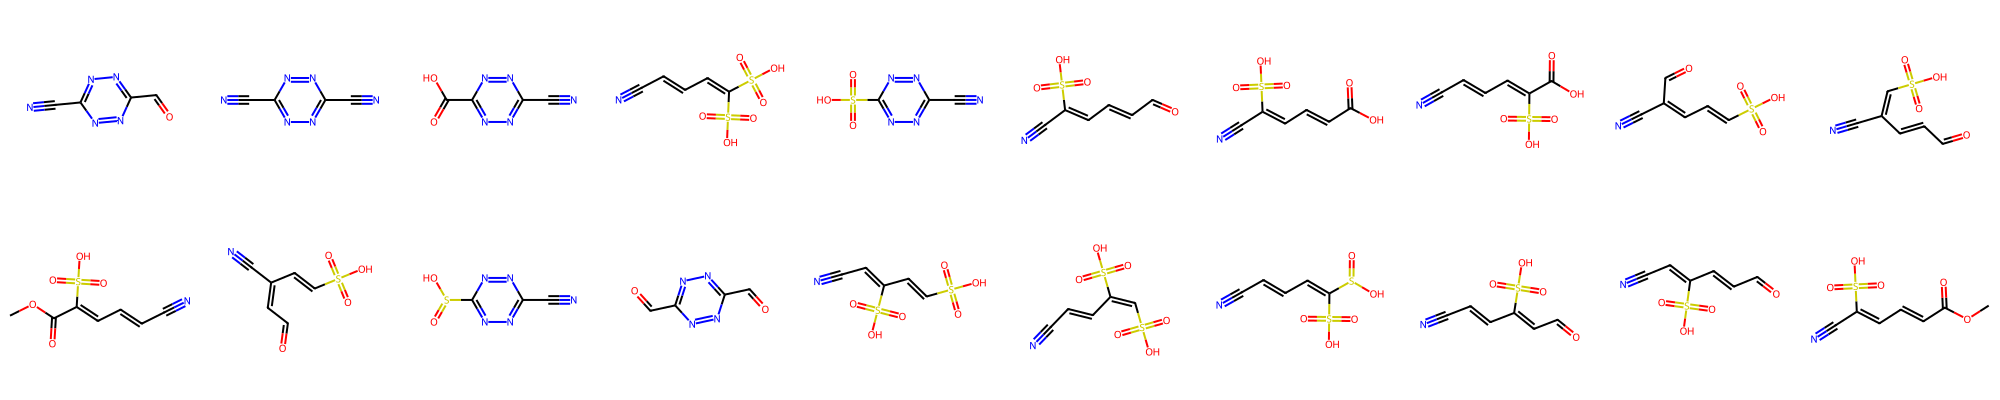

In [192]:
display( df1.head(20) )
img1 = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df1.head(20)['SMILES'] ], molsPerRow=10,  )
img1

### Prediction

In [47]:
s = 'C=CC=C'
fp_name = [ f.replace('rdk_','') for f in fp_name_prop]
fp_calc = MoleculeDescriptors.MolecularDescriptorCalculator(fp_name)
fp = list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) )
df = pd.DataFrame( data=[fp], columns=fp_name_prop )

predict_new = model_all.predict(df)
predict_new

array([0.05447273])

In [ ]:
### This could take a long time with many data, so passed it to HPC and read results here

## The rdk fp
prediction1 = predict_rdk_prop( list(df_all['SMILES']), fp_name_prop, model_all)
df_all['LUMO_predicted'] = prediction1
df_all.to_csv('New_all_dienes_PredLUMO.csv')
df_all
#df_all = pd.read_csv( 'New_all_dienes_PredLUMO.csv', index_col=0) 
#df_all = df_all.sort_values(by='LUMO_predicted',ascending=True)
#df_all

In [48]:
df_pnl = pd.read_csv('df_final_pnl_cccc.csv', index_col=0)
df_qm9 = pd.read_csv('df_final_qm9_cccc.csv', index_col=0)
df_qm9_N = pd.read_csv('df_final_qm9_n_diene.csv', index_col=0)
df_pnl['type'] =90
df_qm9['type'] =91
df_qm9_N['type'] =92
df_old = pd.concat( [df_pnl,df_qm9,df_qm9_N], axis=0 )
df_old = df_old[['SMILES','type','LUMO']]
df_old.drop_duplicates(subset='SMILES', inplace=True, keep='first')

prediction1 = predict_rdk_prop( list(df_old['SMILES']), fp_name_prop, model_all)
df_old['LUMO_predicted'] = prediction1
df_old = df_old.sort_values(by='LUMO_predicted',ascending=True)

df_old.to_csv('Old_all_dienes_PredLUMO.csv')

df_old

100%|██████████| 15589/15589 [04:09<00:00, 62.37it/s]


SMILES  type      LUMO  LUMO_predicted
21191   O=C(C#N)n1nnnn1    92 -4.149632       -4.069829
21290     O=c1oncnc1C#N    92 -4.168679       -4.055188
21184   O=C(C#N)c1nonn1    92 -3.912899       -4.026381
21284   O=c1oncc(n1)C#N    92 -4.195890       -3.999700
21293   O=c1onnc(c1)C#N    92 -4.021741       -3.984084
...                 ...   ...       ...             ...
13875  CNc1c[nH]c(OC)c1    91  2.013592        1.909182
5492    COc1cc(N)c[nH]1    91  1.956449        1.909332
13888  COc1cc(OC)c[nH]1    91  1.855770        1.910297
4677     Nc1c[nH]c(O)c1    91  1.929239        1.931363
13926     COc1ccc(O)n1C    91  1.964613        1.933602

[15589 rows x 4 columns]

In [5]:
## Jump start with predicted values
df_new = pd.read_csv( 'New_all_dienes_PredLUMO.csv', index_col=0).sort_values(by='LUMO_predicted',ascending=True) 
df_old = pd.read_csv( 'Old_all_dienes_PredLUMO.csv', index_col=0) 
display( df_new, df_old )

SMILES                                              INCHI  \
286       N#Cc1nnoc(=O)n1               InChI=1S/C3N4O2/c4-1-2-5-3(8)9-7-6-2   
153         N#Cc1ncnoc1=O          InChI=1S/C4HN3O2/c5-1-3-4(8)9-7-2-6-3/h2H   
244         N#Cc1nnnoc1=O               InChI=1S/C3N4O2/c4-1-2-3(8)9-7-6-5-2   
195       N#Cc1cnoc(=O)n1          InChI=1S/C4HN3O2/c5-1-3-2-6-9-4(8)7-3/h2H   
68        N#Cc1cc(=O)onn1          InChI=1S/C4HN3O2/c5-2-3-1-4(8)9-7-6-3/h1H   
...                   ...                                                ...   
22       CNc1nnc(N(C)C)o1  InChI=1S/C5H10N4O/c1-6-4-7-8-5(10-4)9(2)3/h1-3...   
18700     Nc1cc(N)nc(O)n1  InChI=1S/C4H6N4O/c5-2-1-3(6)8-4(9)7-2/h1H,(H5,...   
61089  CNc1nc(NC)nc(NC)n1  InChI=1S/C6H12N6/c1-7-4-10-5(8-2)12-6(9-3)11-4...   
21          CNc1nnc(NC)o1  InChI=1S/C4H8N4O/c1-5-3-7-8-4(6-2)9-3/h1-2H3,(...   
21085  CNc1cc(NC)nc(NC)n1  InChI=1S/C7H13N5/c1-8-5-4-6(9-2)12-7(10-3)11-5...   

       type  LUMO_predicted  
286       7       -4.093544  
153       7       -4.055188  
244       7       -4.053956  
195       7       -3.999700  
68        7       -3.984084  
...     ...             ...  
22        1        0.998175  
18700     3        1.024298  
61089     3        1.053329  
21        1        1.058551  
21085     3        1.160423  

[4526657 rows x 4 columns]

SMILES  type      LUMO  LUMO_predicted
21191   O=C(C#N)n1nnnn1    92 -4.149632       -4.069829
21290     O=c1oncnc1C#N    92 -4.168679       -4.055188
21184   O=C(C#N)c1nonn1    92 -3.912899       -4.026381
21284   O=c1oncc(n1)C#N    92 -4.195890       -3.999700
21293   O=c1onnc(c1)C#N    92 -4.021741       -3.984084
...                 ...   ...       ...             ...
13875  CNc1c[nH]c(OC)c1    91  2.013592        1.909182
5492    COc1cc(N)c[nH]1    91  1.956449        1.909332
13888  COc1cc(OC)c[nH]1    91  1.855770        1.910297
4677     Nc1c[nH]c(O)c1    91  1.929239        1.931363
13926     COc1ccc(O)n1C    91  1.964613        1.933602

[15589 rows x 4 columns]

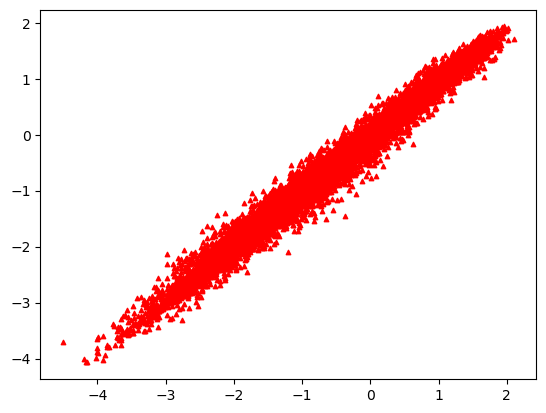

In [6]:
#sns.scatterplot(data=df_old, x=, y=)
x,y = df_old["LUMO"], df_old["LUMO_predicted"]
plt.scatter(x,y, s=10, marker='^', c='r')

In [7]:
## New:: 10,11,12,13,14 = aliphatic, 0,7=['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with both =O and O']
## Old:  90=PNL, 91=QM9 ring without N, 92=QM9 ring with N
display( df_new['type'].value_counts().sort_index(ascending=False), df_old['type'].value_counts().sort_index(ascending=False) )

type
14     429870
13      32865
12       1554
11         42
10          1
7        2509
6      378741
5      634777
4     2464902
3      317493
2        1013
1        1035
0      261855
Name: count, dtype: int64

type
92    9624
91    3382
90    2583
Name: count, dtype: int64

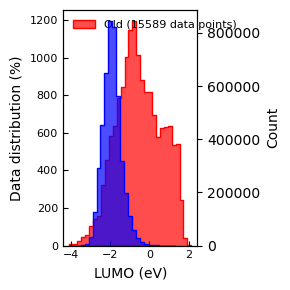

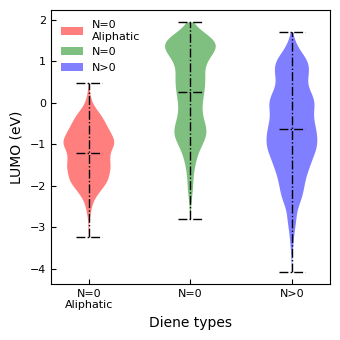

In [8]:
## New:: 10,11,12,13,14 = aliphatic, 0-7=['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with both =O and O']
## Old:  90=PNL, 91=QM9 ring without N, 92=QM9 ring with N

fig, axs = plt.subplots(1,1,figsize=(3.,3),tight_layout=True,dpi=100)
axt = axs.twinx()
#sns.histplot(df_pnl, x='LUMO', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.9, fill=True, color='k',label=f'DFT ({len(df_pnl)} data points)', stat='percent')
sns.histplot(df_old, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.7, fill=True, color='r',label=f'Old ({len(df_old)} data points)',)# stat='percent')
sns.histplot(df_new, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axt, element="step", alpha=0.7, fill=True, color='b',label=f'New ({len(df_new)} data points)',)# stat='percent')
axs.set_ylabel('Data distribution (%)', fontsize=10)
axs.set_xlabel('LUMO (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)
axs.legend(fontsize=8, frameon=False, loc=2)
#axs.set_ylim(top=18.5)
plt.show()
#plt.savefig("ML_prediction_compare_old_new.png", dpi=800)

fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,dpi=100)

names_new = ['Aliphatic']+['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with both =O and O']
cmap = plt.get_cmap('cool')
colors = cmap(np.linspace(0, 1, len(names_new)))
colors = ['r','g','b']
data_plot_old = [ df_old[df_old['type']==n] for n in [90,91,92] ]
data_plot_new = [ df_new[df_new['type']>9] ] + [ df_new[df_new['type']==n] for n in [0,1,2,3,4,5,6,7] ]
#sns.histplot(df1, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.9, fill=True, color='b',label=f'Old aliphatic ({len(df1)} data points)', stat='percent')
#sns.histplot(df2, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.7, fill=True, color='y',label=f'Old ring N=0 ({len(df2)} data points)', stat='percent')
#sns.histplot(df3, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.5, fill=True, color='g',label=f'Old ring N>0 ({len(df3)} data points)', stat='percent')
#sns.histplot(df4, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.3, fill=True, color='r',label=f'New aliphatic ({len(df4)} data points)', stat='percent')
#sns.histplot(df5, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.2, fill=True, color='c',label=f'New ring N>0 ({len(df5)} data points)', stat='percent')
#sns.violinplot(df1, x='LUMO_predicted', y='type', ax=axs)#kde=False, binwidth=0.2,  element="step", alpha=0.2, fill=True, color='c',label=f'New ring N>0 ({len(df5)} data points)', stat='percent')
parts = axs.violinplot( [ d['LUMO_predicted'] for d in data_plot_old ], showmeans=True)
for i,p in enumerate(parts['bodies']):
    p.set_facecolor(colors[i])
    p.set_edgecolor('None')
    p.set_alpha(0.5)
    #p.set_linewidth(0.1)
for k in ['cbars','cmins','cmaxes','cmeans']:
    parts[k].set_colors('k')    
    parts[k].set_linewidth(1)
    parts[k].set_linestyles('-.')
    
axs.set_xlabel('Diene types', fontsize=10)
axs.set_ylabel('LUMO (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)
axs.set_xticks( [n+1 for n in range(len(data_plot_old)) ] ,labels=['N=0\nAliphatic','N=0','N>0'])

axs.legend(labels=['N=0\nAliphatic','N=0','N>0'], fontsize=8, frameon=False, loc=2)
#axs.set_ylim(top=25)
plt.show()


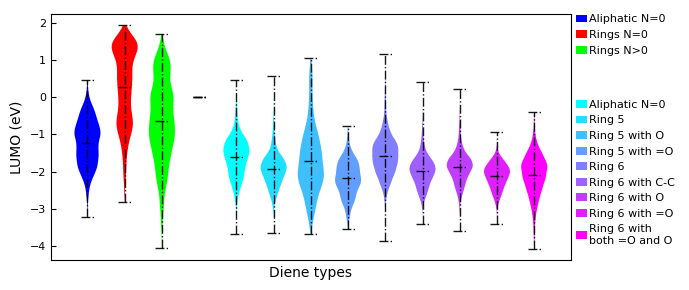

In [9]:
fig, axs = plt.subplots(1,1,figsize=(7,3),tight_layout=True,dpi=100)

data_plot_old = [ df_old[df_old['type']==n] for n in [90,91,92] ]
data_plot_new = [ df_new[df_new['type']>9] ] + [ df_new[df_new['type']==n] for n in [0,1,2,3,4,5,6,7] ]

names_new = ['Aliphatic N=0']+['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with \nboth =O and O']
cmap = plt.get_cmap('cool')
colors = cmap(np.linspace(0, 1, len(names_new)))
position = [n for n in range(len(colors))]

names_new = ['Aliphatic N=0','Rings N=0','Rings N>0'] +['\n\n']+names_new
cmap = plt.get_cmap('brg')
colors = np.concatenate( (cmap(np.linspace(0, 1, 3)), [[1.0, 1.0, 1.0, 1.0]], colors), axis=0)
position = [1,2,3,4] + [p+6 for p in position]

parts = axs.violinplot( [ d['LUMO_predicted'] for d in data_plot_old ]+[[0,0]]+[ d['LUMO_predicted'] for d in data_plot_new ], 
                       showmeans=True, widths=0.7)
for i,p in enumerate(parts['bodies']):
    p.set_facecolor(colors[i])
    p.set_edgecolor('None')
    p.set_alpha(1)
    #p.set_linewidth(0.1)
for k in ['cbars','cmins','cmaxes','cmeans']:
    parts[k].set_colors('k')    
    parts[k].set_linewidth(1)
    parts[k].set_linestyles('-.')
    parts[k].set_alpha(0.9)
    
axs.set_xlabel('Diene types', fontsize=10)
axs.set_ylabel('LUMO (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)
axs.set_xticks( [] )
axs.set_xticklabels([])
axs.legend(labels=names_new, fontsize=8, frameon=False, ncol=1, loc=1, 
           bbox_to_anchor=(1.22,1.04), handlelength=1, handletextpad=0.2, columnspacing=1)
#axs.set_xlim(right=10)
#plt.subplots_adjust(wspace=0, hspace=0.0)
plt.savefig("Prediction_LUMO_distribution.png", dpi=800)  
plt.show()

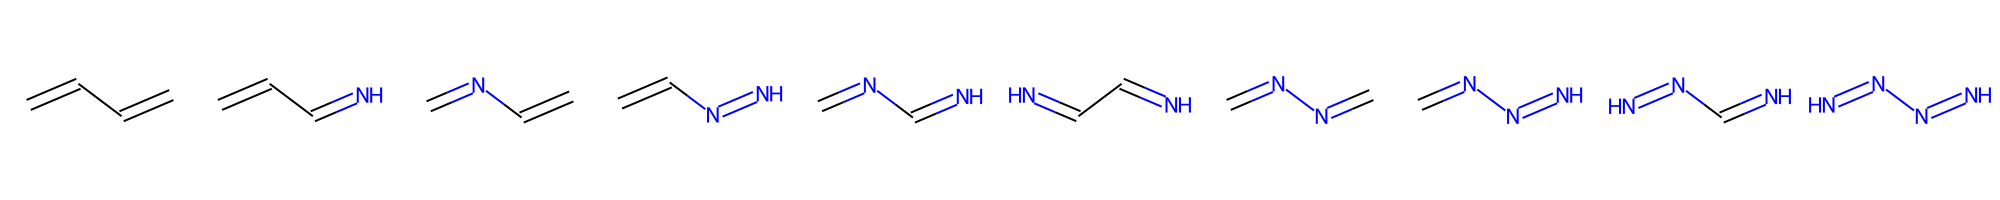

In [4]:
## Generate the product
def has_substructure(smi, sub_struct=None):
    if sub_struct is None:
        sub_struct = ['C=CC=C']
    mol = Chem.MolFromSmiles(smi) 
    if mol is None:
        match = False
    else:
        mol = Chem.RemoveHs( mol )
        Chem.Kekulize(mol)
        if any([mol.HasSubstructMatch( Chem.MolFromSmiles(s) ) for s in sub_struct]):
            match = True
        else:
            match = False
    return match

def replace_substructure(base_smi, replace_smi, add_smi):
    mol = Chem.ReplaceSubstructs(Chem.MolFromSmiles(base_smi), 
                                 Chem.MolFromSmiles(replace_smi), 
                                 Chem.MolFromSmiles(add_smi),
                                 replaceAll=False)
    smi = [ Chem.MolToSmiles(m, canonical=True, isomericSmiles=True) for m in mol ]
    smi = list(set(smi))
    if base_smi in smi:
        smi.remove(base_smi)
    return smi

def make_poduct(smi, patterns):    
    mol = Chem.MolFromSmiles(smi) 
    mol = Chem.RemoveHs( mol )
    Chem.Kekulize(mol)
    mol = Chem.RWMol(mol)
    
    m = [ i for i,p in enumerate(patterns) if has_substructure(smi, sub_struct=[p]) ]
    m = np.amax(m)
    matches = mol.GetSubstructMatches( Chem.MolFromSmiles(patterns[m]) )
    #print(matches)
    m = list(matches[0])
    img1 = Draw.MolToImage(mol, highlightAtoms=m, kekulize=True)
    
    new_bond_single = Chem.BondType.SINGLE
    new_bond_double = Chem.BondType.DOUBLE

    bond = mol.GetBondBetweenAtoms(m[0],m[1])
    bond.SetBondType( new_bond_single )
    bond = mol.GetBondBetweenAtoms(m[1],m[2])
    bond.SetBondType( new_bond_double )
    bond = mol.GetBondBetweenAtoms(m[2],m[3])
    bond.SetBondType( new_bond_single )

    new_atom_index1 = mol.AddAtom(Chem.Atom("C"))
    mol.AddBond(m[0], new_atom_index1, new_bond_single)
    new_atom_index2 = mol.AddAtom(Chem.Atom("O"))
    mol.AddBond(m[3], new_atom_index2, new_bond_single)
    mol.AddBond(new_atom_index1, new_atom_index2, new_bond_single)
    new_atom_index3 = mol.AddAtom(Chem.Atom("O"))
    mol.AddBond(new_atom_index1, new_atom_index3, new_bond_double)

    Chem.AllChem.Compute2DCoords(mol)
    
    new_smiles = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=True)
    
    img2 = Draw.MolToImage(mol, highlightAtoms=m, kekulize=True)
    #display( smi, new_smiles, img1, img2 )
    
    return new_smiles


patterns = ['C=CC=C','N=CC=C','C=NC=C','N=NC=C','N=CN=C','N=CC=N','C=NN=C','N=NN=C','N=NC=N','N=NN=N']
img1 = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in patterns], molsPerRow=10,  )
img1

In [13]:
## For each type, get the best 10
names_new = ['Aliphatic N=0']+['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with both =O and O']

selected_dienes = []
for d,m in zip(data_plot_new,names_new):
    d =d.sort_values(by='LUMO_predicted',ascending=True).head(10) 
    d = d[['SMILES','LUMO_predicted']]
    d['Type'] = m
    products = [ make_poduct(s, patterns) for s in d['SMILES'] ]
    d['Product'] = products
    selected_dienes.append(d)
selected_dienes = pd.concat(selected_dienes,axis=0).reset_index()
selected_dienes.to_csv('new_selected_dienes.csv')

for i,s in zip(selected_dienes.index, selected_dienes['SMILES']):
    smiles_to_xyz_pybel(s, if_write_xyz=f'xyz_selected_dienes/selected_dienes_{i}.xyz', if_overwrite=True) 

for i,s in zip(selected_dienes.index, selected_dienes['Product']):
    smiles_to_xyz_pybel(s, if_write_xyz=f'xyz_selected_dienes/product_selected_dienes_{i}.xyz', if_overwrite=True) 

In [14]:
d = data_plot_old[2][['SMILES','LUMO','LUMO_predicted']].sort_values(by='LUMO_predicted',ascending=True).head(10).reset_index()
products = [ make_poduct(s, patterns) for s in d['SMILES'] ]
d['Product'] = products
d.to_csv('old_selected_dienes.csv')

for i,s in zip(d.index, d['SMILES']):
    smiles_to_xyz_pybel(s, if_write_xyz=f'xyz_selected_dienes/old_selected_dienes_{i}.xyz', if_overwrite=True) 
for i,s in zip(d.index, d['Product']):
    smiles_to_xyz_pybel(s, if_write_xyz=f'xyz_selected_dienes/product_old_selected_dienes_{i}.xyz', if_overwrite=True) 

In [5]:
## Read the DFT LUMO energies from file
df_selected_old = pd.read_csv('old_selected_dienes.csv', index_col=0)
df_selected_new = pd.read_csv('new_selected_dienes.csv', index_col=0)
dft_old1 = pd.read_csv('df_diene_old_lumo.csv', index_col=0)
dft_new1 = pd.read_csv('df_diene_new_lumo.csv', index_col=0)
dft_old2 = pd.read_csv('df_product_old_lumo.csv', index_col=0)
dft_new2 = pd.read_csv('df_product_new_lumo.csv', index_col=0)

dft_old1 = dft_old1.rename( columns={c:c+'_reactant' for c in dft_old1.columns} )
dft_new1 = dft_new1.rename( columns={c:c+'_reactant' for c in dft_new1.columns} )
dft_old2 = dft_old2.rename( columns={c:c+'_product' for c in dft_old2.columns} )
dft_new2 = dft_new2.rename( columns={c:c+'_product' for c in dft_new2.columns} )

df_selected_old = pd.concat( [df_selected_old, dft_old1, dft_old2], axis=1)
df_selected_new = pd.concat( [df_selected_new, dft_new1, dft_new2], axis=1)

df_selected_old = df_selected_old.sort_values(by='LUMO_DFT(eV)_reactant',ascending=True)
df_selected_new = df_selected_new.sort_values(by='LUMO_DFT(eV)_reactant',ascending=True)

display(df_selected_old,df_selected_new)

index           SMILES  LUMO  LUMO_predicted                     Product  \
3  21284  O=c1oncc(n1)C#N -4.20           -4.00       N#Cc1cn2oc(=O)n1OC2=O   
1  21290    O=c1oncnc1C#N -4.17           -4.06     N#Cc12ncn(oc1=O)C(=O)O2   
0  21191  O=C(C#N)n1nnnn1 -4.15           -4.07     N#CC(=O)n1n2nnn1C(=O)O2   
4  21293  O=c1onnc(c1)C#N -4.02           -3.98       N#Cc1nn2oc(=O)c1OC2=O   
8  21369  O=Cc1nc(=O)onc1 -4.01           -3.82     O=Cc1cn2OC(=O)n1c(=O)o2   
7  22218  O=N(=O)c1cnnnn1 -4.01           -3.87  O=C1On2nnn1cc2[N+](=O)[O-]   
6  21277  O=c1onc(cn1)C#N -3.99           -3.90       N#Cc1cn2OC(=O)n1oc2=O   
5  21279  O=c1onc(nc1)C#N -3.88           -3.93       N#Cc1nc2OC(=O)n1oc2=O   
2  21184  O=C(C#N)c1nonn1 -3.91           -4.03       N#CC(=O)c1nn2on1OC2=O   
9  21173  O=C(C#N)c1cnno1 -3.86           -3.79   N#CC(=O)c12cnn(o1)C(=O)O2   

   E_DFT(eV)_reactant  LUMO_DFT(eV)_reactant  HOMO_DFT(eV)_reactant  \
3           -12713.72                  -4.25                  -8.89   
1           -12713.68                  -4.24                  -8.69   
0           -13045.07                  -4.15                  -9.99   
4           -12713.32                  -4.09                  -8.91   
8           -13287.39                  -4.06                  -8.27   
7           -13615.86                  -4.04                  -8.54   
6           -12713.73                  -4.03                  -8.87   
5           -12713.63                  -3.94                  -8.67   
2           -13148.82                  -3.93                  -9.76   
9           -12713.47                  -3.89                  -9.31   

   E_DFT(eV)_product  LUMO_DFT(eV)_product  HOMO_DFT(eV)_product  
3          -17838.51                 -3.74                 -9.26  
1          -17840.00                 -3.43                 -9.02  
0          -18172.24                 -3.64                 -8.63  
4          -17839.50                 -4.04                 -8.99  
8          -18412.17                 -3.46                 -8.50  
7          -18744.38                 -4.08                 -8.89  
6          -17838.51                 -3.74                 -9.26  
5          -17840.22                 -3.96                 -8.93  
2          -18272.39                 -4.71                 -9.56  
9          -17838.65                 -3.91                 -9.19

index                                       SMILES  LUMO_predicted  \
75   201442    N#CC1=NC(C#N)([N+](=O)[O-])C(=O)C(C#N)=N1           -3.40   
34      199                 N#CC1=NN=C([N+](=O)[O-])C1=O           -3.38   
39      195                          N#CC1=NN=C(C#N)C1=O           -3.31   
77    66307         N#CC1=NC(=O)C(C#N)([N+](=O)[O-])N=N1           -3.40   
37      608                        N#CC1=NC(=O)C(C#N)=N1           -3.33   
..      ...                                          ...             ...   
54  1272166  CSC1=NC(C#N)=NCC1([N+](=O)[O-])[N+](=O)[O-]           -3.38   
23      157                              N#Cc1nnc(C=O)o1           -3.57   
14     4927                   N=NC1([N+](=O)[O-])N=NN=N1           -3.46   
12     4865                   O=CC1([N+](=O)[O-])N=NN=N1           -3.48   
88        9                                   O=c1nnnno1           -3.90   

                         Type  \
75             Ring 6 with =O   
34             Ring 5 with =O   
39             Ring 5 with =O   
77             Ring 6 with =O   
37             Ring 5 with =O   
..                        ...   
54            Ring 6 with C-C   
23              Ring 5 with O   
14                     Ring 5   
12                     Ring 5   
88  Ring 6 with both =O and O   

                                              Product  E_DFT(eV)_reactant  \
75     N#CC1=NC2(C#N)OC(=O)N1C(C#N)([N+](=O)[O-])C2=O           -22312.47   
34                N#CC12N=NC([N+](=O)[O-])(OC1=O)C2=O           -16227.99   
39                       N#CC12N=NC(C#N)(C(=O)O1)C2=O           -13175.39   
77          N#CC1=NN2C(=O)ON1C(=O)C2(C#N)[N+](=O)[O-]           -20240.33   
37                         N#CC1=NC2(C#N)OC(=O)N1C2=O           -13176.48   
..                                                ...                 ...   
54  CSC12N=C(C#N)N(CC1([N+](=O)[O-])[N+](=O)[O-])C...           -32746.90   
23                            N#Cc12nnc(C=O)(OC1=O)o2           -12714.25   
14                  N=NC1([N+](=O)[O-])N2N=NN1C(=O)O2           -15555.71   
12                  O=CC1([N+](=O)[O-])N2N=NN1C(=O)O2           -15663.50   
88                                 O=C1On2nnn1c(=O)o2           -11083.25   

    LUMO_DFT(eV)_reactant  HOMO_DFT(eV)_reactant  E_DFT(eV)_product  \
75                  -5.66                  -9.22          -27439.08   
34                  -5.61                  -9.28          -21355.13   
39                  -5.52                  -9.16          -18302.21   
77                  -5.48                  -8.88          -25365.50   
37                  -5.39                  -9.54          -18302.74   
..                    ...                    ...                ...   
54                  -3.41                  -7.93          -37873.41   
23                  -3.40                  -8.85          -17839.93   
14                  -3.31                  -7.63          -20680.58   
12                  -3.11                  -8.39          -20785.83   
88                  -0.49                 -10.49          -16201.82   

    LUMO_DFT(eV)_product  HOMO_DFT(eV)_product  
75                 -4.37                 -9.43  
34                 -3.89                 -9.16  
39                 -3.88                 -9.02  
77                 -4.47                 -9.21  
37                 -3.98                 -9.77  
..                   ...                   ...  
54                 -3.66                 -7.77  
23                 -3.28                 -8.70  
14                 -3.67                 -8.74  
12                 -3.63                 -9.39  
88                 -3.76                 -9.22  

[90 rows x 11 columns]

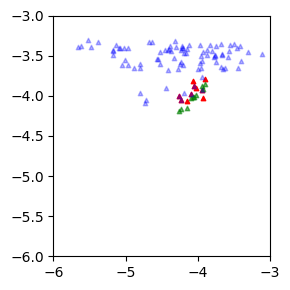

In [6]:
fig, axs = plt.subplots(1,1,figsize=(3,3),tight_layout=True,dpi=100)
#sns.scatterplot(data=df_selected_new, x="LUMO_predicted", y="LUMO_DFT")
axs.scatter( df_selected_old["LUMO_DFT(eV)_reactant"], df_selected_old["LUMO_predicted"], s=10, marker='^', c='r')
axs.scatter( df_selected_old["LUMO_DFT(eV)_reactant"], df_selected_old["LUMO"], s=10, marker='^', c='g', alpha=0.6)
axs.scatter( df_selected_new["LUMO_DFT(eV)_reactant"], df_selected_new["LUMO_predicted"], s=10, marker='^', c='b', alpha=0.3)

axs.set_xlim( (-6,-3) )
axs.set_ylim( (-6,-3) )
#display(df_selected_old,df_selected_new)
plt.show()

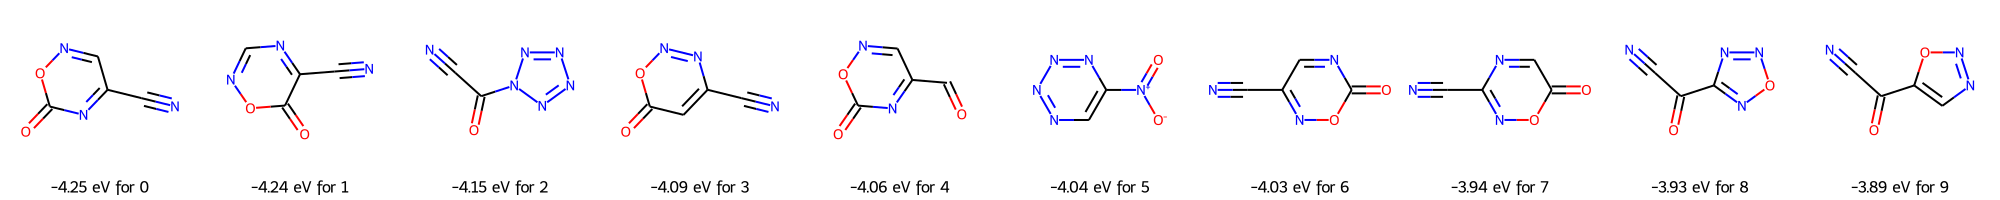

In [7]:
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df_selected_old['SMILES']], 
                           molsPerRow=10, subImgSize=(200, 200), returnPNG=False, 
                           legends=[str(round(e,2))+' eV for '+str(i) for i,e in enumerate(df_selected_old['LUMO_DFT(eV)_reactant']) ] )  
#img.save('df_selected_old.png')
display(img)

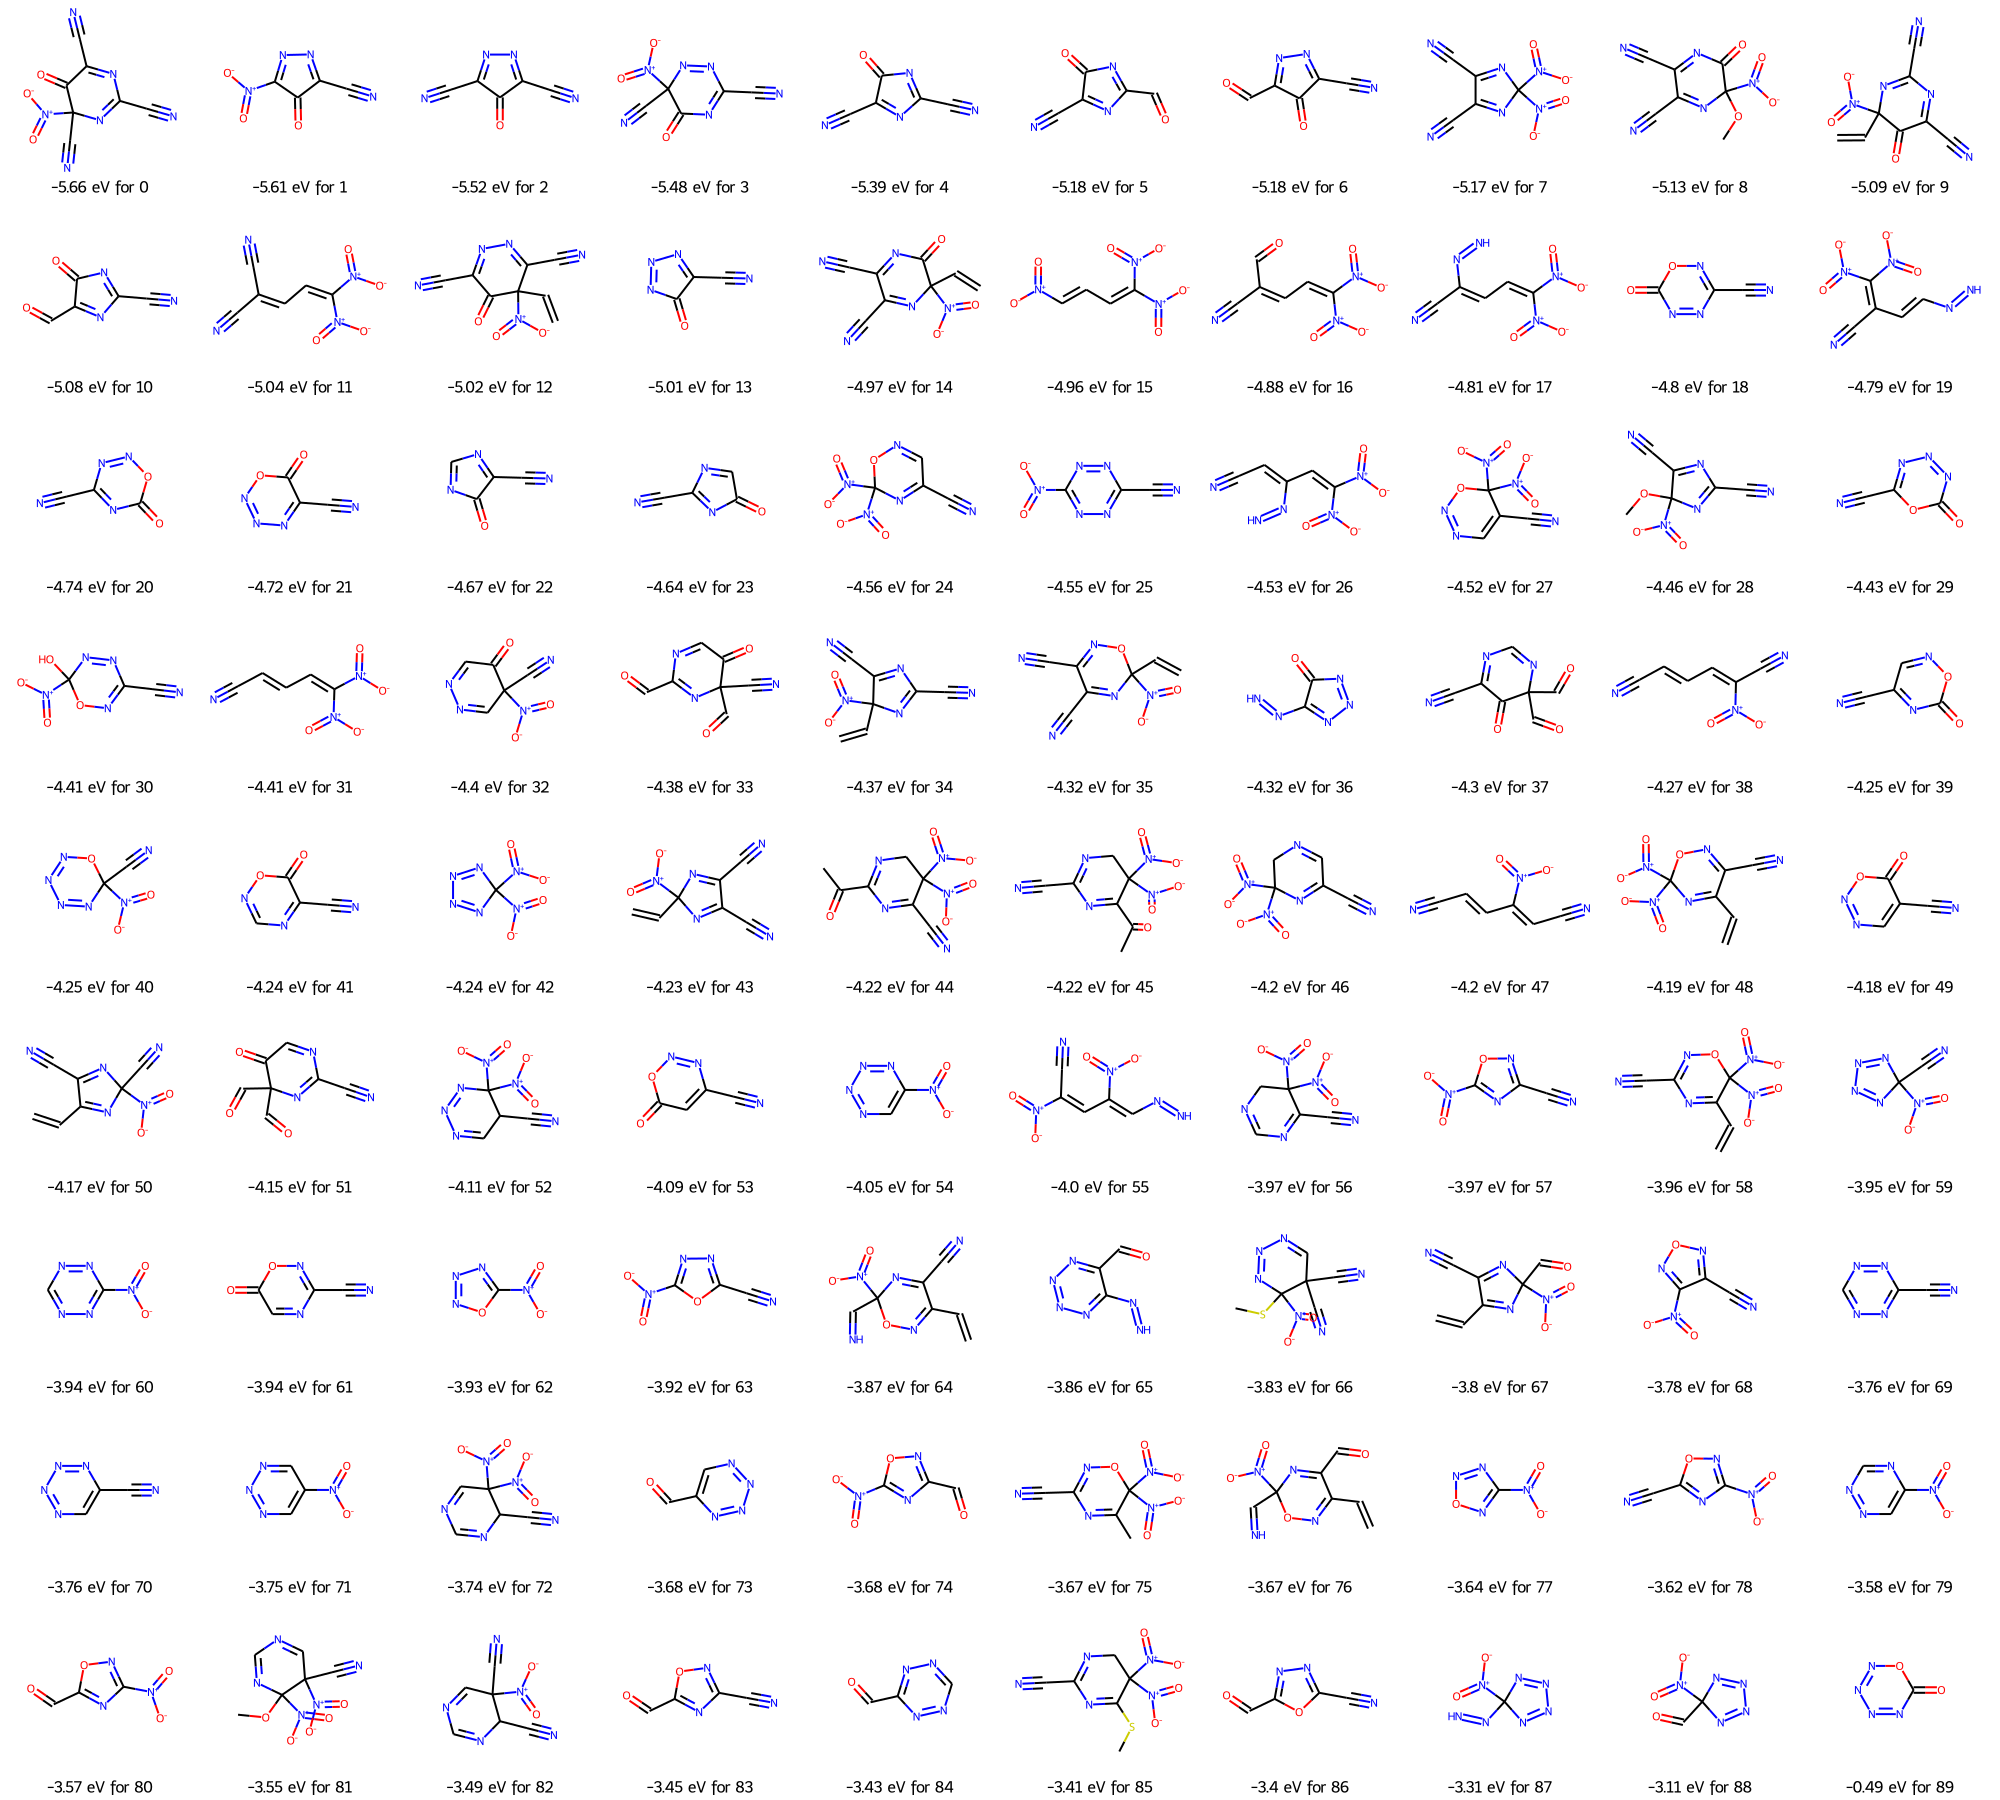

In [8]:
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df_selected_new['SMILES']], 
                           molsPerRow=10, subImgSize=(200, 200), returnPNG=False, maxMols =100,
                           legends=[str(round(e,2))+' eV for '+str(i) for i,e in enumerate(df_selected_new['LUMO_DFT(eV)_reactant']) ] )  
#img.save('df_selected_old.png')
display(img)

['O=[N+]([O-])c1cnncn1', 'O=C1On2cnn1cc2[N+](=O)[O-]']
[8, 7, 6, 5]


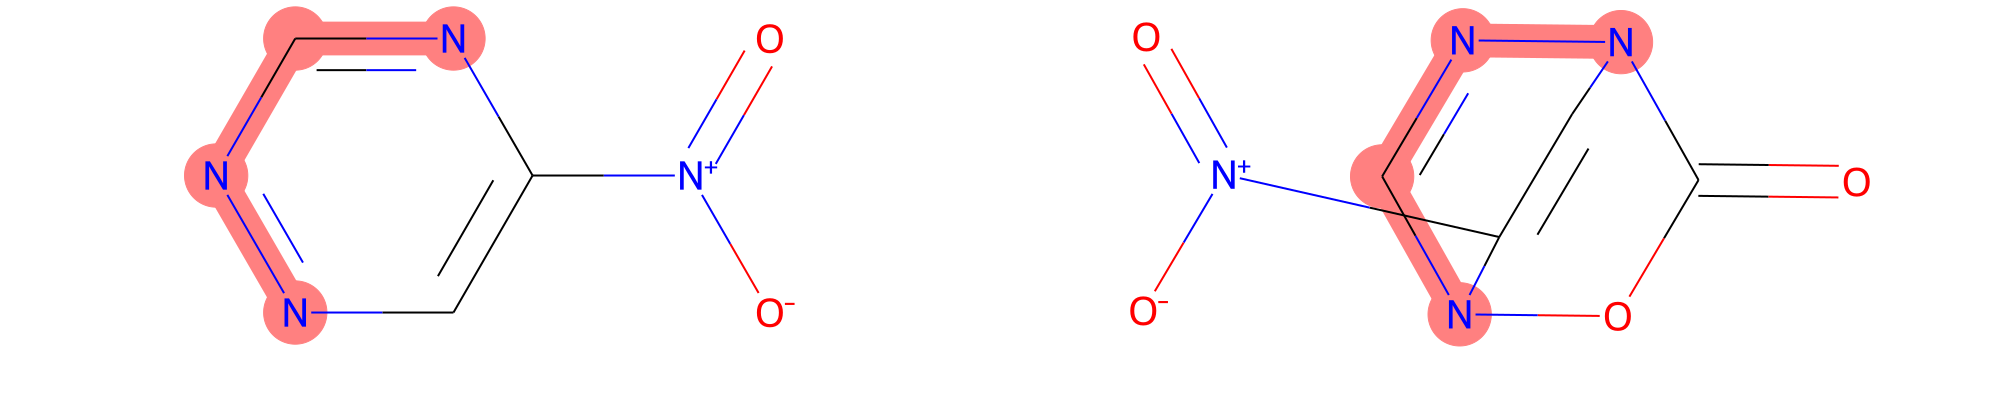

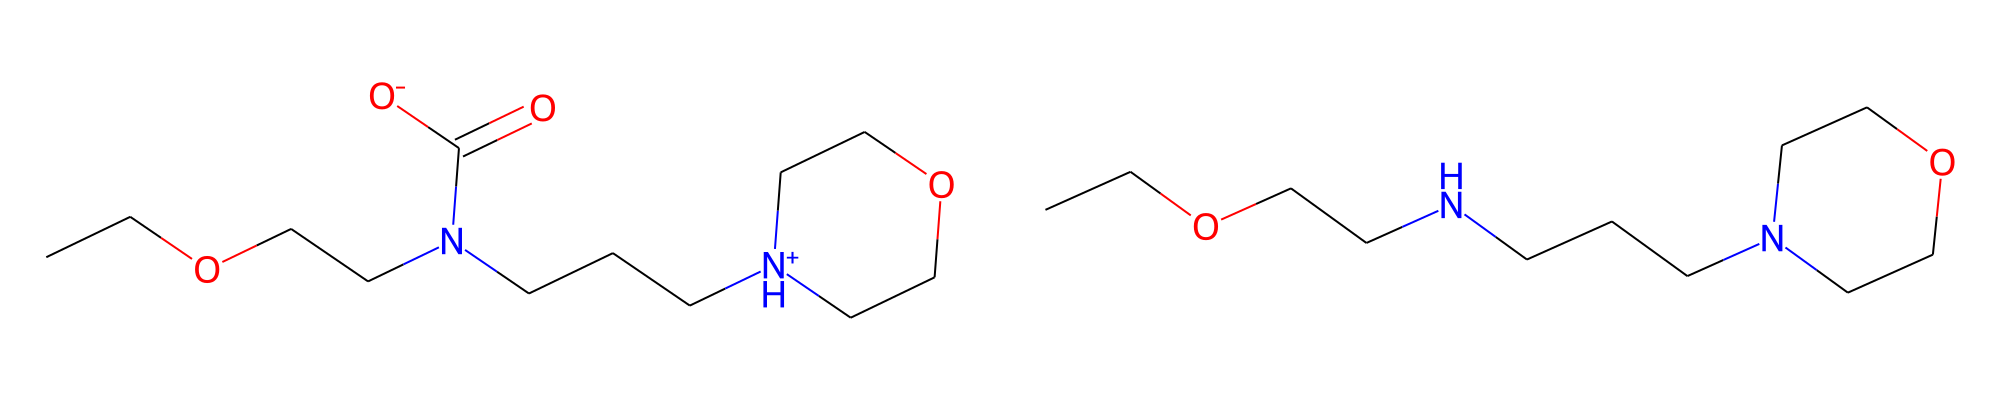

In [9]:
ss = list( df_selected_new.iloc[79][ ['SMILES','Product'] ] )
print(ss)

mol = Chem.RWMol( Chem.MolFromSmiles(ss[0]) )
Chem.Kekulize(mol)
matches1 = list(mol.GetSubstructMatches( Chem.MolFromSmiles('N=CN=N') )[0])
print(matches1)
'''
mol = Chem.RWMol( Chem.MolFromSmiles(ss[1]) )
Chem.Kekulize(mol)
matches2 = list(mol.GetSubstructMatches( Chem.MolFromSmiles('CN=NC') )[0])
print(matches2)
'''
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in ss],                            
                     molsPerRow=2, subImgSize=(1000, 400), returnPNG=False, #explicitOnly=True,
                     highlightAtomLists=[matches1, [3,4,5,6]] )
display( img )
img.save('snapshot_example_diene.png')

#img = Draw.MolToImage(Chem.MolFromSmiles(ss[1]), kekulize=True, wedgeBonds=True, explicitOnly=True)
#display( img )

eempas = ['CCOCCN(CCC[NH+]1CCOCC1)C(=O)[O-]','CCOCCNCCCN1CCOCC1']
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in eempas],                            
                     molsPerRow=2, subImgSize=(1000, 400), returnPNG=False)
display( img )
img.save('snapshot_EEMPA.png')


In [10]:
E_eempa= -18854.64909
E_eempa_COOH= -23982.88526
E_eempa_COO_H_zwt= -23982.2908

E_reaction_old = (df_selected_old['E_DFT(eV)_product'] + E_eempa)-(df_selected_old['E_DFT(eV)_reactant'] + E_eempa_COO_H_zwt)
df_selected_old['Reaction'] = E_reaction_old
E_reaction_new = (df_selected_new['E_DFT(eV)_product'] + E_eempa)-(df_selected_new['E_DFT(eV)_reactant'] + E_eempa_COO_H_zwt)
df_selected_new['Reaction'] = E_reaction_new

display(df_selected_old, df_selected_new)

index           SMILES  LUMO  LUMO_predicted                     Product  \
3  21284  O=c1oncc(n1)C#N -4.20           -4.00       N#Cc1cn2oc(=O)n1OC2=O   
1  21290    O=c1oncnc1C#N -4.17           -4.06     N#Cc12ncn(oc1=O)C(=O)O2   
0  21191  O=C(C#N)n1nnnn1 -4.15           -4.07     N#CC(=O)n1n2nnn1C(=O)O2   
4  21293  O=c1onnc(c1)C#N -4.02           -3.98       N#Cc1nn2oc(=O)c1OC2=O   
8  21369  O=Cc1nc(=O)onc1 -4.01           -3.82     O=Cc1cn2OC(=O)n1c(=O)o2   
7  22218  O=N(=O)c1cnnnn1 -4.01           -3.87  O=C1On2nnn1cc2[N+](=O)[O-]   
6  21277  O=c1onc(cn1)C#N -3.99           -3.90       N#Cc1cn2OC(=O)n1oc2=O   
5  21279  O=c1onc(nc1)C#N -3.88           -3.93       N#Cc1nc2OC(=O)n1oc2=O   
2  21184  O=C(C#N)c1nonn1 -3.91           -4.03       N#CC(=O)c1nn2on1OC2=O   
9  21173  O=C(C#N)c1cnno1 -3.86           -3.79   N#CC(=O)c12cnn(o1)C(=O)O2   

   E_DFT(eV)_reactant  LUMO_DFT(eV)_reactant  HOMO_DFT(eV)_reactant  \
3           -12713.72                  -4.25                  -8.89   
1           -12713.68                  -4.24                  -8.69   
0           -13045.07                  -4.15                  -9.99   
4           -12713.32                  -4.09                  -8.91   
8           -13287.39                  -4.06                  -8.27   
7           -13615.86                  -4.04                  -8.54   
6           -12713.73                  -4.03                  -8.87   
5           -12713.63                  -3.94                  -8.67   
2           -13148.82                  -3.93                  -9.76   
9           -12713.47                  -3.89                  -9.31   

   E_DFT(eV)_product  LUMO_DFT(eV)_product  HOMO_DFT(eV)_product  Reaction  
3          -17838.51                 -3.74                 -9.26      2.85  
1          -17840.00                 -3.43                 -9.02      1.32  
0          -18172.24                 -3.64                 -8.63      0.46  
4          -17839.50                 -4.04                 -8.99      1.46  
8          -18412.17                 -3.46                 -8.50      2.86  
7          -18744.38                 -4.08                 -8.89     -0.87  
6          -17838.51                 -3.74                 -9.26      2.86  
5          -17840.22                 -3.96                 -8.93      1.05  
2          -18272.39                 -4.71                 -9.56      4.07  
9          -17838.65                 -3.91                 -9.19      2.47

index                                       SMILES  LUMO_predicted  \
75   201442    N#CC1=NC(C#N)([N+](=O)[O-])C(=O)C(C#N)=N1           -3.40   
34      199                 N#CC1=NN=C([N+](=O)[O-])C1=O           -3.38   
39      195                          N#CC1=NN=C(C#N)C1=O           -3.31   
77    66307         N#CC1=NC(=O)C(C#N)([N+](=O)[O-])N=N1           -3.40   
37      608                        N#CC1=NC(=O)C(C#N)=N1           -3.33   
..      ...                                          ...             ...   
54  1272166  CSC1=NC(C#N)=NCC1([N+](=O)[O-])[N+](=O)[O-]           -3.38   
23      157                              N#Cc1nnc(C=O)o1           -3.57   
14     4927                   N=NC1([N+](=O)[O-])N=NN=N1           -3.46   
12     4865                   O=CC1([N+](=O)[O-])N=NN=N1           -3.48   
88        9                                   O=c1nnnno1           -3.90   

                         Type  \
75             Ring 6 with =O   
34             Ring 5 with =O   
39             Ring 5 with =O   
77             Ring 6 with =O   
37             Ring 5 with =O   
..                        ...   
54            Ring 6 with C-C   
23              Ring 5 with O   
14                     Ring 5   
12                     Ring 5   
88  Ring 6 with both =O and O   

                                              Product  E_DFT(eV)_reactant  \
75     N#CC1=NC2(C#N)OC(=O)N1C(C#N)([N+](=O)[O-])C2=O           -22312.47   
34                N#CC12N=NC([N+](=O)[O-])(OC1=O)C2=O           -16227.99   
39                       N#CC12N=NC(C#N)(C(=O)O1)C2=O           -13175.39   
77          N#CC1=NN2C(=O)ON1C(=O)C2(C#N)[N+](=O)[O-]           -20240.33   
37                         N#CC1=NC2(C#N)OC(=O)N1C2=O           -13176.48   
..                                                ...                 ...   
54  CSC12N=C(C#N)N(CC1([N+](=O)[O-])[N+](=O)[O-])C...           -32746.90   
23                            N#Cc12nnc(C=O)(OC1=O)o2           -12714.25   
14                  N=NC1([N+](=O)[O-])N2N=NN1C(=O)O2           -15555.71   
12                  O=CC1([N+](=O)[O-])N2N=NN1C(=O)O2           -15663.50   
88                                 O=C1On2nnn1c(=O)o2           -11083.25   

    LUMO_DFT(eV)_reactant  HOMO_DFT(eV)_reactant  E_DFT(eV)_product  \
75                  -5.66                  -9.22          -27439.08   
34                  -5.61                  -9.28          -21355.13   
39                  -5.52                  -9.16          -18302.21   
77                  -5.48                  -8.88          -25365.50   
37                  -5.39                  -9.54          -18302.74   
..                    ...                    ...                ...   
54                  -3.41                  -7.93          -37873.41   
23                  -3.40                  -8.85          -17839.93   
14                  -3.31                  -7.63          -20680.58   
12                  -3.11                  -8.39          -20785.83   
88                  -0.49                 -10.49          -16201.82   

    LUMO_DFT(eV)_product  HOMO_DFT(eV)_product  Reaction  
75                 -4.37                 -9.43      1.03  
34                 -3.89                 -9.16      0.50  
39                 -3.88                 -9.02      0.82  
77                 -4.47                 -9.21      2.47  
37                 -3.98                 -9.77      1.38  
..                   ...                   ...       ...  
54                 -3.66                 -7.77      1.13  
23                 -3.28                 -8.70      1.97  
14                 -3.67                 -8.74      2.77  
12                 -3.63                 -9.39      5.30  
88                 -3.76                 -9.22      9.08  

[90 rows x 12 columns]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

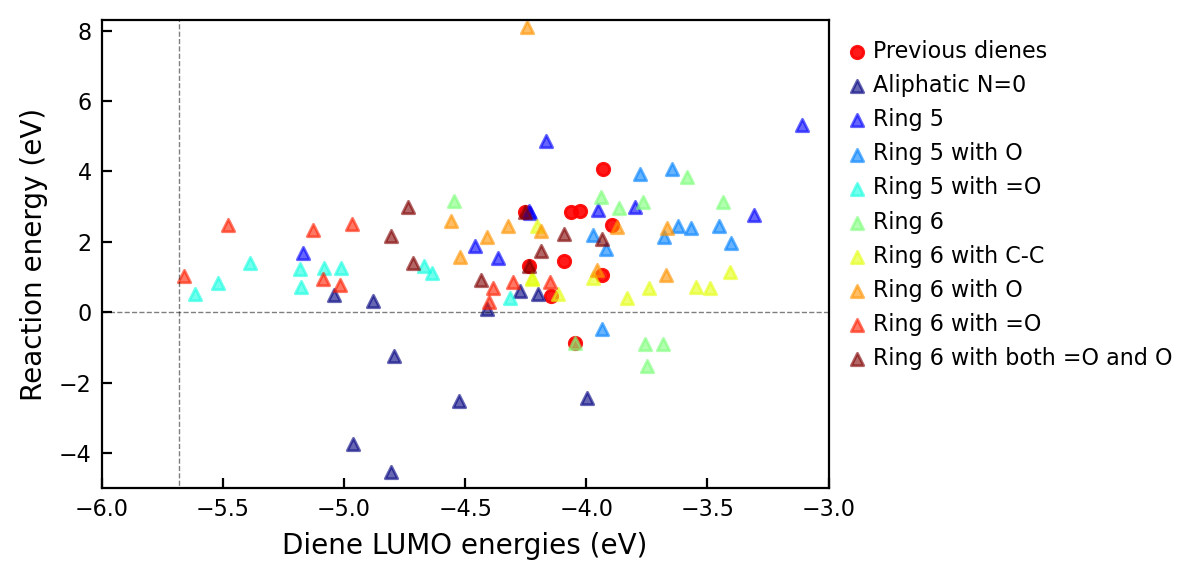

In [40]:
fig, axs = plt.subplots(1,1,figsize=(7,3),tight_layout=True,dpi=200)

#names = list(df_selected_new['Type'].value_counts().index)
names = ['Aliphatic N=0']+['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with both =O and O']
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, len(names)))
colors = {m:c for m,c in zip(names,colors) }
#colors = [ colors[t] for t in df_selected_new['Type'] ]

axs.scatter( df_selected_old["LUMO_DFT(eV)_reactant"], df_selected_old["Reaction"], s=20, marker='o', c='r', alpha=0.9, label='Previous dienes')
for m in names:
    df = df_selected_new[ df_selected_new['Type']==m ]
    axs.scatter( df["LUMO_DFT(eV)_reactant"], df["Reaction"], s=20, marker='^', c=colors[m], alpha=0.6, label=m)

axs.set_xlabel('Diene LUMO energies (eV)', fontsize=10)
axs.set_ylabel('Reaction energy (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)
#axs.set_xticks( [] ) axs.set_xticklabels([])
axs.legend( fontsize=8, frameon=False, ncol=1, loc=1, #labels=['Previous dienes','New dienes'], 
           handlelength=1, handletextpad=0.2, columnspacing=1, bbox_to_anchor=(1.5,1) )
axs.set_xlim( (-6,-3) )
axs.set_ylim( (-5,8.3) )

axs.plot( [-100,100],[0,0], '--', color='k', lw=0.5, alpha=0.5)
axs.plot( [-5.68, -5.68],[-100,100], '--', color='k', lw=0.5, alpha=0.5)
#plt.savefig("Selected_new_dienes.png", dpi=800)  
plt.show()


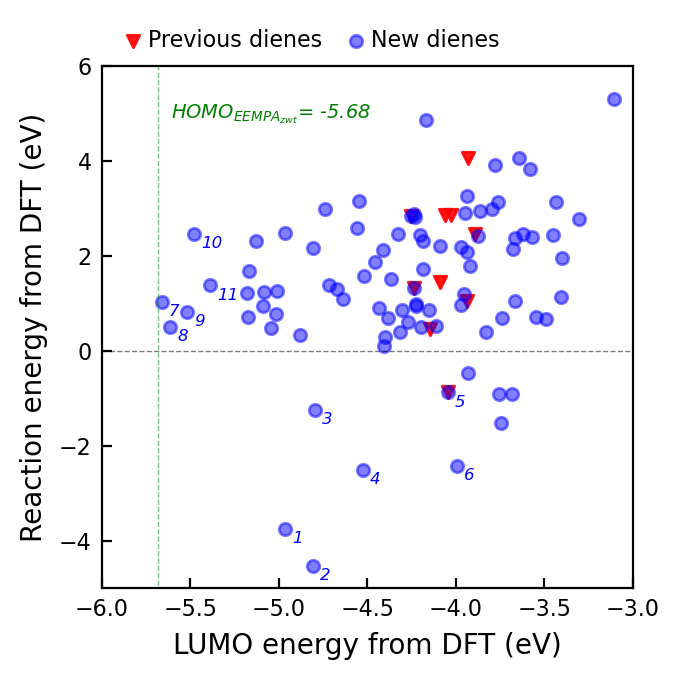

index                                        SMILES  LUMO_predicted  \
5    32891  O=[N+]([O-])C=CC=C([N+](=O)[O-])[N+](=O)[O-]           -3.62   
9   423776      N#CC(=CC=C([N+](=O)[O-])[N+](=O)[O-])N=N           -3.60   
4   421677      N#CC(C=CN=N)=C([N+](=O)[O-])[N+](=O)[O-]           -3.65   
8   423775      N#CC=C(C=C([N+](=O)[O-])[N+](=O)[O-])N=N           -3.61   
40     269                          O=[N+]([O-])c1cnnnn1           -3.87   
2   423892      N#CC(=CC(=CN=N)[N+](=O)[O-])[N+](=O)[O-]           -3.66   
24     101                           O=[N+]([O-])c1nnno1           -3.56   
47     265                                   N#Cc1cnnnn1           -3.50   
44     161                          O=[N+]([O-])c1cnnnc1           -3.58   
43     261                                   O=Cc1cnnnn1           -3.64   

             Type                                            Product  \
5   Aliphatic N=0  O=C1OC([N+](=O)[O-])([N+](=O)[O-])C=CC1[N+](=O...   
9   Aliphatic N=0      N#CC1=NNC(=O)OC1C=C([N+](=O)[O-])[N+](=O)[O-]   
4   Aliphatic N=0    N#CC(=C([N+](=O)[O-])[N+](=O)[O-])C1C=NNC(=O)O1   
8   Aliphatic N=0      N#CC1OC(=O)NN=C1C=C([N+](=O)[O-])[N+](=O)[O-]   
40         Ring 6                         O=C1On2nnn1cc2[N+](=O)[O-]   
2   Aliphatic N=0    N#CC(=CC1([N+](=O)[O-])C=NNC(=O)O1)[N+](=O)[O-]   
24  Ring 5 with O                        O=C1Oc2([N+](=O)[O-])nnn1o2   
47         Ring 6                                  N#Cc1cn2nnn1OC2=O   
44         Ring 6                         O=C1Oc2nnn1cc2[N+](=O)[O-]   
43         Ring 6                                  O=Cc1cn2nnn1OC2=O   

    E_DFT(eV)_reactant  LUMO_DFT(eV)_reactant  HOMO_DFT(eV)_reactant  \
5            -20917.90                  -4.96                  -6.16   
9            -20840.55                  -4.81                  -6.02   
4            -20843.47                  -4.79                  -7.85   
8            -20842.64                  -4.53                  -5.95   
40           -13615.86                  -4.05                  -8.54   
2            -20842.75                  -4.00                  -6.59   
24           -13120.86                  -3.93                  -9.88   
47           -10562.99                  -3.76                  -8.33   
44           -13180.72                  -3.75                  -8.20   
43           -11136.41                  -3.68                  -7.90   

    E_DFT(eV)_product  LUMO_DFT(eV)_product  HOMO_DFT(eV)_product  Reaction  
5           -26049.29                 -3.22                 -9.24     -3.76  
9           -25972.72                 -3.80                 -8.54     -4.53  
4           -25972.35                 -4.36                 -8.30     -1.24  
8           -25972.79                 -4.09                 -8.47     -2.51  
40          -18744.38                 -4.08                 -8.88     -0.87  
2           -25972.82                 -4.08                 -8.42     -2.43  
24          -18248.96                 -3.38                 -8.96     -0.46  
47          -15691.55                 -3.93                 -8.80     -0.91  
44          -18309.88                 -3.15                 -8.60     -1.52  
43          -16264.96                 -3.80                 -8.32     -0.91

index                                        SMILES  LUMO_predicted  \
75  201442     N#CC1=NC(C#N)([N+](=O)[O-])C(=O)C(C#N)=N1           -3.40   
34     199                  N#CC1=NN=C([N+](=O)[O-])C1=O           -3.38   
39     195                           N#CC1=NN=C(C#N)C1=O           -3.31   
77   66307          N#CC1=NC(=O)C(C#N)([N+](=O)[O-])N=N1           -3.40   
37     608                         N#CC1=NC(=O)C(C#N)=N1           -3.33   
31     543                           N#CC1=NC(C=O)=NC1=O           -3.49   
32     157                           N#CC1=NN=C(C=O)C1=O           -3.43   
15  207603   N#CC1=NC([N+](=O)[O-])([N+](=O)[O-])N=C1C#N           -3.44   
79  265801        COC1([N+](=O)[O-])N=C(C#N)C(C#N)=NC1=O           -3.37   
74  192002       C=CC1([N+](=O)[O-])N=C(C#N)N=C(C#N)C1=O           -3.40   
33     532                         N#CC1=NC(=O)C(C=O)=N1           -3.40   
6   422106      N#CC(C#N)=CC=C([N+](=O)[O-])[N+](=O)[O-]           -3.61   
72   90131       C=CC1([N+](=O)[O-])C(=O)C(C#N)=NN=C1C#N           -3.41   
30      96                                N#CC1=NN=NC1=O           -3.56   
73  293000       C=CC1([N+](=O)[O-])N=C(C#N)C(C#N)=NC1=O           -3.40   
5    32891  O=[N+]([O-])C=CC=C([N+](=O)[O-])[N+](=O)[O-]           -3.62   
3   394142      N#CC(C=O)=CC=C([N+](=O)[O-])[N+](=O)[O-]           -3.66   
9   423776      N#CC(=CC=C([N+](=O)[O-])[N+](=O)[O-])N=N           -3.60   
86     265                               N#Cc1nnc(=O)on1           -3.96   
4   421677      N#CC(C=CN=N)=C([N+](=O)[O-])[N+](=O)[O-]           -3.65   
80     286                               N#Cc1nnoc(=O)n1           -4.09   
82     244                                 N#Cc1nnnoc1=O           -4.05   

                         Type  \
75             Ring 6 with =O   
34             Ring 5 with =O   
39             Ring 5 with =O   
77             Ring 6 with =O   
37             Ring 5 with =O   
31             Ring 5 with =O   
32             Ring 5 with =O   
15                     Ring 5   
79             Ring 6 with =O   
74             Ring 6 with =O   
33             Ring 5 with =O   
6               Aliphatic N=0   
72             Ring 6 with =O   
30             Ring 5 with =O   
73             Ring 6 with =O   
5               Aliphatic N=0   
3               Aliphatic N=0   
9               Aliphatic N=0   
86  Ring 6 with both =O and O   
4               Aliphatic N=0   
80  Ring 6 with both =O and O   
82  Ring 6 with both =O and O   

                                              Product  E_DFT(eV)_reactant  \
75     N#CC1=NC2(C#N)OC(=O)N1C(C#N)([N+](=O)[O-])C2=O           -22312.47   
34                N#CC12N=NC([N+](=O)[O-])(OC1=O)C2=O           -16227.99   
39                       N#CC12N=NC(C#N)(C(=O)O1)C2=O           -13175.39   
77          N#CC1=NN2C(=O)ON1C(=O)C2(C#N)[N+](=O)[O-]           -20240.33   
37                         N#CC1=NC2(C#N)OC(=O)N1C2=O           -13176.48   
31                       N#CC12N=C(C=O)N(C(=O)O1)C2=O           -13749.96   
32                         N#CC12N=NC(C=O)(OC1=O)C2=O           -13748.93   
15  N#CC1=C(C#N)N2C(=O)ON1C2([N+](=O)[O-])[N+](=O)...           -22284.54   
79      COC1([N+](=O)[O-])C(=O)N2OC(=O)N1C(C#N)=C2C#N           -22919.20   
74   C=CC1([N+](=O)[O-])C(=O)C2(C#N)N=C(C#N)N1C(=O)O2           -21909.46   
33                         N#CC1=NC2(C=O)OC(=O)N1C2=O           -13749.97   
6     N#CC1(C#N)C=CC([N+](=O)[O-])([N+](=O)[O-])OC1=O           -20376.13   
72     C=CC1([N+](=O)[O-])C(=O)C2(C#N)N=NC1(C#N)OC2=O           -21908.50   
30                            N#CC12N=NN(C(=O)O1)C2=O           -11103.78   
73     C=CC1([N+](=O)[O-])C(=O)N2OC(=O)N1C(C#N)=C2C#N           -21909.57   
5   O=C1OC([N+](=O)[O-])([N+](=O)[O-])C=CC1[N+](=O...           -20917.90   
3     N#CC1(C=O)C=CC([N+](=O)[O-])([N+](=O)[O-])OC1=O           -20949.74   
9       N#CC1=NNC(=O)OC1C=C([N+](=O)[O-])[N+](=O)[O-]           -20840.55   
86                              N

In [117]:
fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,dpi=200)

df_reaction_good = df_selected_new[ df_selected_new['Reaction']<0 ]
df_lumo_good = df_selected_new[ df_selected_new['LUMO_DFT(eV)_reactant']<(-5.68+1) ]

axs.scatter( df_selected_old["LUMO_DFT(eV)_reactant"], df_selected_old["Reaction"], s=20, marker='v', c='r', alpha=0.9, label='Previous dienes')
axs.scatter( df_selected_new["LUMO_DFT(eV)_reactant"], df_selected_new["Reaction"], s=20, marker='o', c='b', alpha=0.5, label='New dienes')

axs.set_xlabel('LUMO energy from DFT (eV)', fontsize=10)
axs.set_ylabel('Reaction energy from DFT (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)
#axs.set_xticks( [] ) axs.set_xticklabels([])
axs.legend( fontsize=8, frameon=False, ncol=2, loc=2, #labels=['Previous dienes','New dienes'], 
           handlelength=1, handletextpad=0.2, columnspacing=1, bbox_to_anchor=(0,1.11) )
axs.set_xlim( (-6,-3) )
axs.set_ylim( (-5,6) )

axs.plot( [-100,100],[0,0], '--', color='k', lw=0.5, alpha=0.5)
axs.plot( [-5.68, -5.68],[-100,100], '--', color='g', lw=0.5, alpha=0.5)
    
axs.text(0.13,0.9, r'HOMO$_{EEMPA_{zwt}}$= -5.68',  style='italic', fontsize=7, transform = axs.transAxes, color='g') #backgroundcolor='white',

highlight_list = []
df =df_reaction_good.head(6)
for i,(s,l,e) in enumerate(zip(df["SMILES"], df["LUMO_DFT(eV)_reactant"], df["Reaction"])):
    axs.text(l+0.04,e-0.3,str(i+1),  style='italic', fontsize=6,  backgroundcolor='None',color='b')
    highlight_list.append( [s,str(i+1),l,e] )
df =df_lumo_good.head(5)
for i,(s,l,e) in enumerate(zip(df["SMILES"], df["LUMO_DFT(eV)_reactant"], df["Reaction"])):
    axs.text(l+0.04,e-0.3,str(i+7),  style='italic', fontsize=6,  backgroundcolor='None',color='b')
    highlight_list.append( [s,str(i+7),l,e] )
plt.savefig("Selected_new_dienes.png", dpi=800)  
plt.show()

display(df_reaction_good, df_lumo_good)

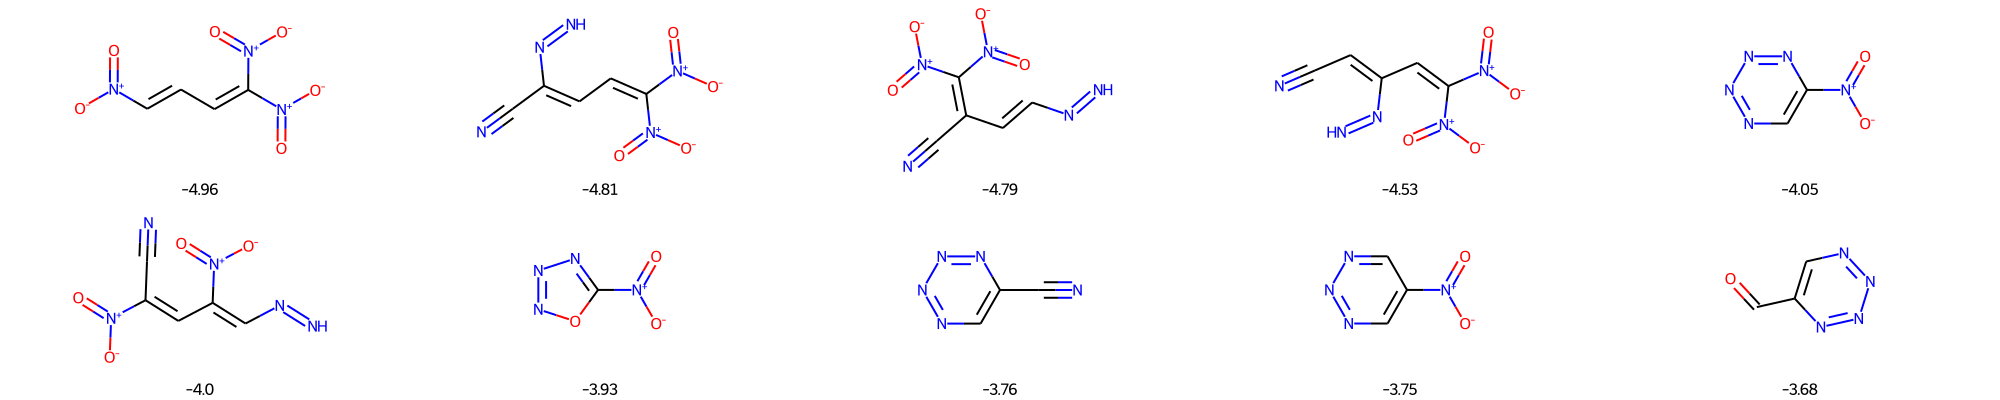

In [115]:
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df_reaction_good['SMILES']], 
                           molsPerRow=5, subImgSize=(400, 200), returnPNG=False, maxMols =100,
                           legends=[str(round(e,2)) for i,e in enumerate(df_reaction_good['LUMO_DFT(eV)_reactant']) ] )  
img.save('df_reaction_good.png')
display(img)

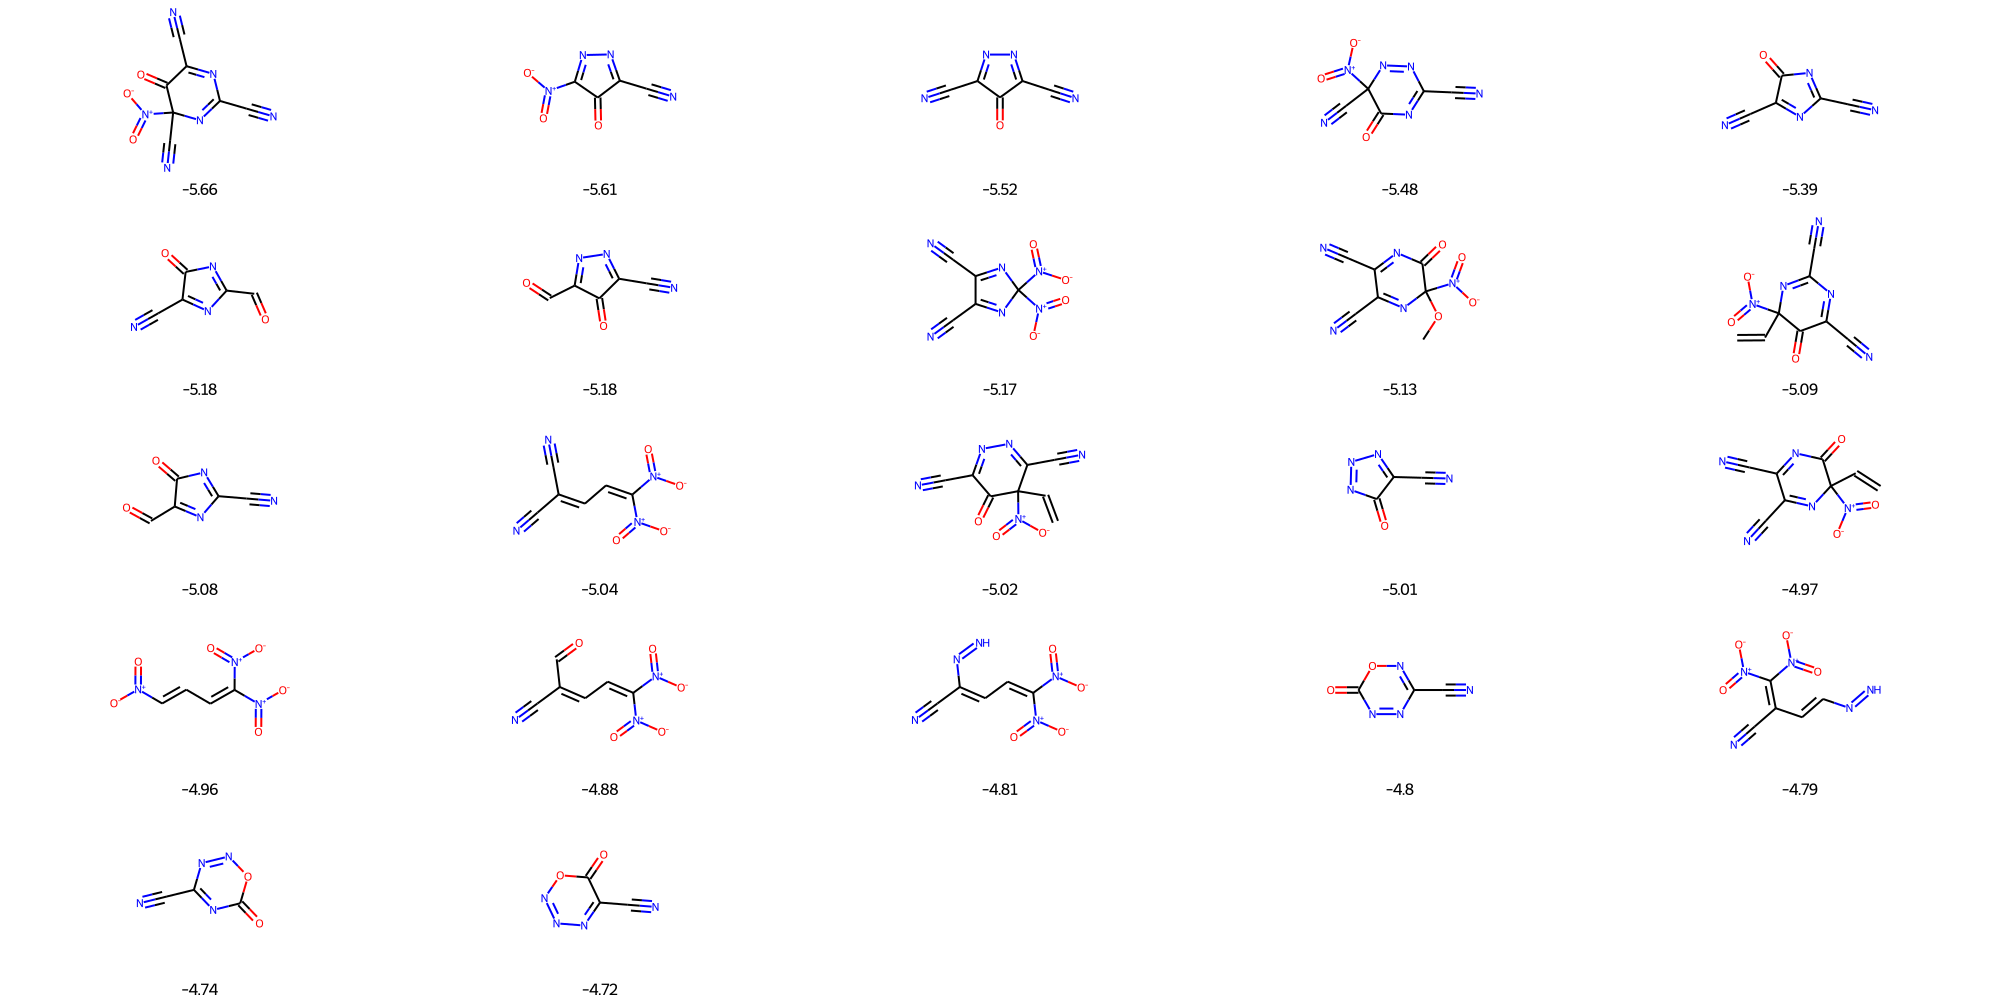

In [116]:
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df_lumo_good['SMILES']], 
                           molsPerRow=5, subImgSize=(400, 200), returnPNG=False, maxMols=100,
                           legends=[str(round(e,2)) for i,e in enumerate(df_lumo_good['LUMO_DFT(eV)_reactant']) ] )  
img.save('df_lumo_good.png')
display(img)

['O=[N+]([O-])C=CC=C([N+](=O)[O-])[N+](=O)[O-]', '1', -4.964303595580001, -3.755543917606701]
['N#CC(=CC=C([N+](=O)[O-])[N+](=O)[O-])N=N', '2', -4.80633325516, -4.5309607883609715]
['N#CC(C=CN=N)=C([N+](=O)[O-])[N+](=O)[O-]', '3', -4.79472759306, -1.2420337024595938]
['N#CC=C(C=C([N+](=O)[O-])[N+](=O)[O-])N=N', '4', -4.525391877000001, -2.5128025449812412]
['O=[N+]([O-])c1cnnnn1', '5', -4.046199123, -0.8728879317714018]
['N#CC(=CC(=CN=N)[N+](=O)[O-])[N+](=O)[O-]', '6', -3.99642675126, -2.4293424600400613]
['N#CC1=NC(C#N)([N+](=O)[O-])C(=O)C(C#N)=N1', '7', -5.66114401134, 1.0268103797570802]
['N#CC1=NN=C([N+](=O)[O-])C1=O', '8', -5.61258798918, 0.5047027989276103]
['N#CC1=NN=C(C#N)C1=O', '9', -5.51869505348, 0.8232394473307068]
['N#CC1=NC(=O)C(C#N)([N+](=O)[O-])N=N1', '10', -5.477622166320001, 2.4749591821964714]
['N#CC1=NC(=O)C(C#N)=N1', '11', -5.3873537891000005, 1.383348292481969]


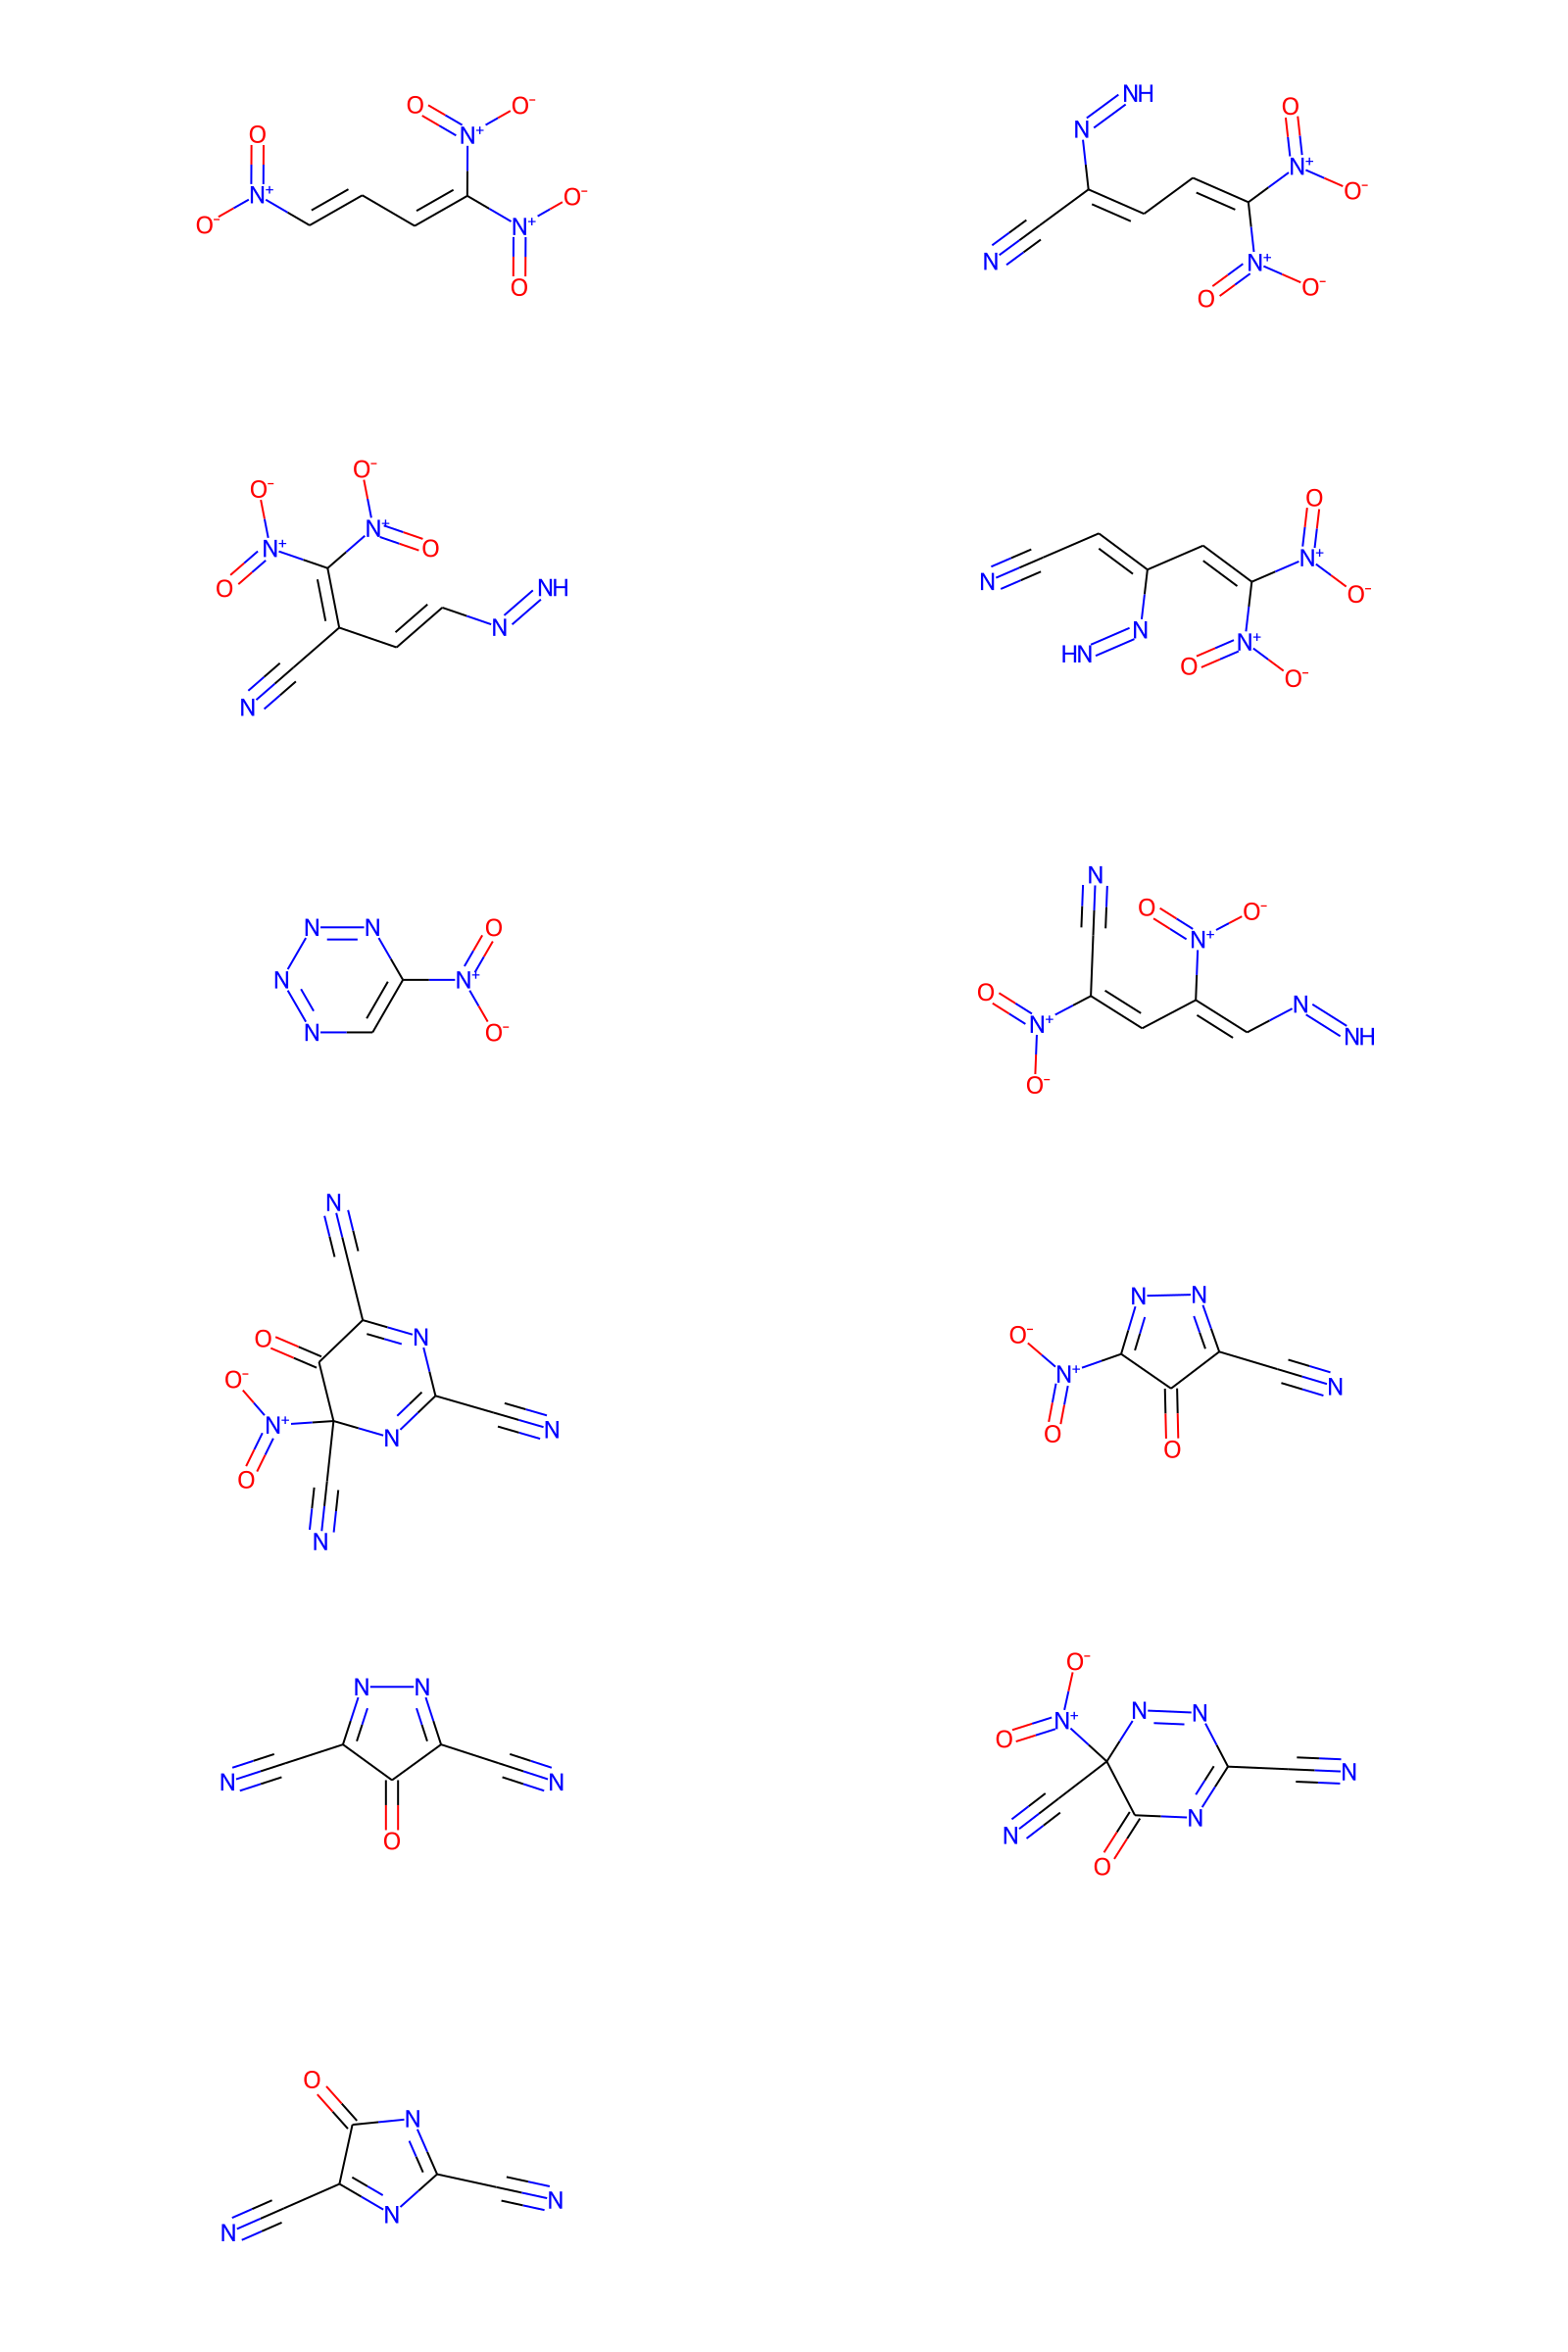

In [113]:
for i in highlight_list:
    print(i )
highlight_list_T = np.transpose(highlight_list)

img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in highlight_list_T[0]], 
                           molsPerRow=2, subImgSize=(800, 400), returnPNG=False, maxMols=100,)
                           #legends=list(highlight_list_T[1]) )  
img.save('highlight_final.png')
display(img)

# Additional analysis

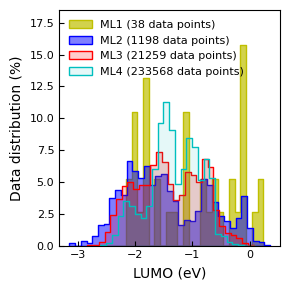

In [5]:
fig, axs = plt.subplots(1,1,figsize=(3.,3),tight_layout=True,dpi=100)
#sns.histplot(df_pnl, x='LUMO', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.9, fill=True, color='k',label=f'DFT ({len(df_pnl)} data points)', stat='percent')
sns.histplot(df1_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.7, fill=True, color='y',label=f'ML1 ({len(df1_filter)} data points)', stat='percent')
sns.histplot(df2_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.5, fill=True, color='b',label=f'ML2 ({len(df2_filter)} data points)', stat='percent')
sns.histplot(df3_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.2, fill=True, color='r',label=f'ML3 ({len(df3_filter)} data points)', stat='percent')
sns.histplot(df4_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.1, fill=True, color='c',label=f'ML4 ({len(df4_filter)} data points)', stat='percent')

axs.set_ylabel('Data distribution (%)', fontsize=10)
axs.set_xlabel('LUMO (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)
axs.legend(fontsize=8, frameon=False, loc=2)
axs.set_ylim(top=18.5)

#plt.savefig("ML_PNL_CCCC_prediction_hist.png", dpi=800)  

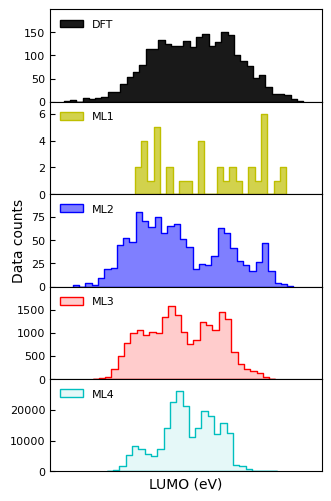

In [157]:
fig, axs = plt.subplots(5,1,figsize=(3.5,6))#,tight_layout=True,dpi=100)
sns.histplot(df_pnl, x='LUMO', kde=False, binwidth=0.1, ax=axs[0], element="step", alpha=0.9, fill=True, color='k',label=f'DFT')
sns.histplot(df1_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs[1], element="step", alpha=0.7, fill=True, color='y',label=f'ML1')
sns.histplot(df2_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs[2], element="step", alpha=0.5, fill=True, color='b',label=f'ML2')
sns.histplot(df3_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs[3], element="step", alpha=0.2, fill=True, color='r',label=f'ML3')
sns.histplot(df4_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs[4], element="step", alpha=0.1, fill=True, color='c',label=f'ML4')

ymax= [199, 6.9, 99, 1999, 29999]
for n in range(0,5):
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('')    
    axs[n].set_xticks( [] )
    axs[n].set_xticklabels([])
    axs[n].set_xlim((-3.5,0.8))
    axs[n].set_ylim(top=ymax[n])
    axs[n].tick_params(direction='in',labelsize=8)
    axs[n].legend(fontsize=8, frameon=False, loc=2)
axs[4].set_xlabel('LUMO (eV)', fontsize=10)    
axs[2].set_ylabel('Data counts', fontsize=10)

plt.subplots_adjust(wspace=0, hspace=0.0)
#plt.savefig("Prediction.png", dpi=800)  

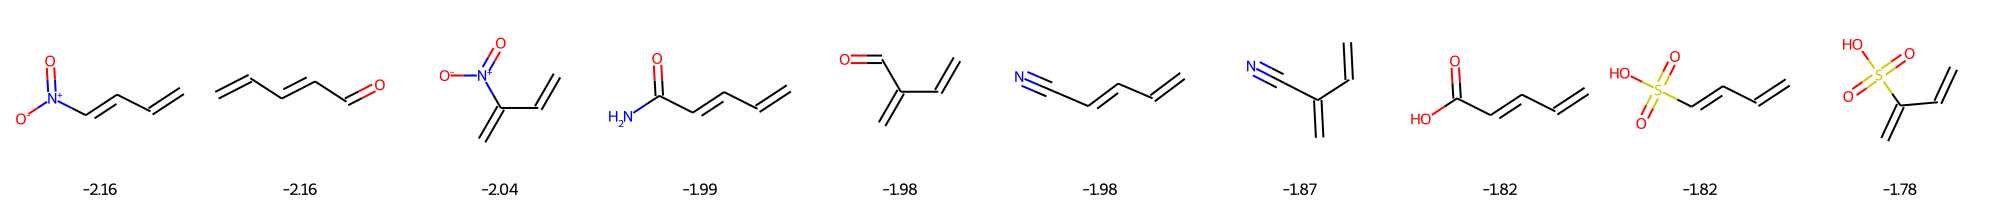

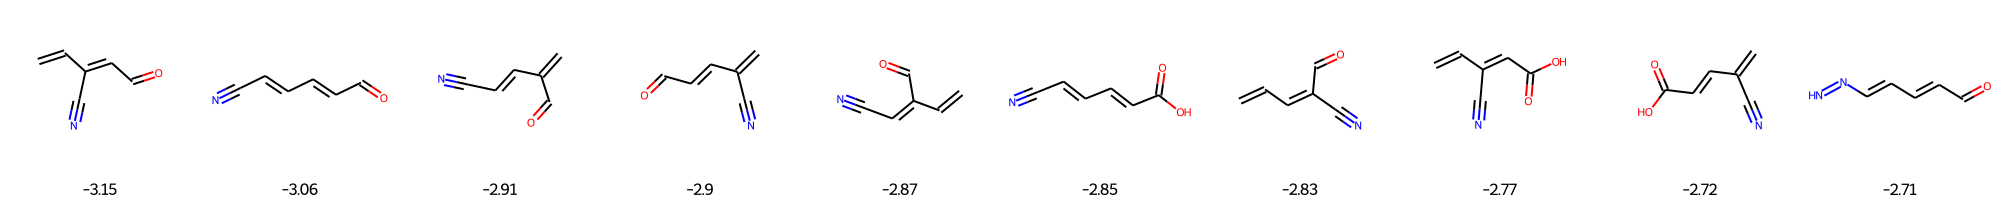

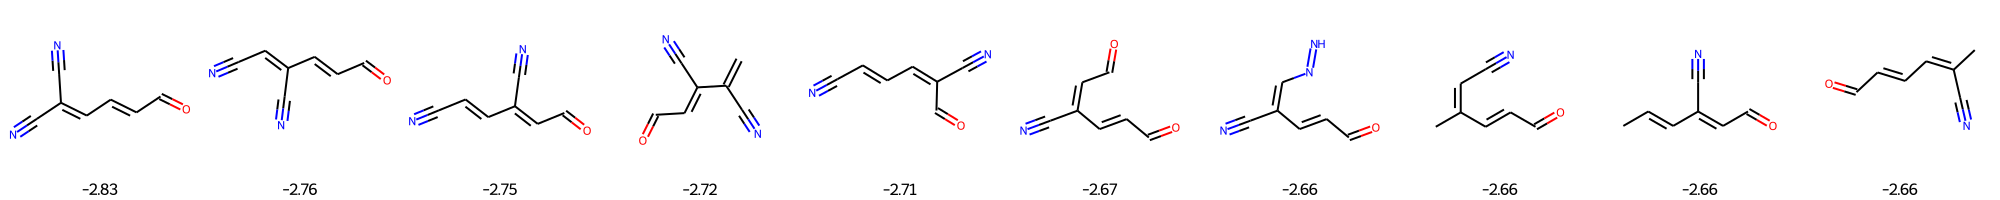

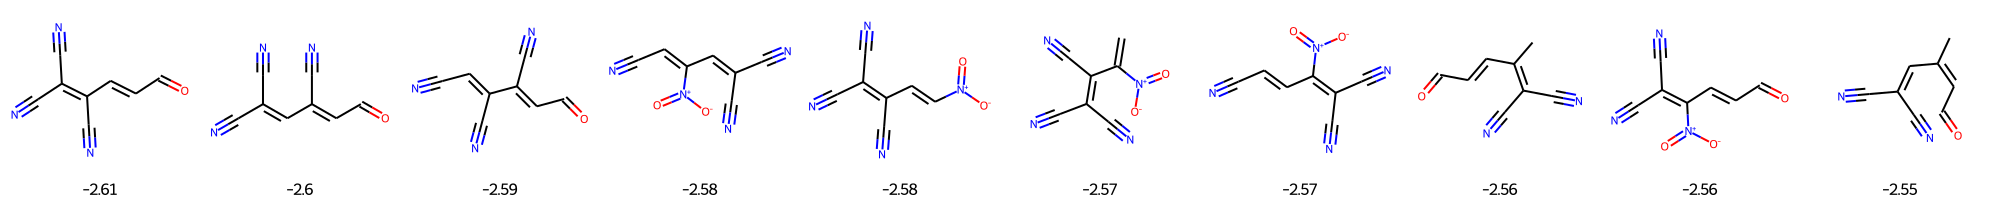

In [286]:
for top in [ df1_filter, df2_filter, df3_filter, df4_filter ]:
    top = top.head(10)
    #for l in top['LUMO_predicted']: print(l)
    img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in top['SMILES']], molsPerRow=10, legends=[str(round(p,2)) for p in top['LUMO_predicted']] )  
    display(img)

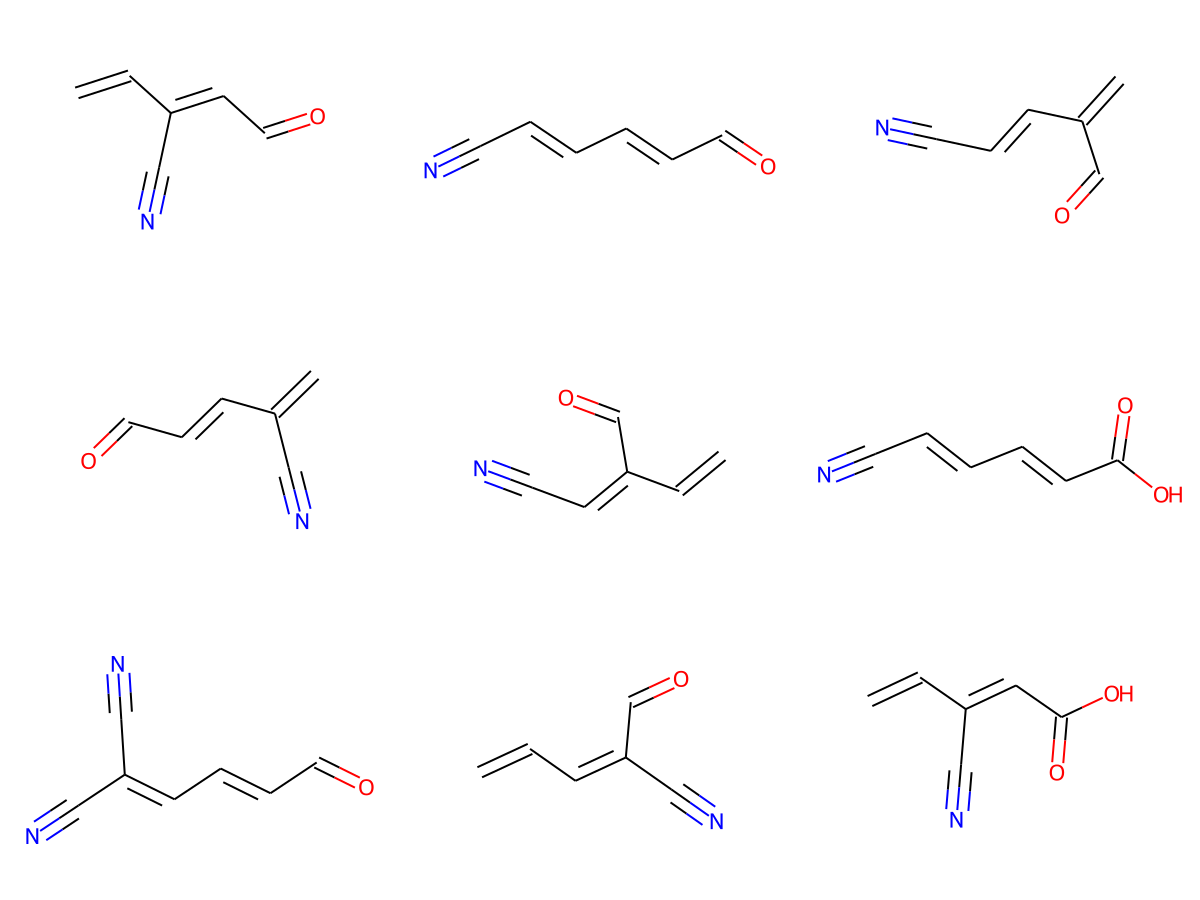

In [287]:
top = pd.concat( [ df1_filter, df2_filter, df3_filter, df4_filter ], axis=0 ).sort_values(by='LUMO_predicted',ascending=True).head(9)
#top = df2_filter.head(9)
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in top['SMILES']], molsPerRow=3, subImgSize=(400, 300), returnPNG=False,)#legends=[str(round(p,2))+' eV' for p in top['LUMO_predicted']], )  
img.save('ML_PNL_CCCC_predicted_Molecules.png')
display(img)

In [315]:
df=df_pnl.copy()
ss = []
for s in df['SMILES']:
    mol = Chem.MolFromSmiles(s)
    Chem.Kekulize(mol)
    s = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=False)
    ss.append(s)
df['SMI'] = ss

#df['SMI'] = [ Chem.CanonSmiles(s) for s in df['SMILES'] ]
for n,(s,l) in enumerate(zip(top['SMILES'],top['LUMO_predicted'])):
    ## Write XYZ
    #x = smiles_to_xyz_pybel(s, if_write_xyz=f'molecule_{n}.xyz')
    
    #s= Chem.CanonSmiles(s)   
    #inchi = Chem.MolToInchi( Chem.MolFromSmiles(s)) 
    df1 = df[df['SMI']==s]
    if len(df1)>0:
        l_ref = df1['LUMO'].values
        print(s, l, l_ref)
    else:
        print(s, l)

C=CC(C#N)=CC=O -3.148054534944163 [-3.29162262 -3.12604949]
N#CC=CC=CC=O -3.0596274636325824 [-3.25064499 -3.16320664]
C=C(C=O)C=CC#N -2.9108661218847645 [-2.93753989 -2.92926763]
C=C(C#N)C=CC=O -2.8955866862825315
C=CC(C=O)=CC#N -2.8729444457478626 [-3.13626465]
N#CC=CC=CC(=O)O -2.848597437192298 [-2.94366246 -2.93241055]
N#CC(C#N)=CC=CC=O -2.833615302941745
C=CC=C(C#N)C=O -2.8294409706036867
C=CC(C#N)=CC(=O)O -2.7748343292777884 [-2.82655826]


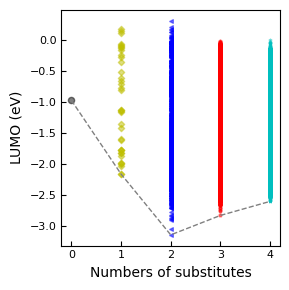

In [14]:
colors = ['k','y','b','r','c']
mk = ['o','D','<','p','*']
fig, axs = plt.subplots(1,1, figsize=(3.,3), tight_layout=True)
low_y=[]
for n,df in enumerate([df0_filter,df1_filter,df2_filter,df3_filter,df4_filter]):
    x = np.full( len(df), n )
    y = df['LUMO_predicted']
    low_y.append(np.amin(y))
    #x,y,z = color_density(x, y)
    axs.scatter(x, y, marker=mk[n], c=colors[n], cmap='jet', label='', alpha=0.5, s=20/(n+1)) 
axs.plot([0,1,2,3,4],low_y,ls='--',color='gray',lw=1)
axs.tick_params(direction='in',labelsize=8)
axs.set_ylabel('LUMO (eV)', fontsize=10)
axs.set_xlabel('Numbers of substitutes', fontsize=10)
axs.set_xticks( [0,1,2,3,4] )
plt.savefig("ML_PNL_CCCC_prediction_diagram.png", dpi=800)  
plt.show()

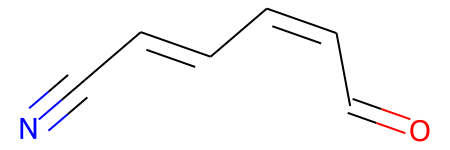

In [197]:
Chem.MolFromSmiles('N#C/C=C/C=C\C=O')

In [16]:
func_edg = ['*O','*NC','*N(C)C','*N','*OC','*NC(=O)C','*OC(=O)C','*C','*C=C']
func_ewg = ['*C=O','*C(=O)C','*C(=O)OC','*C(=O)O','*C#N','*S(=O)(=O)O','*[N+](=O)[O-]','*C=N','*C(=O)N','*N=N']
func_edg = [ Chem.CanonSmiles(f) for f in func_edg]
func_ewg = [ Chem.CanonSmiles(f) for f in func_ewg]

functional_pat1 = {
    0: [[0],[3]],
    1: [[1],[2]],
}
functional_pat2 = {
    0: [[0],[3]],
    1: [ [0,1],[2,3] ],
    2: [ [0,2],[1,3] ],
    3: [ [0,3] ],
    4: [ [1,2] ],
}

def know_functional_pattern(smiles, patterns, func_edg=func_edg, func_ewg=func_ewg):
    """
    group_type: edg -> 1, ewg ->0, None ->999
    group_loc: depends on functional_pat
    """
    functionality = locate_func(smi=smiles)
    f= sorted( list( functionality.keys() ) )
    g= [ Chem.CanonSmiles(g) for g in list(chain( *functionality.values() ) ) ]
    group_type = [ 1 if group in func_edg else 0 if group in func_ewg else 999 for group in g ]
    group_loc = [ k for k,v in patterns.items() if f in v ]
    return group_type, group_loc

In [19]:
func_info = [ know_functional_pattern(smiles=s, patterns=functional_pat1) for s in df1_filter['SMILES'] ]
df1_filter['Func_style'] = [ np.sum(f[0]) for f in func_info ]
df1_filter['Func_pattern'] =  [ f[1][0] for f in func_info ]

func_info = [ know_functional_pattern(smiles=s, patterns=functional_pat2) for s in df2_filter['SMILES'] ]
df2_filter['Func_style'] = [ np.sum(f[0]) for f in func_info ]
df2_filter['Func_pattern'] =  [ f[1][0] for f in func_info ]

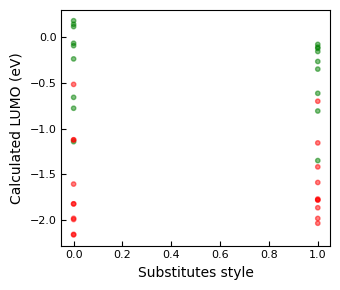

In [20]:
x,y,z = df1_filter['Func_pattern'], df1_filter['LUMO_predicted'], df1_filter['Func_style']
colors = ['r','g','b','o','c','m']
mk = ['o','D','<','p','*','v']
colors = [ colors[i] for i in z]
mk = [ mk[i] for i in x ]

fig, axs = plt.subplots(1,1, figsize=(3.5,3), tight_layout=True)
axs.scatter(x, y, marker='o', c=colors, cmap='jet', label='', alpha=0.5, s=10) 
axs.tick_params(direction='in',labelsize=8)
axs.set_ylabel('Calculated LUMO (eV)', fontsize=10)
axs.set_xlabel('Substitutes style', fontsize=10)
#axs.set_xticks( [0,1] )
#plt.savefig("ML_PNL_CCCC_prediction_diagram.png", dpi=800)  
plt.show()

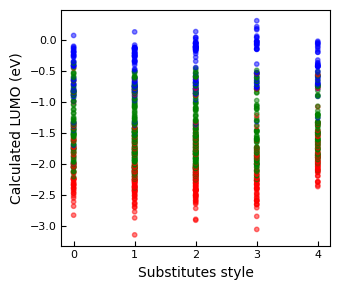

In [21]:
x,y,z =df2_filter['Func_pattern'], df2_filter['LUMO_predicted'], df2_filter['Func_style']
colors = ['r','g','b','o','c','m']
mk = ['o','D','<','p','*','v']
colors = [ colors[i] for i in z]
mk = [ mk[i] for i in x ]

fig, axs = plt.subplots(1,1, figsize=(3.5,3), tight_layout=True)
axs.scatter(x, y, marker='o', c=colors, cmap='jet', label='', alpha=0.5, s=10) 
axs.tick_params(direction='in',labelsize=8)
axs.set_ylabel('Calculated LUMO (eV)', fontsize=10)
axs.set_xlabel('Substitutes style', fontsize=10)
#axs.set_xticks( [0,1] )
plt.show()

In [26]:
pd.concat([x,y],axis=1).to_csv('tmp.csv')

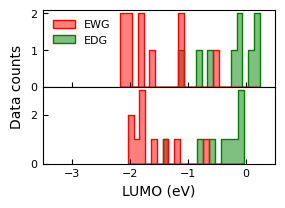

In [282]:
colors = ['r','g','b','o','c','m']
n_loc = len(df1_filter['Func_pattern'].value_counts())
fig, axs = plt.subplots(n_loc,1 ,figsize=(3,1*n_loc))#,tight_layout=True,dpi=100)
#ymax = [13,19,19,13,11]
for n in range(n_loc):
    df = df1_filter[df1_filter['Func_pattern']==n]
    sns.histplot( df, x='LUMO_predicted', hue='Func_style', kde=False, binwidth=0.1, ax=axs[n], element="step", alpha=0.5, fill=True, palette=colors, label='Style')#  )#, stat='percent', 
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('')    
    #axs[n].set_xticks( [] )
    axs[n].set_xlim((-3.5,0.5))
    #axs[n].set_ylim(top=ymax[n])
    axs[n].tick_params(direction='in',labelsize=8)
    axs[n].legend_.remove()
    if n!=n_loc-1: axs[n].set_xticklabels([])

handles, labels = axs[n_loc-1].get_legend_handles_labels()
labels = ['EDG','EWG']
axs[0].legend(handles[::-1], labels[::-1], fontsize=8, frameon=False, ncol=1, loc=2)#, bbox_to_anchor=(1,1.3), handlelength=1, handletextpad=0.2, columnspacing=1)
axs[n_loc-1].set_xlabel('LUMO (eV)', fontsize=10)    
axs[n_loc-1].set_ylabel('Data counts', fontsize=10)
axs[n_loc-1].yaxis.set_label_coords(-0.08,1.01)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("ML_PNL_CCCC_prediction_EWGEDG.png", dpi=800) 
plt.show()


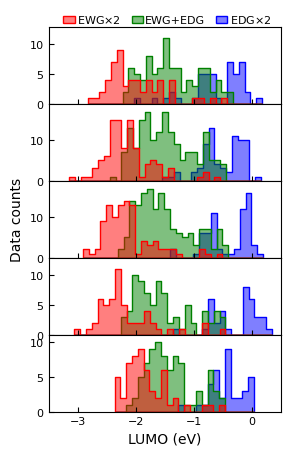

In [277]:
#from matplotlib.ticker import MaxNLocator
colors = ['r','g','b','o','c','m']
n_loc = len(df2_filter['Func_pattern'].value_counts())
fig, axs = plt.subplots(n_loc,1 ,figsize=(3,1*n_loc))#,tight_layout=True,dpi=100)
ymax = [13,19,19,13,11]
for n in range(n_loc):
    df = df2_filter[df2_filter['Func_pattern']==n]
    sns.histplot( df, x='LUMO_predicted', hue='Func_style', kde=False, binwidth=0.1, ax=axs[n], element="step", alpha=0.5, fill=True, palette=colors, label='Style')#  )#, stat='percent', 
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('')    
    #axs[n].set_xticks( [] )
    axs[n].set_xlim((-3.5,0.5))
    axs[n].set_ylim(top=ymax[n])
    axs[n].tick_params(direction='in',labelsize=8)
    axs[n].legend_.remove()
    if n!=n_loc-1: axs[n].set_xticklabels([])
    #axs[n].yaxis.set_major_locator(MaxNLocator(integer=True))

handles, labels = axs[n_loc-1].get_legend_handles_labels()
labels = [r'EDG$\times$2','EWG+EDG',r'EWG$\times$2']
axs[0].legend(handles[::-1], labels[::-1], fontsize=8, frameon=False, ncol=3, bbox_to_anchor=(1,1.3), handlelength=1, handletextpad=0.2, columnspacing=1)
axs[n_loc-1].set_xlabel('LUMO (eV)', fontsize=10)    
axs[2].set_ylabel('Data counts', fontsize=10)
#axs[n_loc-1].set_xticklabels([-3.5,-2.5,-1.5,-0.5,0.5])
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("ML_PNL_CCCC_prediction_EWGEDG2.png", dpi=800) 
plt.show()
